In [21]:
! pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib
! pip install -U ipywidgets
! pip install numpy==1.26.4
! pip install urllib3==1.26.6

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=89046) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


In [22]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, Union, Callable


import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader
from flwr.server.strategy import Strategy
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context, Status, GetParametersRes, Parameters, GetParametersIns, MetricsAggregationFn,NDArrays,Scalar
from flwr.server import ServerApp, ServerConfig, ServerAppComponents 
from flwr.server.strategy import FedAvg, FedProx
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager, SimpleClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.15.2 / PyTorch 2.6.0


In [23]:

BATCH_SIZE = 32

def load_datasets(partition_id, num_partitions: int):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": num_partitions})
    partition = fds.load_partition(partition_id)
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(partition_train_test["train"], batch_size=32, shuffle=True)
    valloader = DataLoader(partition_train_test["test"], batch_size=32)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=32)
    return trainloader, valloader, testloader

In [ ]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class MoonNet(nn.Module):
    """Returns both the representation (penultimate layer output) and classification"""
    def __init__(self) -> None:
        super(MoonNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        representation = x.clone()
        classification = self.fc3(x)
        return representation, classification

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")
        
def proxima_train(net, trainloader, epochs: int, proximal_mu:float, global_params:List[torch.Tensor]):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)

            proximal_term = 0.0
            for local_weights, global_weights in zip(net.parameters(), global_params):
                proximal_term += (local_weights - global_weights).norm(2)
            loss = criterion(net(images), labels) + (proximal_mu / 2) * proximal_term


            loss.backward()
            optimizer.step()
            
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def train_moon(net,train_loader, global_net,previous_net, epochs, mu, temperature):
    """Training function for MOON."""
    print(f"Started training moon")
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    previous_net.eval()
    global_net.eval()

    cnt = 0
    cos = torch.nn.CosineSimilarity(dim=-1)

    for epoch in range(epochs):
        epoch_loss_collector = []
        epoch_loss1_collector = []
        epoch_loss2_collector = []
        for batch in train_loader:
            x, target = batch["img"], batch["label"]
            x, target = x.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()

            # pro1 is the representation by the current model (Line 14 of Algorithm 1)
            pro1, out = net(x)
            # pro2 is the representation by the global model (Line 15 of Algorithm 1)
            # pro3 is the representation by the previous model (Line 16 of Algorithm 1)
            with torch.no_grad():
                pro2, _ = global_net(x)
                pro3, _ = previous_net(x)

            # posi is the positive pair
            posi = cos(pro1, pro2)
            logits = posi.reshape(-1, 1)

            # nega is the negative pair
            nega = cos(pro1, pro3)
            logits = torch.cat((logits, nega.reshape(-1, 1)), dim=1)

            previous_net.to("cpu")
            logits /= temperature
            labels = torch.zeros(x.size(0)).to(DEVICE).long()

            # compute the model-contrastive loss (Line 17 of Algorithm 1)
            loss2 = mu * criterion(logits, labels)

            # compute the cross-entropy loss (Line 13 of Algorithm 1)
            loss1 = criterion(out, target)

            # compute the loss (Line 18 of Algorithm 1)
            loss = loss1 + loss2

            loss.backward()
            optimizer.step()

            cnt += 1
            epoch_loss_collector.append(loss.item())
            epoch_loss1_collector.append(loss1.item())
            epoch_loss2_collector.append(loss2.item())

        epoch_loss = sum(epoch_loss_collector) / len(epoch_loss_collector)
        epoch_loss1 = sum(epoch_loss1_collector) / len(epoch_loss1_collector)
        epoch_loss2 = sum(epoch_loss2_collector) / len(epoch_loss2_collector)
        print(
            "Epoch: %d Loss: %f Loss1: %f Loss2: %f"
            % (epoch, epoch_loss, epoch_loss1, epoch_loss2)
        )


def test_moon(net, testloader):
    """
    Evaluate the network on the entire test set.
    Same as the regular test, but using the MoonNet 
    (where the output is a tuple of (representation, classification) )
    """
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            _, outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy




def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

def freeze_layers(model: torch.nn.Module, trainable_layers: int) -> None:
        """Freeze specified layers of the model."""
        for idx, (name, param) in enumerate(model.named_parameters()):
            if idx == trainable_layers or trainable_layers == -1:
                param.requires_grad = True
            else:
                param.requires_grad = False

In [25]:

NETWORK_LEN = len(Net().state_dict().keys())
EPOCHS = 8
NUM_PARTITIONS = 6
NUM_OF_CYCLES  = 1
NUM_OF_FULL_UPDATES_BETWEEN_CYCLES = 5
NUM_OF_ROUNDS = (NUM_OF_CYCLES * NUM_OF_FULL_UPDATES_BETWEEN_CYCLES) + (NUM_OF_CYCLES * NETWORK_LEN *2)
print(f"Number of rounds: {NUM_OF_ROUNDS}")
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}


Number of rounds: 25


In [26]:
from flwr.common import NDArrays, Scalar

def get_evaluate_fn(
    testloader: DataLoader,
    net: torch.nn.Module,
) -> Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]:
    """Return an evaluation function for server-side evaluation."""

    def evaluate(
        server_round: int, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Use the entire test set for evaluation."""
        
        # Copy model parameters to avoid modifying the original
        net_copy = copy.deepcopy(net)
        
        # Update model with the latest parameters
        params_dict = zip(net_copy.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        net_copy.load_state_dict(state_dict, strict=True)
        
        net_copy.to(DEVICE)
        net_copy.eval()

        # Test the model
        loss, accuracy = test(net_copy, testloader)
        
        # Return loss and metrics
        return loss, {"accuracy": accuracy}

    return evaluate

In [27]:
class DropoutClientManager(SimpleClientManager):
    """Custom ClientManager that simulates client dropouts."""
    def __init__(self, dropout_rate: float = 0.4):
        super().__init__()
        self.dropout_rate = dropout_rate

    def sample(
        self,
        num_clients: int,
        min_num_clients: Optional[int] = None,
    ) -> List[ClientProxy]:
        """Sample clients and simulate dropouts."""
        # Get list of clients from parent class
        clients = super().sample(num_clients, min_num_clients)
        
        # Randomly drop clients based on dropout rate
        num_dropouts = int(len(clients) * self.dropout_rate)
        if num_dropouts > 0:
            dropout_indices = np.random.choice(
                len(clients), 
                size=num_dropouts, 
                replace=False
            )
            clients = [c for i, c in enumerate(clients) if i not in dropout_indices]
        
        return clients

# Normal FedAvg

In [28]:
from typing import Union
import sys

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

def get_parameters_size(params: Parameters) -> int:
    size = sys.getsizeof(params)  # Base size of the dataclass instance
    size += sys.getsizeof(params.tensor_type)  # Size of the string
    size += sys.getsizeof(params.tensors)  # Size of the list container
    size += sum(sys.getsizeof(tensor) for tensor in params.tensors)  # Size of each bytes object
    return size

fed_avg_result = {}
fed_avg_model_results = {}

class ModifiedFedAvg(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
    
   
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)
    


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res

        if server_round in fed_avg_model_results:
            expand_fed_avg_result= {**fed_avg_model_results[server_round], "global_loss": loss, "global_metrics": metrics}
        else:
            expand_fed_avg_result= {"global_loss": loss, "global_metrics": metrics}

        fed_avg_model_results[server_round] = expand_fed_avg_result

        return loss, metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        
        return fit_configurations
    

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        # get size of parameters in bytes
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        

        if server_round in fed_avg_result:
            expand_fed_avg_result= {**fed_avg_result[server_round], "total_size": total_size}
        else:
            expand_fed_avg_result= {"total_size": total_size}

        fed_avg_result[server_round] = expand_fed_avg_result


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss 


        if server_round in fed_avg_result:
            expand_fed_avg_result= {**fed_avg_result[server_round], "total_loss": total_loss}
        else:
            expand_fed_avg_result= {"total_loss": total_loss}

        fed_avg_result[server_round] = expand_fed_avg_result

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

In [29]:
class NormalFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=EPOCHS)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}



def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return NormalFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [30]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)
client_manager =  DropoutClientManager(dropout_rate=0.5)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=ModifiedFedAvg(
            evaluate_fn=evaluate_fn
        ),
        client_manager=client_manager
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07209176514148712, {'accuracy': 0.1}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39969) [Client 3] fit, config: {}


(ClientAppActor pid=39969) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=39969)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=39969) Epoch 1: train loss 0.06499619781970978, accuracy 0.21812181218121812
(ClientAppActor pid=39970) [Client 1] fit, config: {} [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=39969) Epoch 3: train loss 0.05602773278951645, accuracy 0.33123312331233123 [repeated 6x across cluster]
(ClientAppActor pid=39968) Epoch 5: train loss 0.05072665959596634, accuracy 0.39528952895289526 [repeated 7x across cluster]
(ClientAppActor pid=39969) Epoch 8: train loss 0.0459899827837944, accuracy 0.45574557455745573 [repeated 8x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (1, 0.061315002405643464, {'accuracy': 0.3404}, 29.41598933399655)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39968) [Client 4] evaluate, config: {}


(ClientAppActor pid=39968) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=39968)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39970) [Client 4] fit, config: {}
(ClientAppActor pid=39970) Epoch 8: train loss 0.046157531440258026, accuracy 0.45402729863506824 [repeated 2x across cluster]
(ClientAppActor pid=39969) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39969) [Client 3] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39968) Epoch 2: train loss 0.047822505235672, accuracy 0.4336933693369337 [repeated 5x across cluster]
(ClientAppActor pid=39969) Epoch 4: train loss 0.04502272233366966, accuracy 0.46564656465646564 [repeated 7x across cluster]
(ClientAppActor pid=39970) Epoch 7: train loss 0.038422033190727234, accuracy 0.5561056105610561 [repeated 7x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (2, 0.0431159835934639, {'accuracy': 0.4987}, 55.121292583993636)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39969) [Client 2] evaluate, config: {}
(ClientAppActor pid=39968) Epoch 8: train loss 0.03864395245909691, accuracy 0.5477047704770477 [repeated 5x across cluster]


(ClientAppActor pid=39969) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39969)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39970) [Client 4] fit, config: {}
(ClientAppActor pid=39968) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39969) Epoch 1: train loss 0.04475198686122894, accuracy 0.4828982898289829 [repeated 2x across cluster]
(ClientAppActor pid=39969) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39970) Epoch 4: train loss 0.03432486206293106, accuracy 0.6065106510651065 [repeated 8x across cluster]
(ClientAppActor pid=39968) Epoch 6: train loss 0.03540247678756714, accuracy 0.591570421478926 [repeated 8x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (3, 0.04100710619091988, {'accuracy': 0.5428}, 80.83468775000074)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39969) [Client 1] evaluate, config: {}
(ClientAppActor pid=39968) Epoch 8: train loss 0.032898735255002975, accuracy 0.6161691915404229 [repeated 6x across cluster]


(ClientAppActor pid=39969) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39969)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39969) [Client 4] fit, config: {}
(ClientAppActor pid=39968) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39969) Epoch 1: train loss 0.03657552972435951, accuracy 0.5795079507950796
(ClientAppActor pid=39968) Epoch 1: train loss 0.03934509679675102, accuracy 0.5562556255625563
(ClientAppActor pid=39970) [Client 5] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39970) Epoch 3: train loss 0.03483719751238823, accuracy 0.6026102610261026 [repeated 7x across cluster]
(ClientAppActor pid=39969) Epoch 6: train loss 0.025293905287981033, accuracy 0.713021302130213 [repeated 7x across cluster]
(ClientAppActor pid=39969) Epoch 8: train loss 0.022403763607144356, accuracy 0.7425742574257426 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (4, 0.04122773957848549, {'accuracy': 0.5631}, 108.94744449999416)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39969) [Client 5] evaluate, config: {}


(ClientAppActor pid=39969) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39969)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=39970) Epoch 8: train loss 0.027028245851397514, accuracy 0.6857185718571858 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39970) [Client 2] fit, config: {}
(ClientAppActor pid=39968) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39970) Epoch 1: train loss 0.0345793291926384, accuracy 0.6093609360936093
(ClientAppActor pid=39969) Epoch 1: train loss 0.03263924643397331, accuracy 0.6302130213021302
(ClientAppActor pid=39969) [Client 4] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39970) Epoch 3: train loss 0.028913475573062897, accuracy 0.6746174617461747 [repeated 5x across cluster]
(ClientAppActor pid=39970) Epoch 5: train loss 0.02516094408929348, accuracy 0.714971497149715 [repeated 6x across cluster]
(ClientAppActor pid=39970) Epoch 7: train loss 0.02168816700577736, accuracy 0.7556255625562557 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (5, 0.04284639004468918, {'accuracy': 0.5719}, 140.1869417919952)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39968) [Client 4] evaluate, config: {}
(ClientAppActor pid=39969) Epoch 8: train loss 0.018575813621282578, accuracy 0.7929792979297929 [repeated 5x across cluster]


(ClientAppActor pid=39968) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39968)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39969) [Client 2] fit, config: {}
(ClientAppActor pid=39970) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39969) Epoch 1: train loss 0.03315982595086098, accuracy 0.6254125412541254
(ClientAppActor pid=39970) Epoch 1: train loss 0.03545787185430527, accuracy 0.6059697015149242
(ClientAppActor pid=39968) [Client 3] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39969) Epoch 3: train loss 0.026314815506339073, accuracy 0.704020402040204 [repeated 5x across cluster]
(ClientAppActor pid=39969) Epoch 5: train loss 0.02125869318842888, accuracy 0.7560756075607561 [repeated 6x across cluster]
(ClientAppActor pid=39969) Epoch 7: train loss 0.01816205121576786, accuracy 0.7958295829582959 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (6, 0.04285971940755844, {'accuracy': 0.5809}, 172.34260370899574)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39969) [Client 4] evaluate, config: {}
(ClientAppActor pid=39968) Epoch 8: train loss 0.024270430207252502, accuracy 0.723972397239724 [repeated 5x across cluster]


(ClientAppActor pid=39969) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39969)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39969) [Client 2] fit, config: {}
(ClientAppActor pid=39970) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39970) Epoch 1: train loss 0.03155714273452759, accuracy 0.6490175491225438
(ClientAppActor pid=39969) Epoch 1: train loss 0.02951926551759243, accuracy 0.6660666066606661
(ClientAppActor pid=39968) [Client 5] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39970) Epoch 3: train loss 0.024575937539339066, accuracy 0.7253637318134093 [repeated 5x across cluster]
(ClientAppActor pid=39969) Epoch 5: train loss 0.01837274804711342, accuracy 0.7934293429342935 [repeated 6x across cluster]
(ClientAppActor pid=39970) Epoch 7: train loss 0.01736477203667164, accuracy 0.808609569521524 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (7, 0.0455371090054512, {'accuracy': 0.5852}, 203.91140008400544)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39970) [Client 5] evaluate, config: {}
(ClientAppActor pid=39968) Epoch 8: train loss 0.021525302901864052, accuracy 0.7520252025202521 [repeated 5x across cluster]


(ClientAppActor pid=39970) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39970)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39969) [Client 0] fit, config: {}
(ClientAppActor pid=39969) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39969) Epoch 1: train loss 0.028464073315262794, accuracy 0.6857657117144143
(ClientAppActor pid=39970) Epoch 1: train loss 0.03922756761312485, accuracy 0.5610561056105611
(ClientAppActor pid=39968) [Client 1] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39970) Epoch 3: train loss 0.03088003769516945, accuracy 0.6488148814881488 [repeated 5x across cluster]
(ClientAppActor pid=39970) Epoch 5: train loss 0.0263501089066267, accuracy 0.7017701770177017 [repeated 6x across cluster]
(ClientAppActor pid=39969) Epoch 7: train loss 0.013650177046656609, accuracy 0.8507574621268936 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (8, 0.04174681064486504, {'accuracy': 0.5935}, 235.14866070900462)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39968) [Client 2] evaluate, config: {}
(ClientAppActor pid=39968) Epoch 8: train loss 0.023077664896845818, accuracy 0.7403629818509074 [repeated 5x across cluster]


(ClientAppActor pid=39968) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39968)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39969) [Client 2] fit, config: {}
(ClientAppActor pid=39970) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39969) Epoch 1: train loss 0.03196631371974945, accuracy 0.636963696369637
(ClientAppActor pid=39968) Epoch 1: train loss 0.03502725437283516, accuracy 0.6098109810981098
(ClientAppActor pid=39970) [Client 1] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39969) Epoch 3: train loss 0.024066202342510223, accuracy 0.7241224122412241 [repeated 5x across cluster]
(ClientAppActor pid=39969) Epoch 5: train loss 0.01876881904900074, accuracy 0.7898289828982898 [repeated 6x across cluster]
(ClientAppActor pid=39969) Epoch 7: train loss 0.015230164863169193, accuracy 0.8268826882688269 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (9, 0.04411832021474838, {'accuracy': 0.5975}, 266.6414542499988)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39970) [Client 1] evaluate, config: {}
(ClientAppActor pid=39970) Epoch 8: train loss 0.016174327582120895, accuracy 0.8162591870406479 [repeated 5x across cluster]


(ClientAppActor pid=39970) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39970)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39970) [Client 4] fit, config: {}
(ClientAppActor pid=39968) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39969) Epoch 1: train loss 0.026167381554841995, accuracy 0.7022202220222022
(ClientAppActor pid=39970) Epoch 1: train loss 0.02877567708492279, accuracy 0.6798679867986799
(ClientAppActor pid=39969) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39970) Epoch 3: train loss 0.022331755608320236, accuracy 0.746024602460246 [repeated 5x across cluster]
(ClientAppActor pid=39968) Epoch 5: train loss 0.01964493840932846, accuracy 0.7798110094495275 [repeated 6x across cluster]
(ClientAppActor pid=39968) Epoch 7: train loss 0.015703393146395683, accuracy 0.824358782060897 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (10, 0.048977835088968275, {'accuracy': 0.594}, 301.31092395901214)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39970) [Client 4] evaluate, config: {}
(ClientAppActor pid=39969) Epoch 8: train loss 0.010226000100374222, accuracy 0.8852385238523852 [repeated 5x across cluster]


(ClientAppActor pid=39970) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39970)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39968) [Client 4] fit, config: {}
(ClientAppActor pid=39969) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39968) Epoch 1: train loss 0.026227712631225586, accuracy 0.7094209420942095
(ClientAppActor pid=39970) Epoch 1: train loss 0.04055172950029373, accuracy 0.5534053405340534
(ClientAppActor pid=39969) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39968) Epoch 3: train loss 0.019009457901120186, accuracy 0.7848784878487849 [repeated 5x across cluster]
(ClientAppActor pid=39970) Epoch 5: train loss 0.025821441784501076, accuracy 0.7002700270027002 [repeated 6x across cluster]
(ClientAppActor pid=39968) Epoch 7: train loss 0.011435446329414845, accuracy 0.8724872487248725 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (11, 0.04857299736738205, {'accuracy': 0.5949}, 332.5320826249954)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39968) [Client 5] evaluate, config: {}
(ClientAppActor pid=39969) Epoch 8: train loss 0.007608212064951658, accuracy 0.9195919591959196 [repeated 5x across cluster]


(ClientAppActor pid=39968) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39968)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39968) [Client 5] fit, config: {}
(ClientAppActor pid=39969) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39968) Epoch 1: train loss 0.0319945365190506, accuracy 0.6486648664866487
(ClientAppActor pid=39969) Epoch 1: train loss 0.033043272793293, accuracy 0.6368681565921704
(ClientAppActor pid=39970) [Client 4] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39968) Epoch 3: train loss 0.024089688435196877, accuracy 0.7283228322832284 [repeated 5x across cluster]
(ClientAppActor pid=39968) Epoch 5: train loss 0.01953023299574852, accuracy 0.7808280828082809 [repeated 6x across cluster]
(ClientAppActor pid=39968) Epoch 7: train loss 0.015503386035561562, accuracy 0.8283828382838284 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (12, 0.05111588177084923, {'accuracy': 0.5929}, 364.43386420901516)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=39970) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39970)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=39970) [Client 0] evaluate, config: {}
(ClientAppActor pid=39970) Epoch 8: train loss 0.006818891502916813, accuracy 0.9306930693069307 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39968) [Client 4] fit, config: {}
(ClientAppActor pid=39969) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39969) Epoch 1: train loss 0.029462411999702454, accuracy 0.6744674467446745
(ClientAppActor pid=39968) Epoch 1: train loss 0.020799629390239716, accuracy 0.7649264926492649
(ClientAppActor pid=39970) [Client 3] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39969) Epoch 3: train loss 0.019831117242574692, accuracy 0.7754275427542754 [repeated 5x across cluster]
(ClientAppActor pid=39969) Epoch 5: train loss 0.014884322881698608, accuracy 0.834983498349835 [repeated 6x across cluster]
(ClientAppActor pid=39968) Epoch 7: train loss 0.006939396727830172, accuracy 0.9270927092709271 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (13, 0.05105967522263527, {'accuracy': 0.5941}, 396.0591110420064)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39968) [Client 5] evaluate, config: {}
(ClientAppActor pid=39970) Epoch 8: train loss 0.019009219482541084, accuracy 0.7853285328532853 [repeated 5x across cluster]


(ClientAppActor pid=39968) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39968)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39968) [Client 4] fit, config: {}
(ClientAppActor pid=39970) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39968) Epoch 1: train loss 0.01747962273657322, accuracy 0.7968796879687969
(ClientAppActor pid=39969) Epoch 1: train loss 0.03282513841986656, accuracy 0.6495649564956496
(ClientAppActor pid=39970) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39968) Epoch 3: train loss 0.010934215970337391, accuracy 0.878037803780378 [repeated 5x across cluster]
(ClientAppActor pid=39968) Epoch 5: train loss 0.007782787550240755, accuracy 0.9146414641464147 [repeated 6x across cluster]
(ClientAppActor pid=39968) Epoch 7: train loss 0.005235572345554829, accuracy 0.9444944494449445 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (14, 0.050774546217918395, {'accuracy': 0.5969}, 427.8343512089923)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39968) [Client 4] evaluate, config: {}
(ClientAppActor pid=39970) Epoch 8: train loss 0.015519208274781704, accuracy 0.8290085495725213 [repeated 5x across cluster]


(ClientAppActor pid=39968) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39968)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39969) [Client 0] fit, config: {}
(ClientAppActor pid=39969) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39969) Epoch 1: train loss 0.030343741178512573, accuracy 0.6779661016949152
(ClientAppActor pid=39970) Epoch 1: train loss 0.033392198383808136, accuracy 0.6383680815959202
(ClientAppActor pid=39968) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39969) Epoch 3: train loss 0.022401241585612297, accuracy 0.7480125993700315 [repeated 5x across cluster]
(ClientAppActor pid=39968) Epoch 5: train loss 0.013534690253436565, accuracy 0.8498349834983498 [repeated 6x across cluster]
(ClientAppActor pid=39968) Epoch 7: train loss 0.010129892267286777, accuracy 0.8904890489048904 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (15, 0.05085101485848427, {'accuracy': 0.594}, 459.6757553750067)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39969) [Client 1] evaluate, config: {}
(ClientAppActor pid=39970) Epoch 8: train loss 0.011979246512055397, accuracy 0.872356382180891 [repeated 5x across cluster]


(ClientAppActor pid=39969) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39969)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39968) [Client 0] fit, config: {}
(ClientAppActor pid=39968) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39968) Epoch 1: train loss 0.024687770754098892, accuracy 0.7262636868156592
(ClientAppActor pid=39969) Epoch 1: train loss 0.024947749450802803, accuracy 0.7189140542972852
(ClientAppActor pid=39970) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39968) Epoch 3: train loss 0.01700376719236374, accuracy 0.8123593820308984 [repeated 5x across cluster]
(ClientAppActor pid=39968) Epoch 5: train loss 0.012270169332623482, accuracy 0.864406779661017 [repeated 6x across cluster]
(ClientAppActor pid=39968) Epoch 7: train loss 0.009200140833854675, accuracy 0.9038548072596371 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (16, 0.0609988344848156, {'accuracy': 0.5884}, 490.7535835840099)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39969) [Client 0] evaluate, config: {}
(ClientAppActor pid=39969) Epoch 8: train loss 0.008968615904450417, accuracy 0.903254837258137 [repeated 5x across cluster]


(ClientAppActor pid=39969) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39969)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39970) [Client 3] fit, config: {}
(ClientAppActor pid=39968) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39970) Epoch 1: train loss 0.038727421313524246, accuracy 0.6059105910591059
(ClientAppActor pid=39969) Epoch 1: train loss 0.018629420548677444, accuracy 0.7889288928892889
(ClientAppActor pid=39969) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39970) Epoch 3: train loss 0.027856308966875076, accuracy 0.6852685268526852 [repeated 5x across cluster]
(ClientAppActor pid=39970) Epoch 5: train loss 0.0222484078258276, accuracy 0.7439243924392439 [repeated 6x across cluster]
(ClientAppActor pid=39970) Epoch 7: train loss 0.018037134781479836, accuracy 0.7913291329132913 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (17, 0.055111555886268614, {'accuracy': 0.5937}, 522.1394730840111)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39970) [Client 4] evaluate, config: {}
(ClientAppActor pid=39969) Epoch 8: train loss 0.004117331467568874, accuracy 0.9608460846084609 [repeated 5x across cluster]


(ClientAppActor pid=39970) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39970)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39968) [Client 3] fit, config: {}
(ClientAppActor pid=39969) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39968) Epoch 1: train loss 0.028798747807741165, accuracy 0.6833183318331834
(ClientAppActor pid=39970) Epoch 1: train loss 0.019076857715845108, accuracy 0.7881788178817882
(ClientAppActor pid=39969) [Client 1] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39970) Epoch 3: train loss 0.011844000779092312, accuracy 0.8672367236723673 [repeated 5x across cluster]
(ClientAppActor pid=39970) Epoch 5: train loss 0.007774601224809885, accuracy 0.918091809180918 [repeated 6x across cluster]
(ClientAppActor pid=39970) Epoch 7: train loss 0.005340708419680595, accuracy 0.9458445844584459 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (18, 0.05809436027407646, {'accuracy': 0.5877}, 553.5328010840167)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39970) [Client 2] evaluate, config: {}
(ClientAppActor pid=39969) Epoch 8: train loss 0.00979246199131012, accuracy 0.8915554222288885 [repeated 5x across cluster]


(ClientAppActor pid=39970) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39970)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39970) [Client 3] fit, config: {}
(ClientAppActor pid=39969) [Client 0] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=39970) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=39970)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=39970) Epoch 1: train loss 0.02531055361032486, accuracy 0.7193219321932193
(ClientAppActor pid=39969) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39969) Epoch 3: train loss 0.021777091547846794, accuracy 0.7615119244037798 [repeated 6x across cluster]
(ClientAppActor pid=39969) Epoch 5: train loss 0.015584592707455158, accuracy 0.8312584370781461 [repeated 6x across cluster]
(ClientAppActor pid=39968) Epoch 7: train loss 0.007564551196992397, accuracy 0.920053997300135 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (19, 0.05777974962592125, {'accuracy': 0.5887}, 587.935064499994)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39968) [Client 5] evaluate, config: {}
(ClientAppActor pid=39968) Epoch 8: train loss 0.006255277898162603, accuracy 0.9371531423428828 [repeated 5x across cluster]


(ClientAppActor pid=39968) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=39968)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39969) [Client 2] fit, config: {}
(ClientAppActor pid=39970) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39969) Epoch 1: train loss 0.028919687494635582, accuracy 0.6992199219921992
(ClientAppActor pid=39968) Epoch 1: train loss 0.04162312299013138, accuracy 0.5759075907590759
(ClientAppActor pid=39968) [Client 5] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39969) Epoch 3: train loss 0.017859090119600296, accuracy 0.7904290429042904 [repeated 5x across cluster]
(ClientAppActor pid=39969) Epoch 5: train loss 0.012887506745755672, accuracy 0.8537353735373537 [repeated 6x across cluster]
(ClientAppActor pid=39968) Epoch 7: train loss 0.01991046778857708, accuracy 0.7692769276927692 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (20, 0.05350880709290504, {'accuracy': 0.5931}, 620.2587203340081)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39970) [Client 1] evaluate, config: {}
(ClientAppActor pid=39970) Epoch 8: train loss 0.006738393101841211, accuracy 0.9292035398230089 [repeated 5x across cluster]


(ClientAppActor pid=39970) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39970)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39969) [Client 0] fit, config: {}
(ClientAppActor pid=39969) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39969) Epoch 1: train loss 0.01900632493197918, accuracy 0.784160791960402
(ClientAppActor pid=39970) Epoch 1: train loss 0.02539476938545704, accuracy 0.7145642717864107
(ClientAppActor pid=39968) [Client 3] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39969) Epoch 3: train loss 0.011662155389785767, accuracy 0.8729563521823909 [repeated 5x across cluster]
(ClientAppActor pid=39969) Epoch 5: train loss 0.007946580648422241, accuracy 0.9148042597870106 [repeated 6x across cluster]
(ClientAppActor pid=39969) Epoch 7: train loss 0.0055899848230183125, accuracy 0.9424028798560072 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (21, 0.06382227014303207, {'accuracy': 0.5875}, 652.3133311250131)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39969) [Client 3] evaluate, config: {}
(ClientAppActor pid=39968) Epoch 8: train loss 0.008302628062665462, accuracy 0.9086408640864087 [repeated 5x across cluster]


(ClientAppActor pid=39969) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=39969) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Mon Mar  3 23:39:18 2025).
(ClientAppActor pid=39969) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39969)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39968) [Client 3] fit, config: {}
(ClientAppActor pid=39968) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39968) Epoch 2: train loss 0.01588474027812481, accuracy 0.8162316231623162 [repeated 4x across cluster]
(ClientAppActor pid=39970) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39968) Epoch 4: train loss 0.01175287738442421, accuracy 0.8684368436843685 [repeated 6x across cluster]
(ClientAppActor pid=39968) Epoch 6: train loss 0.008427654393017292, accuracy 0.9081908190819082 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=39968) Epoch 8: train loss 0.005665402859449387, accuracy 0.9416441644164416 [repeated 6x across cluster]


INFO :      fit progress: (22, 0.05682089068889618, {'accuracy': 0.5919}, 779.9290582500107)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39970) [Client 3] evaluate, config: {}


(ClientAppActor pid=39968) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub [repeated 5x across cluster]
(ClientAppActor pid=39968) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Mon Mar  3 23:39:18 2025). [repeated 5x across cluster]
(ClientAppActor pid=39970) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39970)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39969) [Client 2] fit, config: {}
(ClientAppActor pid=39970) Epoch 8: train loss 0.006389215122908354, accuracy 0.9332433243324333 [repeated 2x across cluster]
(ClientAppActor pid=39969) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39970) [Client 4] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39969) Epoch 2: train loss 0.014368918724358082, accuracy 0.8372337233723373 [repeated 4x across cluster]
(ClientAppActor pid=39969) Epoch 4: train loss 0.009672592394053936, accuracy 0.8937893789378938 [repeated 6x across cluster]
(ClientAppActor pid=39969) Epoch 6: train loss 0.006439556367695332, accuracy 0.9287428742874287 [repeated 6x across cluster]
(ClientAppActor pid=39969) Epoch 8: train loss 0.004659691359847784, accuracy 0.9485448544854486 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (23, 0.06758404168486595, {'accuracy': 0.5875}, 812.6894994589966)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39970) [Client 0] evaluate, config: {}


(ClientAppActor pid=39970) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39970)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39969) [Client 0] fit, config: {}
(ClientAppActor pid=39970) Epoch 8: train loss 0.008438065648078918, accuracy 0.9056405640564057 [repeated 2x across cluster]
(ClientAppActor pid=39968) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39970) [Client 4] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39969) Epoch 2: train loss 0.021266212686896324, accuracy 0.7661616919154042 [repeated 4x across cluster]
(ClientAppActor pid=39968) Epoch 4: train loss 0.006659454200416803, accuracy 0.9266426642664266 [repeated 6x across cluster]
(ClientAppActor pid=39968) Epoch 6: train loss 0.004500021226704121, accuracy 0.9539453945394539 [repeated 6x across cluster]
(ClientAppActor pid=39968) Epoch 8: train loss 0.0030620358884334564, accuracy 0.9702970297029703 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (24, 0.0716220790863037, {'accuracy': 0.5863}, 844.5966421250196)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39968) [Client 4] evaluate, config: {}


(ClientAppActor pid=39968) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=39968)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=39970) Epoch 8: train loss 0.005831354763358831, accuracy 0.9368436843684368 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39969) [Client 4] fit, config: {}
(ClientAppActor pid=39970) [Client 1] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=39969) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=39969)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=39969) Epoch 1: train loss 0.017043083906173706, accuracy 0.8063306330633063
(ClientAppActor pid=39970) Epoch 1: train loss 0.02570740133523941, accuracy 0.72997299729973
(ClientAppActor pid=39968) [Client 5] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39970) Epoch 3: train loss 0.015349432826042175, accuracy 0.8292829282928292 [repeated 5x across cluster]
(ClientAppActor pid=39970) Epoch 5: train loss 0.01105690747499466, accuracy 0.8711371137113711 [repeated 6x across cluster]
(ClientAppActor pid=39970) Epoch 7: train loss 0.00789693184196949, accuracy 0.9125412541254125 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (25, 0.05848258762955666, {'accuracy': 0.5893}, 880.7723041250138)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=39969) [Client 1] evaluate, config: {}
(ClientAppActor pid=39968) Epoch 8: train loss 0.016413655132055283, accuracy 0.8133813381338134 [repeated 5x across cluster]


(ClientAppActor pid=39969) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=39969)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 883.48s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06276186543258518
INFO :      		round 2: 0.0433652341556511
INFO :      		round 3: 0.041390636484042766
INFO :      		round 4: 0.041501464974377254
INFO :      		round 5: 0.04327517480903615
INFO :      		round 6: 0.04239488614902237
INFO :      		round 7: 0.04552399693662179
INFO :      		round 8: 0.04183572484860061
INFO :      		round 9: 0.04491279831268243
INFO :      		round 10: 0.04969584680847874
INFO :      		round 11: 0.048264

(ClientAppActor pid=39968) [Client 0] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=39968) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=39968)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


In [31]:
import matplotlib.pyplot as plt
import numpy as np


fed_avg_rounds = list(fed_avg_result.keys())
fed_avg_sizes = [fed_avg_result[round]["total_size"] for round in fed_avg_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='b')
# plt.xlabel('Round')
# plt.ylabel('Total Size of Parameters (bytes)')
# plt.title('Total Size of Parameters for Each Round')
# plt.grid(True)

fed_avg_losses = [fed_avg_result[round]["total_loss"] for round in fed_avg_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='b')
# plt.xlabel('Round')
# plt.ylabel('Total Loss')
# plt.title('Total Loss for Each Round')
# plt.grid(True)

fed_avg_model_rounds = list(fed_avg_model_results.keys())

fed_avg_accuracies = [fed_avg_model_results[round]["global_metrics"]["accuracy"] for round in fed_avg_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='b')
# plt.xlabel('Round')
# plt.ylabel('Accuracy')
# plt.title('Accuracy for Each Round')
# plt.grid(True)

fed_avg_global_losses = [fed_avg_model_results[round]["global_loss"] for round in fed_avg_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='b')
# plt.xlabel('Round')
# plt.ylabel('Loss')
# plt.title('Loss for Each Round')
# plt.grid(True)

# FedAvgPart Experiments

In [32]:
from typing import Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

fed_part_avg_result = {}

fed_part_avg_model_results = {}


class FedPartAvg(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace

        self.layer_update_strategy = layer_update_strategy  # 'sequential' or 'cyclic'
        self.current_layer = 0  # Track which layer to update
        self.number_of_layers = None
        self.layer_training_sequence = []
        self.training_sequence_index = 0
        self.latest_parameters = initial_parameters


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
    
    def generate_layer_training_sequence(self) -> List[int]:
        """Generate a sequence of layers to train."""
        layer_training_sequence = []
        for _ in range(NUM_OF_CYCLES):
            for _ in range(NUM_OF_FULL_UPDATES_BETWEEN_CYCLES):
                    layer_training_sequence.append(-1)
            for layer in range(NETWORK_LEN):
                    layer_training_sequence.append(layer)
                    layer_training_sequence.append(layer)

        return layer_training_sequence

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        self.layer_training_sequence = self.generate_layer_training_sequence()
        self.number_of_layers = len(ndarrays)

        return ndarrays_to_parameters(ndarrays)
    


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        
        if server_round in fed_part_avg_model_results:  
            expand_fed_part_avg_model_results= {**fed_part_avg_model_results[server_round], "global_loss": eval_res[0], "global_metrics": eval_res[1]}
        else:
            expand_fed_part_avg_model_results= {"global_loss": eval_res[0], "global_metrics": eval_res[1]}
        
        fed_part_avg_model_results[server_round] = expand_fed_part_avg_model_results
        
        loss, metrics = eval_res
        return loss, metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {"trainable_layers": self.layer_training_sequence[self.training_sequence_index]}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        print(f"Training on layer {self.layer_training_sequence}")
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        self.training_sequence_index = self.training_sequence_index + 1
        
        return fit_configurations
    

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        print(f"total size: {total_size}")
        
        if fed_part_avg_result.get(server_round):
            fed_part_avg_result[server_round]["total_size"] = total_size
        else:
            fed_part_avg_result[server_round] = {"total_size": total_size}
        


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        aggregated_weights = aggregate(weights_results)
        # parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))

        if self.layer_training_sequence[self.training_sequence_index -1] == -1:
            self.latest_parameters = ndarrays_to_parameters(aggregated_weights)
        else:
            current_model = parameters_to_ndarrays(self.latest_parameters)
            current_model[self.layer_training_sequence[self.training_sequence_index -1]] = aggregated_weights[0]
            self.latest_parameters = ndarrays_to_parameters(current_model)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_part_avg_result.get(server_round):
            fed_part_avg_result[server_round]["total_loss"] = total_loss
        else:
            fed_part_avg_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    

In [33]:
class FedAvgPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        if config["trainable_layers"] == -1:
            return parameters
        
        trained_layer = parameters[config["trainable_layers"]]
        return [trained_layer]

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        freeze_layers(self.net, config["trainable_layers"])
        train(self.net, self.trainloader, epochs=EPOCHS)
        return self.get_parameters(config), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedAvgPartFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [34]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)
client_manager =  DropoutClientManager(dropout_rate=0.5)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedPartAvg(
            evaluate_fn=evaluate_fn,
        ),
        client_manager=client_manager
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07205708129405976, {'accuracy': 0.1119}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]


(ClientAppActor pid=48948) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48948)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=48948) [Client 3] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=48948) Epoch 1: train loss 0.06435975432395935, accuracy 0.22637263726372636
(ClientAppActor pid=48949) [Client 1] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 3: train loss 0.053709059953689575, accuracy 0.3544854485448545 [repeated 6x across cluster]
(ClientAppActor pid=48948) Epoch 5: train loss 0.04893293231725693, accuracy 0.4215421542154215 [repeated 6x across cluster]
(ClientAppActor pid=48948) Epoch 7: train loss 0.04654740169644356, accuracy 0.45184518451845185 [repeated 6x across cluster]
(ClientAppActor pid=48948) [Client 3] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (1, 0.05588542239665985, {'accuracy': 0.3864}, 34.4704214160156)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=48948) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=48948)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=48948) [Client 5] evaluate, config: {}
(ClientAppActor pid=48949) Epoch 8: train loss 0.04584236070513725, accuracy 0.4672266386680666 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48948) [Client 1] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=48949) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=48949) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 1: train loss 0.04979280009865761, accuracy 0.41487925603719816
(ClientAppActor pid=48947) Epoch 1: train loss 0.05036116763949394, accuracy 0.4138913891389139
(ClientAppActor pid=48949) [Client 0] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 3: train loss 0.04502991959452629, accuracy 0.4774261286935653 [repeated 5x across cluster]
(ClientAppActor pid=48948) Epoch 5: train loss 0.04200927913188934, accuracy 0.5018749062546872 [repeated 6x across cluster]
(ClientAppActor pid=48947) 
(ClientAppActor pid=48948) Epoch 7: train loss 0.038892824202775955, accuracy 0

INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (2, 0.04341453970074654, {'accuracy': 0.5027}, 67.00684020799235)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=48949) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48949)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=48949) [Client 1] evaluate, config: {}
(ClientAppActor pid=48949) Epoch 8: train loss 0.03745457902550697, accuracy 0.5687715614219289 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48948) [Client 4] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=48949) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=48947) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 1: train loss 0.043502382934093475, accuracy 0.5004500450045004
(ClientAppActor pid=48947) Epoch 1: train loss 0.042077142745256424, accuracy 0.51005100510051
(ClientAppActor pid=48949) [Client 5] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 3: train loss 0.037653904408216476, accuracy 0.5624062406240624 [repeated 5x across cluster]
(ClientAppActor pid=48948) Epoch 5: train loss 0.03345527872443199, accuracy 0.6156615661566157 [repeated 6x across cluster]
(ClientAppActor pid=48947) Epoch 7: train loss 0.030803868547081947, accuracy 0.6383138313831384 [repeated 

INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (3, 0.041928053706884384, {'accuracy': 0.5461}, 99.17259962501703)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=48948) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48948)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=48948) [Client 4] evaluate, config: {}
(ClientAppActor pid=48949) Epoch 8: train loss 0.030086178332567215, accuracy 0.6525652565256526 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48948) [Client 5] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=48949) [Client 5] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=48947) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 1: train loss 0.038346581161022186, accuracy 0.5585058505850585
(ClientAppActor pid=48949) Epoch 1: train loss 0.039009977132081985, accuracy 0.5573057305730573
(ClientAppActor pid=48947) [Client 3] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 3: train loss 0.032644230872392654, accuracy 0.6248124812481248 [repeated 5x across cluster]
(ClientAppActor pid=48948) Epoch 5: train loss 0.027964729815721512, accuracy 0.6797179717971797 [repeated 6x across cluster]
(ClientAppActor pid=48948) Epoch 7: train loss 0.024502672255039215, accuracy 0.7242724272427242 [repeat

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=48948) [Client 5] get_parameters
total size: 749760


INFO :      fit progress: (4, 0.04122819977998733, {'accuracy': 0.5653}, 131.1745130000054)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=48948) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48948)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=48948) [Client 5] evaluate, config: {}
(ClientAppActor pid=48947) Epoch 8: train loss 0.02654513530433178, accuracy 0.6968196819681968 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48949) [Client 0] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=48947) [Client 3] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=48949) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 1: train loss 0.034051988273859024, accuracy 0.6152115211521152
(ClientAppActor pid=48949) Epoch 1: train loss 0.04102901369333267, accuracy 0.5465726713664317
(ClientAppActor pid=48947) [Client 1] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 3: train loss 0.027550650760531425, accuracy 0.6906690669066907 [repeated 5x across cluster]
(ClientAppActor pid=48948) Epoch 5: train loss 0.023492934182286263, accuracy 0.7407740774077408 [repeated 6x across cluster]
(ClientAppActor pid=48948) Epoch 7: train loss 0.01964854821562767, accuracy 0.7799279927992799 [repeated

INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (5, 0.04022388218641281, {'accuracy': 0.5841}, 163.88048416600213)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=48948) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48948)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=48948) [Client 3] evaluate, config: {}
(ClientAppActor pid=48947) Epoch 8: train loss 0.02311530150473118, accuracy 0.7319634018299085 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48948) [Client 4] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=48947) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=48949) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 1: train loss 0.03392217680811882, accuracy 0.6272127212721272
(ClientAppActor pid=48949) Epoch 1: train loss 0.03304058685898781, accuracy 0.6365681715914204
(ClientAppActor pid=48947) [Client 1] fit, config: {'trainable_layers': 0} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 3: train loss 0.03331742435693741, accuracy 0.6332133213321333 [repeated 5x across cluster]
(ClientAppActor pid=48948) Epoch 5: train loss 0.0330321379005909, accuracy 0.6329132913291329 [repeated 6x across cluster]
(ClientAppActor pid=48948) Epoch 7: train loss 0.03272442892193794, accuracy 0.6338133813381338 [repeated 6x ac

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=48948) [Client 4] get_parameters
total size: 6453


INFO :      fit progress: (6, 0.03832520914673805, {'accuracy': 0.5857}, 193.74366391601507)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=48949) [Client 3] evaluate, config: {}
(ClientAppActor pid=48947) Epoch 8: train loss 0.03051302209496498, accuracy 0.6532173391330434 [repeated 5x across cluster]


(ClientAppActor pid=48949) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48949)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48949) [Client 5] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=48947) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=48947) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48949) Epoch 1: train loss 0.02799690142273903, accuracy 0.680918091809181
(ClientAppActor pid=48947) Epoch 1: train loss 0.03670484945178032, accuracy 0.5945094509450946
(ClientAppActor pid=48948) [Client 3] fit, config: {'trainable_layers': 0} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 3: train loss 0.03577254340052605, accuracy 0.6024602460246025 [repeated 5x across cluster]
(ClientAppActor pid=48948) Epoch 5: train loss 0.035052016377449036, accuracy 0.6071107110711071 [repeated 6x across cluster]
(ClientAppActor pid=48948) Epoch 7: train loss 0.034758567810058594, accuracy 0.6132613261326133 [repeated 6x 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=48948) [Client 3] get_parameters
total size: 6453


INFO :      fit progress: (7, 0.03807926731705666, {'accuracy': 0.5869}, 224.05366487501306)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=48948) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48948)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=48948) [Client 4] evaluate, config: {}
(ClientAppActor pid=48947) Epoch 8: train loss 0.03580549359321594, accuracy 0.6006600660066007 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48948) [Client 3] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=48947) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=48947) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48949) Epoch 1: train loss 0.02727203257381916, accuracy 0.6872187218721872 [repeated 3x across cluster]
(ClientAppActor pid=48949) [Client 5] fit, config: {'trainable_layers': 1} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 4: train loss 0.03462795913219452, accuracy 0.6174617461746175 [repeated 7x across cluster]
(ClientAppActor pid=48948) Epoch 7: train loss 0.03461417928338051, accuracy 0.6182118211821183 [repeated 9x across cluster]
(ClientAppActor pid=48948) [Client 3] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1125


INFO :      fit progress: (8, 0.03805367579460144, {'accuracy': 0.5873}, 248.59747066599084)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=48948) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48948)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=48948) [Client 3] evaluate, config: {}
(ClientAppActor pid=48949) Epoch 8: train loss 0.027307281270623207, accuracy 0.686018601860186 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48948) [Client 4] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=48949) [Client 5] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=48947) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 2: train loss 0.03272419795393944, accuracy 0.6372637263726373 [repeated 4x across cluster]
(ClientAppActor pid=48947) [Client 2] fit, config: {'trainable_layers': 1} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 5: train loss 0.032750509679317474, accuracy 0.6360636063606361 [repeated 9x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=48948) [Client 4] get_parameters
(ClientAppActor pid=48948) Epoch 8: train loss 0.03264722600579262, accuracy 0.6377137713771377 [repeated 9x across cluster]
total size: 1125


INFO :      fit progress: (9, 0.03804251224398613, {'accuracy': 0.5857}, 272.86052491600276)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=48949) [Client 1] evaluate, config: {}


(ClientAppActor pid=48949) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48949)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48949) [Client 5] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=48949) [Client 5] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=48949) Epoch 8: train loss 0.027226058766245842, accuracy 0.6864686468646864 [repeated 2x across cluster]
(ClientAppActor pid=48948) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48948) [Client 1] fit, config: {'trainable_layers': 2} [repeated 2x across cluster]
(ClientAppActor pid=48949) Epoch 3: train loss 0.026657477021217346, accuracy 0.6992199219921992 [repeated 7x across cluster]
(ClientAppActor pid=48949) Epoch 6: train loss 0.025676270946860313, accuracy 0.713021302130213 [repeated 9x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=48948) [Client 1] get_parameters
total size: 29853


INFO :      fit progress: (10, 0.03790972518324852, {'accuracy': 0.5857}, 296.4117746250122)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=48949) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48949)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=48948) [Client 3] evaluate, config: {}
(ClientAppActor pid=48947) Epoch 8: train loss 0.030269917100667953, accuracy 0.6582658265826583 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48949) [Client 4] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=48947) [Client 4] get_parameters [repeated 2x across cluster]


(ClientAppActor pid=48948) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=48948)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=48947) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48947) Epoch 1: train loss 0.03210175037384033, accuracy 0.6437678116094195 [repeated 2x across cluster]
(ClientAppActor pid=48948) [Client 2] fit, config: {'trainable_layers': 2} [repeated 2x across cluster]
(ClientAppActor pid=48949) Epoch 4: train loss 0.031174909323453903, accuracy 0.6494149414941495 [repeated 7x across cluster]
(ClientAppActor pid=48949) Epoch 7: train loss 0.030538758262991905, accuracy 0.6512151215121512 [repeated 9x across cluster]
(ClientAppActor pid=48949) [Client 4] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 29853
(ClientAppActor pid=48948) Epoch 8: train loss 0.03333395719528198, accuracy 0.6236123612361236 [repeated 6x across cluster]


INFO :      fit progress: (11, 0.03723780193924904, {'accuracy': 0.5914}, 322.9418190830038)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=48948) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48948)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=48948) [Client 0] evaluate, config: {}
(ClientAppActor pid=48948) [Client 2] get_parameters [repeated 2x across cluster]


(ClientAppActor pid=48949) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48949)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48948) [Client 5] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=48948) Epoch 1: train loss 0.027900103479623795, accuracy 0.6845184518451846
(ClientAppActor pid=48947) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48947) [Client 0] fit, config: {'trainable_layers': 3} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 4: train loss 0.02768000401556492, accuracy 0.6872187218721872 [repeated 9x across cluster]
(ClientAppActor pid=48948) Epoch 7: train loss 0.027651969343423843, accuracy 0.6852685268526852 [repeated 9x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=48948) [Client 5] get_parameters
total size: 1245


INFO :      fit progress: (12, 0.037200440961122516, {'accuracy': 0.5936}, 345.20238050000626)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=48948) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=48948)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=48948) [Client 5] evaluate, config: {}
(ClientAppActor pid=48947) Epoch 8: train loss 0.030032072216272354, accuracy 0.6632668366581671 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48948) [Client 2] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=48947) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=48947) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 2: train loss 0.033694297075271606, accuracy 0.6210621062106211 [repeated 4x across cluster]
(ClientAppActor pid=48947) [Client 4] fit, config: {'trainable_layers': 3} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 5: train loss 0.03364035114645958, accuracy 0.6210621062106211 [repeated 9x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=48948) [Client 2] get_parameters
(ClientAppActor pid=48948) Epoch 8: train loss 0.03361593931913376, accuracy 0.6212121212121212 [repeated 9x across cluster]
total size: 1245


INFO :      fit progress: (13, 0.03716213784813881, {'accuracy': 0.5946}, 367.2261693330074)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=48948) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48948)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=48948) [Client 5] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48947) [Client 5] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=48949) [Client 5] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=48949) Epoch 8: train loss 0.027598941698670387, accuracy 0.6857185718571858 [repeated 2x across cluster]


(ClientAppActor pid=48948) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=48948)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=48949) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48948) [Client 4] fit, config: {'trainable_layers': 4} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 1: train loss 0.03175212815403938, accuracy 0.6396639663966397 [repeated 5x across cluster]
(ClientAppActor pid=48948) Epoch 4: train loss 0.02328644134104252, accuracy 0.7395739573957396 [repeated 9x across cluster]
(ClientAppActor pid=48947) [Client 5] get_parameters
(ClientAppActor pid=48948) Epoch 7: train loss 0.019391430541872978, accuracy 0.7952295229522952 [repeated 9x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 577053


INFO :      fit progress: (14, 0.037879608660936356, {'accuracy': 0.5975}, 392.6434550000122)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=48949) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48949)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=48947) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=48947)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=48947) [Client 4] evaluate, config: {}
(ClientAppActor pid=48948) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 8: train loss 0.01825396716594696, accuracy 0.8091809180918091


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48947) [Client 3] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=48948) Epoch 1: train loss 0.03350098803639412, accuracy 0.6215689215539223
(ClientAppActor pid=48949) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48949) [Client 4] fit, config: {'trainable_layers': 4} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 4: train loss 0.024633897468447685, accuracy 0.7250637468126594 [repeated 9x across cluster]
(ClientAppActor pid=48947) Epoch 7: train loss 0.022016329690814018, accuracy 0.761026102610261 [repeated 9x across cluster]
(ClientAppActor pid=48947) [Client 3] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 577053


INFO :      fit progress: (15, 0.037601234024763106, {'accuracy': 0.6023}, 414.5599076660001)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=48948) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=48948)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=48948) [Client 3] evaluate, config: {}
(ClientAppActor pid=48949) Epoch 8: train loss 0.015806235373020172, accuracy 0.8448844884488449 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48948) [Client 5] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=48949) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=48947) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48949) Epoch 1: train loss 0.028774086385965347, accuracy 0.6774677467746775 [repeated 3x across cluster]
(ClientAppActor pid=48949) [Client 3] fit, config: {'trainable_layers': 5} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 4: train loss 0.027509130537509918, accuracy 0.6855685568556855 [repeated 7x across cluster]
(ClientAppActor pid=48948) Epoch 7: train loss 0.02741958759725094, accuracy 0.6857185718571858 [repeated 9x across cluster]
(ClientAppActor pid=48948) [Client 5] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 2493


INFO :      fit progress: (16, 0.037150407654047014, {'accuracy': 0.604}, 436.91099566599587)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=48948) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48948)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=48948) [Client 5] evaluate, config: {}
(ClientAppActor pid=48949) Epoch 8: train loss 0.028312191367149353, accuracy 0.6837683768376838 [repeated 5x across cluster]
(ClientAppActor pid=48949) [Client 3] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48948) [Client 5] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=48949) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 2: train loss 0.0274524949491024, accuracy 0.6845184518451846 [repeated 4x across cluster]
(ClientAppActor pid=48947) [Client 3] fit, config: {'trainable_layers': 5} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 5: train loss 0.027408821508288383, accuracy 0.6867686768676867 [repeated 9x across cluster]
(ClientAppActor pid=48948) [Client 5] get_parameters
(ClientAppActor pid=48948) Epoch 8: train loss 0.027365097776055336, accuracy 0.6872187218721872 [repeated 9x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 2493


INFO :      fit progress: (17, 0.03706156188249588, {'accuracy': 0.6053}, 459.2992487080046)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=48948) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48948)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=48948) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48948) [Client 4] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=48947) [Client 3] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=48947) Epoch 8: train loss 0.02823362872004509, accuracy 0.6848184818481848 [repeated 2x across cluster]
(ClientAppActor pid=48947) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48947) [Client 2] fit, config: {'trainable_layers': 6} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 3: train loss 0.021343279629945755, accuracy 0.7595259525952596 [repeated 7x across cluster]
(ClientAppActor pid=48948) Epoch 6: train loss 0.020401448011398315, accuracy 0.7718271827182718 [repeated 9x across cluster]
(ClientAppActor pid=48948) [Client 4] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 122013


INFO :      fit progress: (18, 0.03702464344501495, {'accuracy': 0.6046}, 480.74482712498866)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=48948) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48948)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=48948) [Client 4] evaluate, config: {}
(ClientAppActor pid=48947) Epoch 8: train loss 0.03029513545334339, accuracy 0.6554155415541554 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48949) [Client 2] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=48947) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=48947) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48947) Epoch 2: train loss 0.02745206095278263, accuracy 0.687415629218539 [repeated 4x across cluster]
(ClientAppActor pid=48948) [Client 3] fit, config: {'trainable_layers': 6} [repeated 2x across cluster]
(ClientAppActor pid=48949) Epoch 5: train loss 0.030350133776664734, accuracy 0.6521152115211521 [repeated 9x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=48947) [Client 1] get_parameters
(ClientAppActor pid=48947) Epoch 8: train loss 0.025796812027692795, accuracy 0.7042147892605369 [repeated 9x across cluster]
total size: 122013


INFO :      fit progress: (19, 0.03639238805174828, {'accuracy': 0.6046}, 502.19993450000766)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=48949) [Client 2] evaluate, config: {}


(ClientAppActor pid=48949) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48949)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48947) [Client 4] fit, config: {'trainable_layers': 7}
(ClientAppActor pid=48948) [Client 3] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 8: train loss 0.025686921551823616, accuracy 0.7142214221422142 [repeated 2x across cluster]
(ClientAppActor pid=48948) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48949) [Client 5] fit, config: {'trainable_layers': 7} [repeated 2x across cluster]
(ClientAppActor pid=48949) Epoch 3: train loss 0.02774891071021557, accuracy 0.6852685268526852 [repeated 7x across cluster]
(ClientAppActor pid=48947) Epoch 6: train loss 0.023067932575941086, accuracy 0.7395739573957396 [repeated 9x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=48947) [Client 4] get_parameters
total size: 2061


INFO :      fit progress: (20, 0.036664783239364625, {'accuracy': 0.6035}, 523.8596084580058)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=48947) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48947)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=48947) [Client 5] evaluate, config: {}
(ClientAppActor pid=48949) Epoch 8: train loss 0.027700694277882576, accuracy 0.6851185118511851 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48947) [Client 5] fit, config: {'trainable_layers': 7}
(ClientAppActor pid=48949) [Client 5] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=48948) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48949) Epoch 2: train loss 0.023107504472136497, accuracy 0.7401740174017402 [repeated 4x across cluster]
(ClientAppActor pid=48948) [Client 3] fit, config: {'trainable_layers': 7} [repeated 2x across cluster]
(ClientAppActor pid=48949) Epoch 5: train loss 0.02298472449183464, accuracy 0.7416741674167416 [repeated 9x across cluster]
(ClientAppActor pid=48947) [Client 5] get_parameters
(ClientAppActor pid=48947) Epoch 8: train loss 0.02769715152680874, accuracy 0.6845184518451846 [repeated 9x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 2061


INFO :      fit progress: (21, 0.03680405741930008, {'accuracy': 0.6031}, 545.3918914580136)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=48948) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48948)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=48948) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48948) [Client 5] fit, config: {'trainable_layers': 8}
(ClientAppActor pid=48948) [Client 3] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 8: train loss 0.027453210204839706, accuracy 0.6920192019201921 [repeated 2x across cluster]
(ClientAppActor pid=48947) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48947) [Client 1] fit, config: {'trainable_layers': 8} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 3: train loss 0.02732257917523384, accuracy 0.6846684668466847 [repeated 7x across cluster]
(ClientAppActor pid=48948) Epoch 6: train loss 0.026991138234734535, accuracy 0.6894689468946895 [repeated 9x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=48948) [Client 5] get_parameters
total size: 11133


INFO :      fit progress: (22, 0.03680862048864365, {'accuracy': 0.6025}, 566.9398520830146)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=48949) [Client 3] evaluate, config: {}
(ClientAppActor pid=48947) Epoch 8: train loss 0.02699267491698265, accuracy 0.688165591720414 [repeated 8x across cluster]


(ClientAppActor pid=48949) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48949)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48948) [Client 3] fit, config: {'trainable_layers': 8}
(ClientAppActor pid=48947) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=48947) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 2: train loss 0.027397533878684044, accuracy 0.6908190819081909 [repeated 4x across cluster]
(ClientAppActor pid=48949) [Client 4] fit, config: {'trainable_layers': 8} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 5: train loss 0.027132799848914146, accuracy 0.6938193819381938 [repeated 9x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=48948) [Client 3] get_parameters
(ClientAppActor pid=48948) Epoch 8: train loss 0.02691606618463993, accuracy 0.6957695769576958 [repeated 9x across cluster]
total size: 11133


INFO :      fit progress: (23, 0.03764425005912781, {'accuracy': 0.6033}, 588.3236998330103)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=48947) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48947)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=48947) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48949) [Client 3] fit, config: {'trainable_layers': 9}
(ClientAppActor pid=48947) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=48947) Epoch 8: train loss 0.026910873129963875, accuracy 0.6911654417279136 [repeated 2x across cluster]
(ClientAppActor pid=48949) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48948) [Client 4] fit, config: {'trainable_layers': 9} [repeated 2x across cluster]
(ClientAppActor pid=48949) Epoch 3: train loss 0.02735539712011814, accuracy 0.6921692169216922 [repeated 7x across cluster]
(ClientAppActor pid=48949) Epoch 6: train loss 0.027375489473342896, accuracy 0.6942694269426942 [repeated 9x across cluster]
(ClientAppActor pid=48949) [Client 3] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1173


INFO :      fit progress: (24, 0.03760321329832077, {'accuracy': 0.6018}, 609.9314853750111)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=48949) [Client 3] evaluate, config: {}
(ClientAppActor pid=48948) Epoch 8: train loss 0.022436991333961487, accuracy 0.7475247524752475 [repeated 8x across cluster]


(ClientAppActor pid=48949) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48949)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=48948) [Client 4] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=48949) [Client 5] fit, config: {'trainable_layers': 9}
(ClientAppActor pid=48948) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=48949) Epoch 1: train loss 0.027736758813261986, accuracy 0.6852685268526852
(ClientAppActor pid=48948) Epoch 1: train loss 0.027167657390236855, accuracy 0.6943152842357883
(ClientAppActor pid=48947) [Client 2] fit, config: {'trainable_layers': 9} [repeated 2x across cluster]
(ClientAppActor pid=48948) Epoch 4: train loss 0.027069775387644768, accuracy 0.695965201739913 [repeated 8x across cluster]
(ClientAppActor pid=48949) Epoch 7: train loss 0.027814606204628944, accuracy 0.6848184818481848 [repeated 9x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=48948) [Client 0] get_parameters
total size: 1173


INFO :      fit progress: (25, 0.03761626268029213, {'accuracy': 0.6013}, 632.8209267499915)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=48948) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=48948)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=48948) [Client 3] evaluate, config: {}
(ClientAppActor pid=48947) Epoch 8: train loss 0.03293069452047348, accuracy 0.6312631263126313 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 635.83s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05680205401981432
INFO :      		round 2: 0.044034447557471844
INFO :      		round 3: 0.043289565880330554
INFO :      		round 4: 0.04152778178971902
INFO :      		round 5: 0.04032696933865285
INFO :      		round 6: 0.03962853670692329
INFO :      		round 7: 0.0391250802764557
INFO :      		round 8: 0.03798152519238398
INFO :      		round 9: 0.039288213612484565
INFO :      		round 10: 0.03912465518962095
INFO :      		round 11: 0.03808875709408594
INFO :      		round 12: 0.03843093386794824
INFO :      		round 13: 0.0372402829853112
INFO :      		round 14: 0.03882153544085571
INFO :      		round 15: 0.038328994037961514
INFO :      		round 16: 0.03687260945086788
INFO :      		round 17: 0.03798713381768131
INFO :      		round 18: 0.03779007537207397
INFO :      		round 19: 

(ClientAppActor pid=48947) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=48949) [Client 5] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=48949) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=48949)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the total size of parameters for each round
fed_part_avg_rounds = list(fed_part_avg_result.keys())
fed_part_avg_sizes = [fed_part_avg_result[round]["total_size"] for round in fed_part_avg_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='b', label='FedPartAvg')
# # plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='r', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Total Size of Parameters (bytes)')
# plt.title('Total Size of Parameters for Each Round')
# plt.legend()
# plt.grid(True)

fed_part_avg_losses = [fed_part_avg_result[round]["total_loss"] for round in fed_part_avg_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='b', label='FedPartAvg')
# # plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='r', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Total Loss')
# plt.title('Total Loss for Each Round')
# plt.legend()
# plt.grid(True)


fed_part_avg_model_rounds = list(fed_part_avg_model_results.keys())
fed_part_avg_accuracies = [fed_part_avg_model_results[round]["global_metrics"]["accuracy"] for round in fed_part_avg_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='b', label='FedPartAvg')
# # plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='r', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Accuracy')
# plt.title('Accuracy for Each Round')
# plt.legend()
# plt.grid(True)

fed_part_avg_global_losses = [fed_part_avg_model_results[round]["global_loss"] for round in fed_part_avg_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='b', label='FedPartAvg')
# # plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='r', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Loss for Each Round')


# FedProx experiments:

In [36]:
class FedProxFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        global_params = copy.deepcopy(self.net).parameters()
        proxima_train(self.net, self.trainloader, EPOCHS, config["proximal_mu"], global_params)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedProxFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [37]:
fed_prox_result = {}

fed_prox_model_results = {}

class ModifiedFedProx(ModifiedFedAvg):

    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        proximal_mu: float,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )
        self.proximal_mu = proximal_mu


    def __repr__(self) -> str:
        return "ModifiedFedProx"
    

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> list[tuple[ClientProxy, FitIns]]:
        """Configure the next round of training.

        Sends the proximal factor mu to the clients
        """
        # Get the standard client/config pairs from the FedAvg super-class
        client_config_pairs = super().configure_fit(
            server_round, parameters, client_manager
        )

        # Return client/config pairs with the proximal factor mu added
        return [
            (
                client,
                FitIns(
                    fit_ins.parameters,
                    {**fit_ins.config, "proximal_mu": self.proximal_mu},
                ),
            )
            for client, fit_ins in client_config_pairs
        ]
    
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        print(f"total size: {total_size}")
        
        if fed_prox_result.get(server_round):
            fed_prox_result[server_round]["total_size"] = total_size
        else:
            fed_prox_result[server_round] = {"total_size": total_size}
        

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated


    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_prox_result.get(server_round):
            fed_prox_result[server_round]["total_loss"] = total_loss
        else:
            fed_prox_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated
    

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        
        if server_round in fed_prox_model_results:  
            expand_fed_prox_model_results= {**fed_prox_model_results[server_round], "global_loss": eval_res[0], "global_metrics": eval_res[1]}
        else:
            expand_fed_prox_model_results= {"global_loss": eval_res[0], "global_metrics": eval_res[1]}
        
        fed_prox_model_results[server_round] = expand_fed_prox_model_results
        
        loss, metrics = eval_res
        return loss, metrics


In [38]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)
client_manager =  DropoutClientManager(dropout_rate=0.5)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=ModifiedFedProx(proximal_mu=0.1, evaluate_fn=evaluate_fn),
        client_manager=client_manager
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07216717088222503, {'accuracy': 0.1}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=55503) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=55503)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=55503) [Client 3] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55503) Epoch 1: train loss 0.0632505789399147, accuracy 0.23477347734773477
(ClientAppActor pid=55504) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 3: train loss 0.050764355808496475, accuracy 0.39528952895289526 [repeated 6x across cluster]
(ClientAppActor pid=55503) Epoch 5: train loss 0.0458824448287487, accuracy 0.4606960696069607 [repeated 6x across cluster]
(ClientAppActor pid=55503) Epoch 7: train loss 0.04177317023277283, accuracy 0.5187518751875188 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (1, 0.050542554032802584, {'accuracy': 0.4443}, 34.434650416020304)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=55503) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=55503)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=55503) [Client 4] evaluate, config: {}
(ClientAppActor pid=55504) Epoch 8: train loss 0.03744998574256897, accuracy 0.5721572157215722 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55503) [Client 4] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55504) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 1: train loss 0.04473290592432022, accuracy 0.48514851485148514
(ClientAppActor pid=55502) Epoch 1: train loss 0.04577929526567459, accuracy 0.48042597870106496
(ClientAppActor pid=55504) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 3: train loss 0.0384710468351841, accuracy 0.5618061806180618 [repeated 5x across cluster]
(ClientAppActor pid=55503) Epoch 5: train loss 0.03380689397454262, accuracy 0.6221122112211221 [repeated 6x across cluster]
(ClientAppActor pid=55503) Epoch 7: train loss 0.02927478402853012, accuracy 0.6684668466846685 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (2, 0.04090685745477676, {'accuracy': 0.5493}, 66.66785345799872)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=55503) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=55503)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=55503) [Client 4] evaluate, config: {}
(ClientAppActor pid=55504) Epoch 8: train loss 0.025175482034683228, accuracy 0.708970897089709 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55504) [Client 3] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55504) [Client 2] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=55504) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=55504)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=55503) Epoch 1: train loss 0.04049922153353691, accuracy 0.5426042604260426
(ClientAppActor pid=55502) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 3: train loss 0.032788511365652084, accuracy 0.6332133213321333 [repeated 6x across cluster]
(ClientAppActor pid=55503) Epoch 5: train loss 0.027302196249365807, accuracy 0.6932193219321933 [repeated 6x across cluster]
(ClientAppActor pid=55503) Epoch 7: train loss 0.021593812853097916, accuracy 0.7557755775577558 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (3, 0.04328436082005501, {'accuracy': 0.571}, 103.61960337500204)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=55503) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=55503)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=55503) [Client 5] evaluate, config: {}
(ClientAppActor pid=55502) Epoch 8: train loss 0.014815232716500759, accuracy 0.8325832583258326 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55503) [Client 5] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55502) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 1: train loss 0.03232114762067795, accuracy 0.6368136813681368
(ClientAppActor pid=55502) Epoch 1: train loss 0.04048039764165878, accuracy 0.5429728513574321
(ClientAppActor pid=55504) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 3: train loss 0.022300468757748604, accuracy 0.7499249924992499 [repeated 5x across cluster]
(ClientAppActor pid=55503) Epoch 5: train loss 0.015530296601355076, accuracy 0.8268826882688269 [repeated 6x across cluster]
(ClientAppActor pid=55503) Epoch 7: train loss 0.010158572345972061, accuracy 0.8940894089408941 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (4, 0.05188444859981537, {'accuracy': 0.5731}, 136.29195874999277)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=55503) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=55503)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=55503) [Client 3] evaluate, config: {}
(ClientAppActor pid=55504) Epoch 8: train loss 0.007822245359420776, accuracy 0.9191419141914191 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55503) [Client 1] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55502) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 1: train loss 0.03164997696876526, accuracy 0.6521673916304185
(ClientAppActor pid=55504) Epoch 1: train loss 0.03711414337158203, accuracy 0.5985598559855986
(ClientAppActor pid=55504) [Client 3] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 3: train loss 0.018965674564242363, accuracy 0.7949602519874006 [repeated 5x across cluster]
(ClientAppActor pid=55503) Epoch 5: train loss 0.012002794072031975, accuracy 0.8732563371831409 [repeated 6x across cluster]
(ClientAppActor pid=55503) Epoch 7: train loss 0.0078262435272336, accuracy 0.91990400479976 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (5, 0.0545022094130516, {'accuracy': 0.5764}, 169.03775991601287)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55502) [Client 1] evaluate, config: {}
(ClientAppActor pid=55502) Epoch 8: train loss 0.010034428909420967, accuracy 0.8978551072446378 [repeated 5x across cluster]


(ClientAppActor pid=55502) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=55502)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55503) [Client 0] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55503) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 1: train loss 0.029790285974740982, accuracy 0.6742162891855408
(ClientAppActor pid=55502) Epoch 1: train loss 0.03148116543889046, accuracy 0.6677167716771677
(ClientAppActor pid=55504) [Client 3] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 3: train loss 0.01588640920817852, accuracy 0.8219589020548973 [repeated 5x across cluster]
(ClientAppActor pid=55503) Epoch 5: train loss 0.009297187440097332, accuracy 0.9005549722513875 [repeated 6x across cluster]
(ClientAppActor pid=55503) Epoch 7: train loss 0.005658125039190054, accuracy 0.9469026548672567 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (6, 0.0696005684375763, {'accuracy': 0.5662}, 202.1960457910027)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55504) [Client 4] evaluate, config: {}
(ClientAppActor pid=55504) Epoch 8: train loss 0.003800623817369342, accuracy 0.9633963396339634 [repeated 5x across cluster]


(ClientAppActor pid=55504) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=55504)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55503) [Client 3] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55502) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 1: train loss 0.022152110934257507, accuracy 0.7593759375937594
(ClientAppActor pid=55502) Epoch 1: train loss 0.0241024699062109, accuracy 0.7400629968501575
(ClientAppActor pid=55504) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 3: train loss 0.007691004779189825, accuracy 0.9156915691569157 [repeated 5x across cluster]
(ClientAppActor pid=55503) Epoch 5: train loss 0.004666651599109173, accuracy 0.9542454245424542 [repeated 6x across cluster]
(ClientAppActor pid=55503) Epoch 7: train loss 0.0034943963401019573, accuracy 0.9656465646564657 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (7, 0.08114486128091812, {'accuracy': 0.5603}, 234.49028912500944)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55502) [Client 3] evaluate, config: {}
(ClientAppActor pid=55504) Epoch 8: train loss 0.003454210702329874, accuracy 0.9632463246324633 [repeated 5x across cluster]


(ClientAppActor pid=55502) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=55502)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55502) [Client 4] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55503) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 1: train loss 0.020546842366456985, accuracy 0.7804109794510274
(ClientAppActor pid=55502) Epoch 1: train loss 0.019028708338737488, accuracy 0.8000300030003
(ClientAppActor pid=55503) [Client 0] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 3: train loss 0.005237063392996788, accuracy 0.9482525873706315 [repeated 5x across cluster]
(ClientAppActor pid=55503) Epoch 5: train loss 0.003569467458873987, accuracy 0.9653517324133793 [repeated 6x across cluster]
(ClientAppActor pid=55503) Epoch 7: train loss 0.003825295949354768, accuracy 0.9580020998950053 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (8, 0.08268877343535423, {'accuracy': 0.5579}, 267.14176737499656)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55504) [Client 2] evaluate, config: {}
(ClientAppActor pid=55504) Epoch 8: train loss 0.004259100183844566, accuracy 0.960401979901005 [repeated 5x across cluster]


(ClientAppActor pid=55504) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=55504)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55502) [Client 1] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55503) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=55502) Epoch 1: train loss 0.026728259399533272, accuracy 0.72056397180141
(ClientAppActor pid=55503) Epoch 1: train loss 0.01605716533958912, accuracy 0.8225588720563972
(ClientAppActor pid=55504) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55502) Epoch 3: train loss 0.00790755357593298, accuracy 0.9169041547922604 [repeated 5x across cluster]
(ClientAppActor pid=55502) Epoch 5: train loss 0.0037594428285956383, accuracy 0.9667016649167541 [repeated 6x across cluster]
(ClientAppActor pid=55502) Epoch 7: train loss 0.003987882751971483, accuracy 0.96025198740063 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (9, 0.09230962491035462, {'accuracy': 0.5538}, 299.1438319160079)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=55503) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=55503)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=55503) [Client 1] evaluate, config: {}
(ClientAppActor pid=55504) Epoch 8: train loss 0.002821450587362051, accuracy 0.9731473147314732 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55502) [Client 1] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55504) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 1: train loss 0.01349449809640646, accuracy 0.8622862286228623
(ClientAppActor pid=55502) Epoch 1: train loss 0.02090044692158699, accuracy 0.7819109044547773
(ClientAppActor pid=55503) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 3: train loss 0.002274472964927554, accuracy 0.9785478547854786 [repeated 5x across cluster]
(ClientAppActor pid=55503) Epoch 5: train loss 0.0012510380474850535, accuracy 0.98994899489949 [repeated 6x across cluster]
(ClientAppActor pid=55503) Epoch 7: train loss 0.006740494165569544, accuracy 0.9267926792679267 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (10, 0.0908995714187622, {'accuracy': 0.5527}, 330.1778470830177)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=55503) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=55503)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=55503) [Client 5] evaluate, config: {}
(ClientAppActor pid=55504) Epoch 8: train loss 0.004273796454071999, accuracy 0.9552955295529553 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55504) [Client 3] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55504) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 1: train loss 0.011938082985579967, accuracy 0.873987398739874
(ClientAppActor pid=55502) Epoch 1: train loss 0.049395643174648285, accuracy 0.5639063906390639
(ClientAppActor pid=55502) [Client 5] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55502) Epoch 3: train loss 0.02370564080774784, accuracy 0.7382238223822383 [repeated 5x across cluster]
(ClientAppActor pid=55502) Epoch 5: train loss 0.014180938713252544, accuracy 0.8417341734173417 [repeated 6x across cluster]
(ClientAppActor pid=55503) Epoch 7: train loss 0.0035177969839423895, accuracy 0.9608460846084609 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (11, 0.08380845798850059, {'accuracy': 0.5586}, 361.80998087499756)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55502) [Client 2] evaluate, config: {}
(ClientAppActor pid=55504) Epoch 8: train loss 0.005229594185948372, accuracy 0.944044404440444 [repeated 5x across cluster]


(ClientAppActor pid=55502) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=55502)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55502) [Client 5] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55503) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 1: train loss 0.026644639670848846, accuracy 0.7312134393280336
(ClientAppActor pid=55502) Epoch 1: train loss 0.030756952241063118, accuracy 0.6870687068706871
(ClientAppActor pid=55504) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55502) Epoch 3: train loss 0.010885746218264103, accuracy 0.8822382238223823 [repeated 5x across cluster]
(ClientAppActor pid=55502) Epoch 5: train loss 0.00506296381354332, accuracy 0.951995199519952 [repeated 6x across cluster]
(ClientAppActor pid=55502) Epoch 7: train loss 0.00372929940931499, accuracy 0.9665466546654665 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (12, 0.06976115385890007, {'accuracy': 0.5601}, 393.73219616600545)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55502) [Client 5] evaluate, config: {}
(ClientAppActor pid=55504) Epoch 8: train loss 0.008594531565904617, accuracy 0.9096909690969097 [repeated 5x across cluster]


(ClientAppActor pid=55502) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=55502)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55503) [Client 3] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55504) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 1: train loss 0.0252098198980093, accuracy 0.7371737173717372
(ClientAppActor pid=55502) Epoch 1: train loss 0.02018723078072071, accuracy 0.7923792379237924
(ClientAppActor pid=55504) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 3: train loss 0.005173362325876951, accuracy 0.9492949294929492 [repeated 5x across cluster]
(ClientAppActor pid=55503) Epoch 5: train loss 0.0022753484081476927, accuracy 0.9822982298229823 [repeated 6x across cluster]
(ClientAppActor pid=55503) Epoch 7: train loss 0.004270346835255623, accuracy 0.9546954695469547 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (13, 0.08516118721961975, {'accuracy': 0.5558}, 425.96102320801583)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55502) [Client 3] evaluate, config: {}
(ClientAppActor pid=55504) Epoch 8: train loss 0.0033596474677324295, accuracy 0.9716471647164716 [repeated 5x across cluster]


(ClientAppActor pid=55502) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=55502)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55504) [Client 3] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55503) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 1: train loss 0.024438364431262016, accuracy 0.7379237923792379
(ClientAppActor pid=55504) Epoch 1: train loss 0.015366845764219761, accuracy 0.8376837683768377
(ClientAppActor pid=55502) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 3: train loss 0.007002505008131266, accuracy 0.933093309330933 [repeated 5x across cluster]
(ClientAppActor pid=55503) Epoch 5: train loss 0.003673054976388812, accuracy 0.9692469246924692 [repeated 6x across cluster]
(ClientAppActor pid=55503) Epoch 7: train loss 0.0036895847879350185, accuracy 0.9648964896489649 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (14, 0.09498575687408448, {'accuracy': 0.5605}, 457.7782019159931)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=55503) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=55503)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=55503) [Client 5] evaluate, config: {}
(ClientAppActor pid=55504) Epoch 8: train loss 0.003974051680415869, accuracy 0.9573957395739574 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55502) [Client 1] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55504) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 1: train loss 0.012840709649026394, accuracy 0.8657365736573658
(ClientAppActor pid=55502) Epoch 1: train loss 0.03484267741441727, accuracy 0.6871156442177891
(ClientAppActor pid=55504) [Client 0] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 3: train loss 0.0014122524298727512, accuracy 0.9920492049204921 [repeated 5x across cluster]
(ClientAppActor pid=55503) Epoch 5: train loss 0.001449792878702283, accuracy 0.9858985898589859 [repeated 6x across cluster]
(ClientAppActor pid=55502) Epoch 7: train loss 0.002051588846370578, accuracy 0.9845507724613769 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (15, 0.09406834213733672, {'accuracy': 0.5613}, 489.49811612500343)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=55503) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=55503)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=55503) [Client 3] evaluate, config: {}
(ClientAppActor pid=55504) Epoch 8: train loss 0.0034030962269753218, accuracy 0.9661016949152542 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55502) [Client 1] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55502) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=55502) Epoch 1: train loss 0.018003864213824272, accuracy 0.8179091045447727
(ClientAppActor pid=55503) Epoch 1: train loss 0.0193749088793993, accuracy 0.8178817881788178
(ClientAppActor pid=55504) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55502) Epoch 3: train loss 0.002548444550484419, accuracy 0.9772011399430028 [repeated 5x across cluster]
(ClientAppActor pid=55502) Epoch 5: train loss 0.001257276744581759, accuracy 0.9911504424778761 [repeated 6x across cluster]
(ClientAppActor pid=55502) Epoch 7: train loss 0.006249990314245224, accuracy 0.9334033298335084 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (16, 0.10775258306264877, {'accuracy': 0.563}, 521.5944740830164)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=55503) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=55503)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=55503) [Client 3] evaluate, config: {}
(ClientAppActor pid=55504) Epoch 8: train loss 0.0007615190115757287, accuracy 0.9978997899789979 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55503) [Client 4] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55504) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 1: train loss 0.013085659593343735, accuracy 0.8720372037203721
(ClientAppActor pid=55502) Epoch 1: train loss 0.03345608338713646, accuracy 0.7075146242687865
(ClientAppActor pid=55504) [Client 3] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 3: train loss 0.0018367875600233674, accuracy 0.9822982298229823 [repeated 5x across cluster]
(ClientAppActor pid=55503) Epoch 5: train loss 0.0010681487619876862, accuracy 0.9903990399039904 [repeated 6x across cluster]
(ClientAppActor pid=55503) Epoch 7: train loss 0.005706483963876963, accuracy 0.9390939093909391 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (17, 0.11508943454027176, {'accuracy': 0.5581}, 553.3552090410085)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55502) [Client 2] evaluate, config: {}
(ClientAppActor pid=55504) Epoch 8: train loss 5.7615561672719195e-05, accuracy 1.0 [repeated 5x across cluster]


(ClientAppActor pid=55502) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=55502)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55504) [Client 4] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55503) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 1: train loss 0.01953120157122612, accuracy 0.8057597120143993
(ClientAppActor pid=55502) Epoch 1: train loss 0.019717207178473473, accuracy 0.8128093595320234
(ClientAppActor pid=55502) [Client 1] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 3: train loss 0.0033780348021537066, accuracy 0.9697015149242538 [repeated 5x across cluster]
(ClientAppActor pid=55503) Epoch 5: train loss 0.0011449389858171344, accuracy 0.9934003299835008 [repeated 6x across cluster]
(ClientAppActor pid=55503) Epoch 7: train loss 0.005205782596021891, accuracy 0.9431528423578821 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (18, 0.11475506907701492, {'accuracy': 0.5595}, 585.2988840409962)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55504) [Client 2] evaluate, config: {}
(ClientAppActor pid=55504) Epoch 8: train loss 0.002313259057700634, accuracy 0.9750975097509751 [repeated 5x across cluster]


(ClientAppActor pid=55504) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=55504)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55503) [Client 0] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55503) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 1: train loss 0.013141641393303871, accuracy 0.8666566671666417
(ClientAppActor pid=55502) Epoch 1: train loss 0.036379583179950714, accuracy 0.6801680168016802
(ClientAppActor pid=55504) [Client 3] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 3: train loss 0.0018651975551620126, accuracy 0.9853007349632519 [repeated 5x across cluster]
(ClientAppActor pid=55503) Epoch 5: train loss 0.0014471713220700622, accuracy 0.9872506374681266 [repeated 6x across cluster]
(ClientAppActor pid=55503) Epoch 7: train loss 0.006006459705531597, accuracy 0.9415029248537573 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (19, 0.11064610894918442, {'accuracy': 0.5555}, 617.4074084160093)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55502) [Client 1] evaluate, config: {}
(ClientAppActor pid=55504) Epoch 8: train loss 7.226205343613401e-05, accuracy 1.0 [repeated 5x across cluster]


(ClientAppActor pid=55502) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=55502)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55503) [Client 1] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55503) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 1: train loss 0.02340090088546276, accuracy 0.7903104844757762
(ClientAppActor pid=55504) Epoch 1: train loss 0.02087424322962761, accuracy 0.791929192919292
(ClientAppActor pid=55502) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 3: train loss 0.0025816080160439014, accuracy 0.9779511024448777 [repeated 5x across cluster]
(ClientAppActor pid=55503) Epoch 5: train loss 0.0006123001221567392, accuracy 0.9977501124943753 [repeated 6x across cluster]
(ClientAppActor pid=55503) Epoch 7: train loss 0.0001445442030671984, accuracy 1.0 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (20, 0.12002431284189224, {'accuracy': 0.558}, 649.5001422080095)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55502) [Client 2] evaluate, config: {}
(ClientAppActor pid=55504) Epoch 8: train loss 0.00016696201055310667, accuracy 1.0 [repeated 5x across cluster]


(ClientAppActor pid=55502) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=55502)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55503) [Client 4] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55504) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 1: train loss 0.006047739647328854, accuracy 0.9357935793579358
(ClientAppActor pid=55502) Epoch 1: train loss 0.05196931213140488, accuracy 0.57995799579958
(ClientAppActor pid=55504) [Client 1] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 3: train loss 0.0016418842133134604, accuracy 0.9834983498349835 [repeated 5x across cluster]
(ClientAppActor pid=55503) Epoch 5: train loss 0.0024888564366847277, accuracy 0.9732973297329733 [repeated 6x across cluster]
(ClientAppActor pid=55503) Epoch 7: train loss 0.003338976064696908, accuracy 0.9687968796879688 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (21, 0.1064749179840088, {'accuracy': 0.5603}, 681.4108561660105)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=55503) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=55503)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=55503) [Client 4] evaluate, config: {}
(ClientAppActor pid=55504) Epoch 8: train loss 0.0040437281131744385, accuracy 0.9566521673916304 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55502) [Client 0] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55502) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=55502) Epoch 1: train loss 0.023967057466506958, accuracy 0.7736613169341533
(ClientAppActor pid=55503) Epoch 1: train loss 0.026360727846622467, accuracy 0.758025802580258
(ClientAppActor pid=55503) [Client 3] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55502) Epoch 3: train loss 0.0033117227721959352, accuracy 0.9683515824208789 [repeated 5x across cluster]
(ClientAppActor pid=55502) Epoch 5: train loss 0.0005507183959707618, accuracy 0.9989500524973751 [repeated 6x across cluster]
(ClientAppActor pid=55502) Epoch 7: train loss 0.00014874417684040964, accuracy 1.0 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (22, 0.12732432490587234, {'accuracy': 0.5624}, 713.8912239159981)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55502) [Client 4] evaluate, config: {}
(ClientAppActor pid=55504) Epoch 8: train loss 4.2329265852458775e-05, accuracy 1.0 [repeated 5x across cluster]


(ClientAppActor pid=55502) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=55502)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55503) [Client 0] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55503) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 1: train loss 0.013679460622370243, accuracy 0.8585570721463927
(ClientAppActor pid=55502) Epoch 1: train loss 0.03832247108221054, accuracy 0.6693669366936693
(ClientAppActor pid=55502) [Client 5] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 3: train loss 0.00228418898768723, accuracy 0.9778011099445028 [repeated 5x across cluster]
(ClientAppActor pid=55503) Epoch 5: train loss 0.001015795161947608, accuracy 0.991750412479376 [repeated 6x across cluster]
(ClientAppActor pid=55503) Epoch 7: train loss 0.0001462353829992935, accuracy 1.0 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (23, 0.1115410168170929, {'accuracy': 0.5539}, 746.5553944999992)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55502) [Client 2] evaluate, config: {}
(ClientAppActor pid=55504) Epoch 8: train loss 0.0059958272613584995, accuracy 0.9384938493849385 [repeated 5x across cluster]


(ClientAppActor pid=55502) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=55502)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55503) [Client 1] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55503) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 1: train loss 0.015866585075855255, accuracy 0.8453577321133944
(ClientAppActor pid=55502) Epoch 1: train loss 0.013849382288753986, accuracy 0.8702370237023702
(ClientAppActor pid=55504) [Client 3] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 3: train loss 0.001310229068621993, accuracy 0.9902504874756263 [repeated 5x across cluster]
(ClientAppActor pid=55503) Epoch 5: train loss 0.00019427745428401977, accuracy 0.999850007499625 [repeated 6x across cluster]
(ClientAppActor pid=55503) Epoch 7: train loss 7.247118628583848e-05, accuracy 1.0 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (24, 0.13525722274780275, {'accuracy': 0.5564}, 778.8909474160173)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=55503) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=55503)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=55503) [Client 5] evaluate, config: {}
(ClientAppActor pid=55504) Epoch 8: train loss 0.0014292707201093435, accuracy 0.986948694869487 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=55503) [Client 4] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=55502) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 1: train loss 0.008732110261917114, accuracy 0.9155415541554155
(ClientAppActor pid=55502) Epoch 1: train loss 0.018522029742598534, accuracy 0.8300584970751462
(ClientAppActor pid=55504) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 2x across cluster]
(ClientAppActor pid=55503) Epoch 3: train loss 0.001503723324276507, accuracy 0.9842484248424842 [repeated 5x across cluster]
(ClientAppActor pid=55503) Epoch 5: train loss 0.0009937239810824394, accuracy 0.9915991599159916 [repeated 6x across cluster]
(ClientAppActor pid=55503) Epoch 7: train loss 0.005923931952565908, accuracy 0.9425442544254425 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (25, 0.12418434751033783, {'accuracy': 0.559}, 810.6964394579991)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=55503) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=55503)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=55503) [Client 5] evaluate, config: {}
(ClientAppActor pid=55504) Epoch 8: train loss 0.0003568939573597163, accuracy 0.9996999699969997 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 813.29s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.051608355563536955
INFO :      		round 2: 0.040847849703459616
INFO :      		round 3: 0.0442989282187099
INFO :      		round 4: 0.05294158426052903
INFO :      		round 5: 0.05506252831302865
INFO :      		round 6: 0.07011695741010031
INFO :      		round 7: 0.08054651118259243
INFO :      		round 8: 0.08013869657620665
INFO :      		round 9: 0.08990410458347936
INFO :      		round 10: 0.09058420301389512
INFO :      		round 11: 0.08060718509567051
INFO :      		round 12: 0.06910365011237367
INFO :      		round 13: 0.08400399292398515
INFO :      		round 14: 0.0981906914420186
INFO :      		round 15: 0.09397626960859821
INFO :      		round 16: 0.10585586891439379
INFO :      		round 17: 0.11316679845565496
INFO :      		round 18: 0.11067004925896348
INFO :      		round 19: 0.

(ClientAppActor pid=55504) [Client 2] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=55504) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=55504)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


In [39]:
fed_prox_rounds = list(fed_prox_result.keys())
fed_prox_sizes = [fed_prox_result[round]["total_size"] for round in fed_prox_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_prox_rounds, fed_prox_sizes, marker='o', linestyle='-', color='b', label='FedProx')
# plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Total Size of Parameters (bytes)')
# plt.title('Total Size of Parameters for Each Round')
# plt.legend()
# plt.grid(True)

fed_prox_losses = [fed_prox_result[round]["total_loss"] for round in fed_prox_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_prox_rounds, fed_prox_losses, marker='o', linestyle='-', color='b', label='FedProx')
# plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Total Loss')
# plt.title('Total Loss for Each Round')
# plt.legend()
# plt.grid(True)


fed_prox_model_rounds = list(fed_prox_model_results.keys())
fed_prox_accuracies = [fed_prox_model_results[round]["global_metrics"]["accuracy"] for round in fed_prox_model_rounds]

plt.figure(figsize=(10, 5))
# plt.plot(fed_part_prox_model_rounds, fed_part_prox_accuracies, marker='o', linestyle='-', color='b', label='FedPartProx')
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Accuracy')
# plt.title('Accuracy for Each Round')
# plt.legend()
# plt.grid(True)

fed_prox_global_losses = [fed_prox_model_results[round]["global_loss"] for round in fed_prox_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_part_prox_model_rounds, fed_part_prox_global_losses, marker='o', linestyle='-', color='b', label='FedPartProx')
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')   
# plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Loss')
# plt.title('Loss for Each Round')
# plt.legend()
# plt.grid(True)


<Figure size 1000x500 with 0 Axes>

# FedProxPart Experiments

In [40]:
class FedProxPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        if config["trainable_layers"] == -1:
            return parameters
        
        trained_layer = parameters[config["trainable_layers"]]
        return [trained_layer]

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        global_params = copy.deepcopy(self.net).parameters()
        freeze_layers(self.net, config["trainable_layers"])
        proxima_train(self.net, self.trainloader, EPOCHS, config["proximal_mu"], global_params)
        return self.get_parameters(config), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedProxPartFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [41]:
fed_part_prox_result = {}

fed_part_prox_model_results = {}

class FedPartProx(FedPartAvg):

    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        proximal_mu: float,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )
        self.proximal_mu = proximal_mu


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> list[tuple[ClientProxy, FitIns]]:
        """Configure the next round of training.

        Sends the proximal factor mu to the clients
        """
        # Get the standard client/config pairs from the FedAvg super-class
        client_config_pairs = super().configure_fit(
            server_round, parameters, client_manager
        )

        # Return client/config pairs with the proximal factor mu added
        return [
            (
                client,
                FitIns(
                    fit_ins.parameters,
                    {**fit_ins.config, "proximal_mu": self.proximal_mu},
                ),
            )
            for client, fit_ins in client_config_pairs
        ]
    
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        print(f"total size: {total_size}")
        
        if fed_part_prox_result.get(server_round):
            fed_part_prox_result[server_round]["total_size"] = total_size
        else:
            fed_part_prox_result[server_round] = {"total_size": total_size}
        


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        aggregated_weights = aggregate(weights_results)
        # parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))

        if self.layer_training_sequence[self.training_sequence_index -1] == -1:
            self.latest_parameters = ndarrays_to_parameters(aggregated_weights)
        else:
            current_model = parameters_to_ndarrays(self.latest_parameters)
            current_model[self.layer_training_sequence[self.training_sequence_index -1]] = aggregated_weights[0]
            self.latest_parameters = ndarrays_to_parameters(current_model)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated
    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_part_prox_result.get(server_round):
            fed_part_prox_result[server_round]["total_loss"] = total_loss
        else:
            fed_part_prox_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated
    

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        
        if server_round in fed_part_prox_model_results:  
            expand_fed_part_prox_model_results= {**fed_part_prox_model_results[server_round], "global_loss": eval_res[0], "global_metrics": eval_res[1]}
        else:
            expand_fed_part_prox_model_results= {"global_loss": eval_res[0], "global_metrics": eval_res[1]}
        
        fed_part_prox_model_results[server_round] = expand_fed_part_prox_model_results
        
        loss, metrics = eval_res
        return loss, metrics


In [42]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)
client_manager =  DropoutClientManager(dropout_rate=0.5)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedPartProx(proximal_mu=0.1, evaluate_fn=evaluate_fn),
        client_manager=client_manager
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07211081838607789, {'accuracy': 0.1}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]


(ClientAppActor pid=63773) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=63773)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=63773) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=63772) Epoch 1: train loss 0.06293487548828125, accuracy 0.25723713814309285
(ClientAppActor pid=63771) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=63772) Epoch 3: train loss 0.04795839637517929, accuracy 0.44367781610919454 [repeated 6x across cluster]
(ClientAppActor pid=63772) Epoch 5: train loss 0.04328097775578499, accuracy 0.49617519124043796 [repeated 6x across cluster]
(ClientAppActor pid=63772) Epoch 7: train loss 0.03929330036044121, accuracy 0.5422228888555573 [repeated 6x across cluster]
(ClientAppActor pid=63772) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (1, 0.05100864006280899, {'accuracy': 0.4186}, 33.890680624987)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63771) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=63771)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=63771) [Client 0] evaluate, config: {}
(ClientAppActor pid=63773) Epoch 8: train loss 0.0378464050590992, accuracy 0.5686215689215539 [repeated 5x across cluster]
(ClientAppActor pid=63771) [Client 2] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63772) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=63773) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63772) Epoch 1: train loss 0.044835854321718216, accuracy 0.4903990399039904
(ClientAppActor pid=63773) Epoch 1: train loss 0.04715506359934807, accuracy 0.4584458445844585
(ClientAppActor pid=63771) [Client 5] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=63772) Epoch 3: train loss 0.03860393166542053, accuracy 0.5631563156315632 [repeated 5x across cluster]
(ClientAppActor pid=63772) Epoch 5: train loss 0.033377453684806824, accuracy 0.6212121212121212 [repeated 6x across cluster]
(ClientAppActor pid=63772) Epoch 7: train loss 0.02852359041571617, accuracy 0.6750675067506751 [repeated 6x across cluster]
(ClientAppActor pid=637

INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (2, 0.04033525298237801, {'accuracy': 0.5461}, 66.50372199999401)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63772) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63772)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63772) [Client 5] evaluate, config: {}
(ClientAppActor pid=63771) Epoch 8: train loss 0.026709944009780884, accuracy 0.6923192319231923 [repeated 5x across cluster]
(ClientAppActor pid=63771) [Client 5] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63773) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=63773) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63773) Epoch 1: train loss 0.04018334299325943, accuracy 0.5434228288585571
(ClientAppActor pid=63771) Epoch 1: train loss 0.03458280861377716, accuracy 0.6074107410741074
(ClientAppActor pid=63772) [Client 5] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=63772) Epoch 3: train loss 0.027410810813307762, accuracy 0.6851185118511851 [repeated 5x across cluster]
(ClientAppActor pid=63772) Epoch 5: train loss 0.020767351612448692, accuracy 0.7668766876687669 [repeated 6x across cluster]
(ClientAppActor pid=63772) Epoch 7: train loss 0.015522027388215065, accuracy 0.828082808280828 [repeated 6x across cluster]
(ClientAppActor pid=637

INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (3, 0.04626931785941124, {'accuracy': 0.5656}, 98.56831754199811)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63772) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63772)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63772) [Client 5] evaluate, config: {}
(ClientAppActor pid=63771) Epoch 8: train loss 0.012688922695815563, accuracy 0.86003600360036 [repeated 5x across cluster]
(ClientAppActor pid=63771) [Client 4] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63773) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=63773) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63773) Epoch 1: train loss 0.04035632684826851, accuracy 0.5510724463776812
(ClientAppActor pid=63772) Epoch 1: train loss 0.028854478150606155, accuracy 0.6683168316831684
(ClientAppActor pid=63772) [Client 5] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=63773) Epoch 3: train loss 0.0297523345798254, accuracy 0.664016799160042 [repeated 5x across cluster]
(ClientAppActor pid=63773) Epoch 5: train loss 0.02204531617462635, accuracy 0.7549122543872806 [repeated 6x across cluster]
(ClientAppActor pid=63773) Epoch 7: train loss 0.015869563445448875, accuracy 0.8255587220638968 [repeated 6x across cluster]
(ClientAppActor pid=63773

INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (4, 0.05067055833935737, {'accuracy': 0.5767}, 130.31782475000364)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63771) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63771)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63771) [Client 0] evaluate, config: {}
(ClientAppActor pid=63771) Epoch 8: train loss 0.011764457449316978, accuracy 0.870987098709871 [repeated 5x across cluster]
(ClientAppActor pid=63771) [Client 3] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63771) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=63772) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63772) Epoch 1: train loss 0.03707246854901314, accuracy 0.599370031498425
(ClientAppActor pid=63771) Epoch 1: train loss 0.033563584089279175, accuracy 0.6329132913291329
(ClientAppActor pid=63773) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=63772) Epoch 3: train loss 0.023312965407967567, accuracy 0.7400629968501575 [repeated 5x across cluster]
(ClientAppActor pid=63772) Epoch 5: train loss 0.01582382433116436, accuracy 0.8278086095695215 [repeated 6x across cluster]
(ClientAppActor pid=63772) Epoch 7: train loss 0.010157310403883457, accuracy 0.8915554222288885 [repeated 6x across cluster]
(ClientAppActor pid=637

INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760


INFO :      fit progress: (5, 0.058539228057861326, {'accuracy': 0.5705}, 162.05350662500132)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63771) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63771)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63771) [Client 0] evaluate, config: {}
(ClientAppActor pid=63771) Epoch 8: train loss 0.006477307993918657, accuracy 0.9315931593159316 [repeated 5x across cluster]
(ClientAppActor pid=63771) [Client 4] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63771) [Client 3] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}
(ClientAppActor pid=63772) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63772) Epoch 1: train loss 0.02778806909918785, accuracy 0.7208639568021599
(ClientAppActor pid=63771) Epoch 1: train loss 0.03953992575407028, accuracy 0.6339633963396339
(ClientAppActor pid=63773) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0} [repeated 2x across cluster]
(ClientAppActor pid=63772) Epoch 3: train loss 0.026855001226067543, accuracy 0.7213139343032848 [repeated 5x across cluster]
(ClientAppActor pid=63772) Epoch 5: train loss 0.026505138725042343, accuracy 0.7175641217939103 [repeated 6x across cluster]
(ClientAppActor pid=63772) Epoch 7: train loss 0.02629844844341278, accuracy 0.7213139343032848 [repeated 6x across cluster]
(ClientAppActor pid=63773

INFO :      aggregate_fit: received 3 results and 0 failures


total size: 6453


INFO :      fit progress: (6, 0.047829329204559325, {'accuracy': 0.5667}, 191.4024186669849)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63771) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63771)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63771) [Client 0] evaluate, config: {}
(ClientAppActor pid=63771) Epoch 8: train loss 0.03543499484658241, accuracy 0.6335133513351335 [repeated 5x across cluster]
(ClientAppActor pid=63771) [Client 3] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63772) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}
(ClientAppActor pid=63772) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63772) Epoch 1: train loss 0.04771851748228073, accuracy 0.5535553555355536
(ClientAppActor pid=63773) Epoch 1: train loss 0.0231942031532526, accuracy 0.7415241524152415
(ClientAppActor pid=63773) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0} [repeated 2x across cluster]
(ClientAppActor pid=63772) Epoch 3: train loss 0.04629288986325264, accuracy 0.5463546354635463 [repeated 5x across cluster]
(ClientAppActor pid=63772) Epoch 5: train loss 0.0455855093896389, accuracy 0.5489048904890489 [repeated 6x across cluster]
(ClientAppActor pid=63773) Epoch 7: train loss 0.022449681535363197, accuracy 0.7488748874887489 [repeated 6x across cluster]
(ClientAppActor pid=63773) [

INFO :      aggregate_fit: received 3 results and 0 failures


total size: 6453


INFO :      fit progress: (7, 0.04740603274703026, {'accuracy': 0.5688}, 221.20781104199705)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63773) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63773)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63773) [Client 4] evaluate, config: {}
(ClientAppActor pid=63771) Epoch 8: train loss 0.03133825212717056, accuracy 0.6693669366936693 [repeated 5x across cluster]
(ClientAppActor pid=63771) [Client 5] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63773) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}
(ClientAppActor pid=63772) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63771) Epoch 1: train loss 0.034992605447769165, accuracy 0.6351635163516351 [repeated 3x across cluster]
(ClientAppActor pid=63771) [Client 3] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1} [repeated 2x across cluster]
(ClientAppActor pid=63772) Epoch 4: train loss 0.02666175551712513, accuracy 0.7033148342582871 [repeated 7x across cluster]
(ClientAppActor pid=63773) Epoch 7: train loss 0.022872397676110268, accuracy 0.7404740474047404 [repeated 9x across cluster]
(ClientAppActor pid=63773) [Client 4] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1125


INFO :      fit progress: (8, 0.046922981965541836, {'accuracy': 0.5683}, 245.1858370419941)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63771) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63771)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63771) [Client 1] evaluate, config: {}
(ClientAppActor pid=63771) Epoch 8: train loss 0.034642282873392105, accuracy 0.6357635763576358 [repeated 5x across cluster]
(ClientAppActor pid=63771) [Client 3] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63771) [Client 5] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}
(ClientAppActor pid=63773) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63772) Epoch 1: train loss 0.04695264622569084, accuracy 0.5654065406540654 [repeated 3x across cluster]
(ClientAppActor pid=63772) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1} [repeated 2x across cluster]
(ClientAppActor pid=63773) Epoch 4: train loss 0.022795913740992546, accuracy 0.743662816859157 [repeated 7x across cluster]
(ClientAppActor pid=63773) Epoch 7: train loss 0.022844718769192696, accuracy 0.744112794360282 [repeated 9x across cluster]
(ClientAppActor pid=63773) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1125


INFO :      fit progress: (9, 0.04676037849783898, {'accuracy': 0.5683}, 269.01995316697867)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63772) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63772)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63772) [Client 1] evaluate, config: {}
(ClientAppActor pid=63771) Epoch 8: train loss 0.030825532972812653, accuracy 0.6675667566756676 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63771) [Client 3] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}
(ClientAppActor pid=63771) [Client 5] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63773) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63773) Epoch 1: train loss 0.022394755855202675, accuracy 0.7462126893655318 [repeated 3x across cluster]
(ClientAppActor pid=63773) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2} [repeated 2x across cluster]
(ClientAppActor pid=63773) Epoch 4: train loss 0.020462816581130028, accuracy 0.7604619769011549 [repeated 7x across cluster]
(ClientAppActor pid=63773) Epoch 7: train loss 0.019643554463982582, accuracy 0.7693115344232788 [repeated 9x across cluster]
(ClientAppActor pid=63773) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 29853


INFO :      fit progress: (10, 0.04606764341592789, {'accuracy': 0.5771}, 292.54464870897937)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63773) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63773)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63773) [Client 4] evaluate, config: {}
(ClientAppActor pid=63771) Epoch 8: train loss 0.03013160265982151, accuracy 0.6672667266726673 [repeated 5x across cluster]
(ClientAppActor pid=63771) [Client 3] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63772) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}
(ClientAppActor pid=63772) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63772) Epoch 1: train loss 0.02652541920542717, accuracy 0.7048147592620368
(ClientAppActor pid=63773) Epoch 1: train loss 0.045437466353178024, accuracy 0.5513051305130513
(ClientAppActor pid=63771) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2} [repeated 2x across cluster]
(ClientAppActor pid=63773) Epoch 4: train loss 0.040585339069366455, accuracy 0.570957095709571 [repeated 8x across cluster]
(ClientAppActor pid=63771) Epoch 6: train loss 0.0194992832839489, accuracy 0.775611219439028 [repeated 8x across cluster]
(ClientAppActor pid=63773) [Client 2] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 29853


INFO :      fit progress: (11, 0.044147685712575914, {'accuracy': 0.5759}, 317.9729452499887)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63773) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63773)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63773) [Client 3] evaluate, config: {}
(ClientAppActor pid=63771) Epoch 8: train loss 0.01916990987956524, accuracy 0.7765111744412779 [repeated 6x across cluster]
(ClientAppActor pid=63771) [Client 1] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63771) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}
(ClientAppActor pid=63771) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63772) Epoch 2: train loss 0.022731225937604904, accuracy 0.7401740174017402 [repeated 4x across cluster]
(ClientAppActor pid=63772) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3} [repeated 2x across cluster]
(ClientAppActor pid=63772) Epoch 5: train loss 0.022523105144500732, accuracy 0.7421242124212422 [repeated 9x across cluster]
(ClientAppActor pid=63773) [Client 3] get_parameters
(ClientAppActor pid=63773) Epoch 8: train loss 0.03242366760969162, accuracy 0.6465646564656465 [repeated 9x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1245


INFO :      fit progress: (12, 0.044101919692754746, {'accuracy': 0.5746}, 339.6036275420047)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63772) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63772)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63772) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63771) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}
(ClientAppActor pid=63771) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63771) Epoch 8: train loss 0.021069636568427086, accuracy 0.7541622918854057 [repeated 2x across cluster]
(ClientAppActor pid=63773) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63773) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3} [repeated 2x across cluster]
(ClientAppActor pid=63772) Epoch 3: train loss 0.022609615698456764, accuracy 0.7427242724272427 [repeated 7x across cluster]
(ClientAppActor pid=63772) Epoch 6: train loss 0.022544169798493385, accuracy 0.741974197419742 [repeated 9x across cluster]
(ClientAppActor pid=63772) [Client 4] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1245


INFO :      fit progress: (13, 0.04426949344277382, {'accuracy': 0.5778}, 361.2246301249834)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63773) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63773)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63773) [Client 3] evaluate, config: {}
(ClientAppActor pid=63771) Epoch 8: train loss 0.024389998987317085, accuracy 0.7234138293085346 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63772) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}
(ClientAppActor pid=63771) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63771) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63772) Epoch 2: train loss 0.0157877616584301, accuracy 0.825982598259826 [repeated 3x across cluster]
(ClientAppActor pid=63773) [Client 3] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4} [repeated 2x across cluster]
(ClientAppActor pid=63772) Epoch 5: train loss 0.007645252626389265, accuracy 0.9351935193519352 [repeated 9x across cluster]
(ClientAppActor pid=63772) [Client 4] get_parameters
(ClientAppActor pid=63772) Epoch 8: train loss 0.004337755031883717, accuracy 0.978997899789979 [repeated 9x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 577053


INFO :      fit progress: (14, 0.04933428220152855, {'accuracy': 0.583}, 384.4287769169896)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63771) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63771)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63771) [Client 3] evaluate, config: {}
(ClientAppActor pid=63773) [Client 3] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63773) Epoch 8: train loss 0.007660604547709227, accuracy 0.9410441044104411 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63772) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}
(ClientAppActor pid=63772) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63773) Epoch 2: train loss 0.03348178043961525, accuracy 0.6272127212721272 [repeated 4x across cluster]
(ClientAppActor pid=63773) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4} [repeated 2x across cluster]
(ClientAppActor pid=63772) Epoch 5: train loss 0.005111482460051775, accuracy 0.976151192440378 [repeated 9x across cluster]
(ClientAppActor pid=63773) [Client 2] get_parameters
(ClientAppActor pid=63773) Epoch 8: train loss 0.01290900632739067, accuracy 0.87998799879988 [repeated 9x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 577053


INFO :      fit progress: (15, 0.047984004098176956, {'accuracy': 0.5814}, 406.5157628750021)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63771) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63771)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63771) [Client 2] evaluate, config: {}
(ClientAppActor pid=63771) [Client 3] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63771) Epoch 8: train loss 0.004729628097265959, accuracy 0.978097809780978 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63771) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5}
(ClientAppActor pid=63772) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63771) Epoch 1: train loss 0.030982492491602898, accuracy 0.6765676567656765
(ClientAppActor pid=63773) Epoch 1: train loss 0.013823429122567177, accuracy 0.8417579121043948
(ClientAppActor pid=63772) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5} [repeated 2x across cluster]
(ClientAppActor pid=63773) Epoch 4: train loss 0.01337971817702055, accuracy 0.848057597120144 [repeated 8x across cluster]
(ClientAppActor pid=63773) Epoch 7: train loss 0.013148842379450798, accuracy 0.8497075146242687 [repeated 9x across cluster]
(ClientAppActor pid=63773) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 2493


INFO :      fit progress: (16, 0.046620035606622694, {'accuracy': 0.5768}, 429.55461266697966)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63773) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63773)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63773) [Client 5] evaluate, config: {}
(ClientAppActor pid=63772) Epoch 8: train loss 0.032852210104465485, accuracy 0.6587670616469177 [repeated 5x across cluster]
(ClientAppActor pid=63772) [Client 0] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63771) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5}
(ClientAppActor pid=63771) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63773) Epoch 1: train loss 0.0345231369137764, accuracy 0.6458145814581459
(ClientAppActor pid=63772) Epoch 1: train loss 0.024379657581448555, accuracy 0.7275727572757276
(ClientAppActor pid=63772) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5} [repeated 2x across cluster]
(ClientAppActor pid=63773) Epoch 4: train loss 0.03410963714122772, accuracy 0.6492649264926492 [repeated 8x across cluster]
(ClientAppActor pid=63773) Epoch 7: train loss 0.03375400975346565, accuracy 0.6479147914791479 [repeated 9x across cluster]
(ClientAppActor pid=63773) [Client 5] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 2493


INFO :      fit progress: (17, 0.045794670498371125, {'accuracy': 0.5779}, 451.59990162498434)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63771) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63771)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63771) [Client 1] evaluate, config: {}
(ClientAppActor pid=63771) Epoch 8: train loss 0.03245475888252258, accuracy 0.6598170091495426 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63773) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}
(ClientAppActor pid=63771) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63773) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63773) Epoch 2: train loss 0.027479102835059166, accuracy 0.6920192019201921 [repeated 4x across cluster]
(ClientAppActor pid=63771) [Client 5] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6} [repeated 2x across cluster]
(ClientAppActor pid=63773) Epoch 5: train loss 0.024654773995280266, accuracy 0.7184218421842185 [repeated 9x across cluster]
(ClientAppActor pid=63773) [Client 2] get_parameters
(ClientAppActor pid=63773) Epoch 8: train loss 0.023138076066970825, accuracy 0.7394239423942395 [repeated 9x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 122013


INFO :      fit progress: (18, 0.041605978238582614, {'accuracy': 0.5835}, 473.2935017919808)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63772) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63772)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63771) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63771) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}
(ClientAppActor pid=63771) [Client 5] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63771) Epoch 8: train loss 0.02485291101038456, accuracy 0.7151215121512151 [repeated 2x across cluster]
(ClientAppActor pid=63772) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63772) [Client 5] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6} [repeated 2x across cluster]
(ClientAppActor pid=63773) Epoch 3: train loss 0.012353133410215378, accuracy 0.8686065696715164 [repeated 7x across cluster]
(ClientAppActor pid=63773) Epoch 6: train loss 0.010615519247949123, accuracy 0.8921553922303885 [repeated 9x across cluster]
(ClientAppActor pid=63773) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 122013


INFO :      fit progress: (19, 0.04289843176007271, {'accuracy': 0.5854}, 494.4925584169978)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63773) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63773)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63773) [Client 4] evaluate, config: {}
(ClientAppActor pid=63771) Epoch 8: train loss 0.02387063577771187, accuracy 0.7330133493325334 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63773) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7}
(ClientAppActor pid=63771) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63771) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63773) Epoch 2: train loss 0.028604432940483093, accuracy 0.6810681068106811 [repeated 4x across cluster]
(ClientAppActor pid=63771) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7} [repeated 2x across cluster]
(ClientAppActor pid=63772) Epoch 5: train loss 0.023048968985676765, accuracy 0.7350735073507351 [repeated 9x across cluster]
(ClientAppActor pid=63772) [Client 4] get_parameters
(ClientAppActor pid=63772) Epoch 8: train loss 0.022927843034267426, accuracy 0.7356735673567357 [repeated 9x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 2061


INFO :      fit progress: (20, 0.04211715739369393, {'accuracy': 0.5858}, 515.539267916989)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63773) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63773)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63773) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63771) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7}
(ClientAppActor pid=63771) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63771) Epoch 8: train loss 0.028379619121551514, accuracy 0.6809659517024149 [repeated 2x across cluster]
(ClientAppActor pid=63772) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63772) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7} [repeated 2x across cluster]
(ClientAppActor pid=63773) Epoch 3: train loss 0.019359100610017776, accuracy 0.7827782778277828 [repeated 7x across cluster]
(ClientAppActor pid=63773) Epoch 6: train loss 0.01931321993470192, accuracy 0.783078307830783 [repeated 9x across cluster]
(ClientAppActor pid=63773) [Client 3] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 2061


INFO :      fit progress: (21, 0.04199387665390968, {'accuracy': 0.5846}, 536.4597452089947)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63772) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63772)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63772) [Client 1] evaluate, config: {}
(ClientAppActor pid=63771) Epoch 8: train loss 0.02809341996908188, accuracy 0.6788178817881788 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63771) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=63771) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63773) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63773) Epoch 2: train loss 0.013783788308501244, accuracy 0.8540572971351432 [repeated 4x across cluster]
(ClientAppActor pid=63772) [Client 3] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8} [repeated 2x across cluster]
(ClientAppActor pid=63773) Epoch 5: train loss 0.01282200962305069, accuracy 0.8602069896505175 [repeated 9x across cluster]
(ClientAppActor pid=63773) [Client 1] get_parameters
(ClientAppActor pid=63773) Epoch 8: train loss 0.012339853681623936, accuracy 0.8626068696565172 [repeated 9x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 11133


INFO :      fit progress: (22, 0.0448837556540966, {'accuracy': 0.5834}, 557.3783768339781)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63771) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63771)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63771) [Client 0] evaluate, config: {}
(ClientAppActor pid=63771) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63771) Epoch 8: train loss 0.02717282623052597, accuracy 0.6875187518751875 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63771) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=63772) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63772) Epoch 2: train loss 0.02888260781764984, accuracy 0.6769161541922903 [repeated 4x across cluster]
(ClientAppActor pid=63773) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8} [repeated 2x across cluster]
(ClientAppActor pid=63773) Epoch 5: train loss 0.022325634956359863, accuracy 0.7421242124212422 [repeated 9x across cluster]
(ClientAppActor pid=63772) [Client 0] get_parameters
(ClientAppActor pid=63772) Epoch 8: train loss 0.027471482753753662, accuracy 0.6835158242087895 [repeated 9x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 11133


INFO :      fit progress: (23, 0.044803937584161756, {'accuracy': 0.5833}, 578.96376504199)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63773) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63773)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63773) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63773) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}
(ClientAppActor pid=63771) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63771) Epoch 8: train loss 0.011974475346505642, accuracy 0.8642567871606419 [repeated 2x across cluster]
(ClientAppActor pid=63771) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63771) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9} [repeated 2x across cluster]
(ClientAppActor pid=63773) Epoch 3: train loss 0.022716104984283447, accuracy 0.7446744674467447 [repeated 7x across cluster]
(ClientAppActor pid=63773) Epoch 6: train loss 0.02267010323703289, accuracy 0.744074407440744 [repeated 9x across cluster]
(ClientAppActor pid=63773) [Client 4] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1173


INFO :      fit progress: (24, 0.04480094396471977, {'accuracy': 0.584}, 599.8221904169768)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63772) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63772)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63772) [Client 3] evaluate, config: {}
(ClientAppActor pid=63771) Epoch 8: train loss 0.029258765280246735, accuracy 0.6772161391930404 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63771) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}
(ClientAppActor pid=63771) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63773) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63771) Epoch 2: train loss 0.013375048525631428, accuracy 0.8626068696565172 [repeated 4x across cluster]
(ClientAppActor pid=63772) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9} [repeated 2x across cluster]
(ClientAppActor pid=63773) Epoch 5: train loss 0.02922850474715233, accuracy 0.6772161391930404 [repeated 9x across cluster]
(ClientAppActor pid=63772) [Client 4] get_parameters
(ClientAppActor pid=63772) Epoch 8: train loss 0.02265237085521221, accuracy 0.7448244824482448 [repeated 9x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1173


INFO :      fit progress: (25, 0.044813486450910565, {'accuracy': 0.5835}, 620.6577507499896)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=63772) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63772)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63772) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 623.66s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.0521478712070086
INFO :      		round 2: 0.040943770620422926
INFO :      		round 3: 0.04766723850600077
INFO :      		round 4: 0.05231361300195665
INFO :      		round 5: 0.0582540483303164
INFO :      		round 6: 0.04907115739098884
INFO :      		round 7: 0.049063445222160856
INFO :      		round 8: 0.04811380098007174
INFO :      		round 9: 0.04705366560207132
INFO :      		round 10: 0.04700727703582761
INFO :      		round 11: 0.04491901579760856
INFO :      		round 12: 0.04546441622875472
INFO :      		round 13: 0.044760679392975775
INFO :      		round 14: 0.0499135981235855
INFO :      		round 15: 0.0486071947213412
INFO :      		round 16: 0.04818285214909314
INFO :      		round 17: 0.046756049718315235
INFO :      		round 18: 0.041885289139531656
INFO :      		round 19: 0

(ClientAppActor pid=63771) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63771) Epoch 8: train loss 0.013398106209933758, accuracy 0.8626068696565172 [repeated 2x across cluster]
(ClientAppActor pid=63773) [Client 1] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=63773) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=63773)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


In [43]:
fed_part_prox_rounds = list(fed_part_prox_result.keys())
fed_part_prox_sizes = [fed_part_prox_result[round]["total_size"] for round in fed_part_prox_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_part_prox_rounds, fed_part_prox_sizes, marker='o', linestyle='-', color='b', label='FedPartProx')
# plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Total Size of Parameters (bytes)')
# plt.title('Total Size of Parameters for Each Round')
# plt.legend()
# plt.grid(True)

fed_part_prox_losses = [fed_part_prox_result[round]["total_loss"] for round in fed_part_prox_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_part_prox_rounds, fed_part_prox_losses, marker='o', linestyle='-', color='b', label='FedPartProx')
# plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Total Loss')
# plt.title('Total Loss for Each Round')
# plt.legend()
# plt.grid(True)


fed_part_prox_model_rounds = list(fed_part_prox_model_results.keys())
fed_part_prox_accuracies = [fed_part_prox_model_results[round]["global_metrics"]["accuracy"] for round in fed_part_prox_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_part_prox_model_rounds, fed_part_prox_accuracies, marker='o', linestyle='-', color='b', label='FedPartProx')
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Accuracy')
# plt.title('Accuracy for Each Round')
# plt.legend()
# plt.grid(True)

fed_part_prox_global_losses = [fed_part_prox_model_results[round]["global_loss"] for round in fed_part_prox_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_part_prox_model_rounds, fed_part_prox_global_losses, marker='o', linestyle='-', color='b', label='FedPartProx')
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')   
# plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Loss')
# plt.title('Loss for Each Round')
# plt.legend()
# plt.grid(True)




# FedPartMoon Experiments:

In [44]:
from typing import Union
import sys

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

def get_parameters_size(params: Parameters) -> int:
    size = sys.getsizeof(params)  # Base size of the dataclass instance
    size += sys.getsizeof(params.tensor_type)  # Size of the string
    size += sys.getsizeof(params.tensors)  # Size of the list container
    size += sum(sys.getsizeof(tensor) for tensor in params.tensors)  # Size of each bytes object
    return size

fed_moon_result = {}
fed_moon_model_results = {}

# basically same as normal FedAvg, just added freezing and modified result dict names
class FedMoon(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace
        self.layer_training_sequence = []
        self.training_sequence_index = 0
        self.latest_parameters = initial_parameters


    def __repr__(self) -> str:
        return "FedMoon"
    
    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
   
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        self.layer_training_sequence = self.generate_layer_training_sequence()
        net = Net()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)

    def generate_layer_training_sequence(self) -> List[int]:
        """Generate a sequence of layers to train."""
        layer_training_sequence = []
        for _ in range(NUM_OF_CYCLES):
            for _ in range(NUM_OF_FULL_UPDATES_BETWEEN_CYCLES):
                    layer_training_sequence.append(-1)
            for layer in range(NETWORK_LEN):
                    layer_training_sequence.append(layer)
                    layer_training_sequence.append(layer)

        return layer_training_sequence


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        print(f"XXX IN EVALUATE")
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        print(f"XXX IN EVALUATE calling eval_res with params {parameters_ndarrays}")
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res

        if server_round in fed_moon_model_results:
            expand_fed_moon_result= {**fed_moon_model_results[server_round], "global_loss": loss, "global_metrics": metrics}
        else:
            expand_fed_moon_result= {"global_loss": loss, "global_metrics": metrics}

        fed_moon_model_results[server_round] = expand_fed_moon_result

        return loss, metrics


    def configure_fit(
        # includes layer freezing
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {"trainable_layers": self.layer_training_sequence[self.training_sequence_index]}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        print(f"Training on layer {self.layer_training_sequence}")
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        self.training_sequence_index = self.training_sequence_index + 1
        
        return fit_configurations
    
    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]


    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        # get size of parameters in bytes
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        
        if server_round in fed_moon_result:
            expand_fed_moon_result= {**fed_moon_result[server_round], "total_size": total_size}
        else:
            expand_fed_moon_result= {"total_size": total_size}

        fed_moon_result[server_round] = expand_fed_moon_result

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        
        aggregated_weights = aggregate(weights_results)
        
        if self.layer_training_sequence[self.training_sequence_index - 1] == -1:
            # Full model update
            self.latest_parameters = ndarrays_to_parameters(aggregated_weights)
        else:
            # Partial model update (single layer)
            current_model = parameters_to_ndarrays(self.latest_parameters)
            current_model[self.layer_training_sequence[self.training_sequence_index - 1]] = aggregated_weights[0]
            self.latest_parameters = ndarrays_to_parameters(current_model)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss 


        if server_round in fed_moon_result:
            expand_fed_moon_result= {**fed_moon_result[server_round], "total_loss": total_loss}
        else:
            expand_fed_moon_result= {"total_loss": total_loss}

        fed_moon_result[server_round] = expand_fed_moon_result

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

In [45]:
import os

class FedMoonPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.model_dir = "models"

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        if config["trainable_layers"] == -1:
            return parameters
        
        trained_layer = parameters[config["trainable_layers"]]
        return [trained_layer]

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")

        # load previous model
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            prev_model = copy.deepcopy(self.net)
        else:
            # initialise and load params from model_dir
            prev_model = type(self.net)() 
            prev_model.load_state_dict(
                torch.load(
                    os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt")
                )
            )

        # update params for current model (loading global params)
        set_parameters(self.net, parameters)

        # create global model (same params that were just loaded)
        global_model = type(self.net)()
        global_model.load_state_dict(self.net.state_dict())
        global_model.to(DEVICE)
        

        print(f"trainable layers: {config}")
        freeze_layers(self.net, config["trainable_layers"])
        train_moon(self.net, self.trainloader, global_model, prev_model, EPOCHS, 5, 0.5)

        # save current model 
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            os.makedirs(os.path.join(self.model_dir, str(self.partition_id)))
        torch.save(
            self.net.state_dict(),
            os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt"),
        )

        return self.get_parameters(config), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test_moon(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = MoonNet().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedMoonPartFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

def get_evaluate_fn_moon(
    testloader: DataLoader,
    net: torch.nn.Module,
) -> Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]:
    """Return an evaluation function for server-side evaluation."""

    def evaluate(
        server_round: int, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Use the entire test set for evaluation."""
        
        # Copy model parameters to avoid modifying the original
        net_copy = copy.deepcopy(net)
        
        # Update model with the latest parameters
        params_dict = zip(net_copy.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        net_copy.load_state_dict(state_dict, strict=True)
        
        net_copy.to(DEVICE)
        net_copy.eval()

        # Test the model
        loss, accuracy = test_moon(net_copy, testloader)
        
        # Return loss and metrics
        return loss, {"accuracy": accuracy}

    return evaluate


In [46]:
# Train FedMOON


_, _, testloader = load_datasets(0, NUM_PARTITIONS)
net = MoonNet().to(DEVICE)
evaluate_fn = get_evaluate_fn_moon(testloader, net)
client_manager =  DropoutClientManager(dropout_rate=0.5)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedMoon(
            evaluate_fn=evaluate_fn
        ),
        client_manager=client_manager
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 7.87196904e-02, -8.57091695e-02,  4.85780947e-02,
          -6.06406741e-02,  1.12859420e-01],
         [ 3.43482830e-02, -9.41860899e-02, -1.10542692e-01,
          -1.08062088e-01, -3.32573149e-03],
         [ 1.05951399e-01, -6.10554181e-02,  6.24842346e-02,
           1.00822993e-01, -7.61416778e-02],
         [ 4.22740206e-02,  1.05264656e-01, -1.02813065e-01,
          -1.05045810e-01,  2.40955930e-02],
         [-3.93419452e-02,  7.46306032e-02,  4.09210473e-02,
           9.38864648e-02, -4.08409908e-02]],

        [[-7.16175064e-02, -1.40329031e-02, -1.04895987e-01,
           8.42255428e-02, -6.20530845e-05],
         [-4.44195867e-02, -1.35307657e-02, -6.55108467e-02,
          -9.22654048e-02,  3.65485363e-02],
         [ 1.01868041e-01, -9.63154808e-02, -5.90913966e-02,
          -8.37421939e-02,  5.58744669e-02],
         [-5.91815449e-03, -6.78770468e-02,  2.52184123e-02,
          -8.67644995e-02, 

INFO :      initial parameters (loss, other metrics): 0.07210557372570038, {'accuracy': 0.1}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]


(ClientAppActor pid=70217) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=70217)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=70217) [Client 5] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=70217) trainable layers: {'trainable_layers': -1}
(ClientAppActor pid=70217) Started training moon
(ClientAppActor pid=70217) Epoch: 0 Loss: 2.816715 Loss1: 2.103563 Loss2: 0.713151
(ClientAppActor pid=70218) [Client 3] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=70218) trainable layers: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=70218) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70217) Epoch: 2 Loss: 2.270998 Loss1: 1.547032 Loss2: 0.723967 [repeated 6x across cluster]
(ClientAppActor pid=70217) Epoch: 4 Loss: 2.124485 Loss1: 1.401454 Loss2: 0.723031 [repeated 6x across cluster]
(ClientAppActor pid=70217) Epoch: 6 Loss: 2.002838 Loss1: 1.281593 Loss2: 0.721245 [repeated 6x across cluster]
(ClientAppActor pid=70217) [Client 5] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 0.12446406, -0.06678644,  0.08066069,  0.0121115 ,
           0.20611711],
         [ 0.14107758, -0.04251396, -0.09889306, -0.09242248,
           0.04974147],
         [ 0.22586448,  0.01031931,  0.04450671,  0.04943077,
          -0.10793489],
         [ 0.15298346,  0.19637284, -0.0970867 , -0.16443905,
          -0.05650534],
         [ 0.02732708,  0.12854654,  0.03930796,  0.02884853,
          -0.1365056 ]],

        [[-0.11240306, -0.0856279 , -0.17391056,  0.04371186,
          -0.02527831],
         [-0.0013115 , -0.03627435, -0.13716431, -0.16656573,
          -0.00948427],
         [ 0.18861432, -0.07449093, -0.13419901, -0.19307779,
          -0.04332186],
         [ 0.09941683,  0.00624978,  0.00223265, -0.1751082 ,
          -0.14056407],
         [ 0.05471364,  0.04986051, -0.02665793, -0.1608996 ,
          -0.06832366]],

        [[-0.09498259, -0.04424118, -0.00968715,  0.06880308,
           0

INFO :      fit progress: (1, 0.045724416118860245, {'accuracy': 0.4779}, 36.985174791974714)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=70217) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=70217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=70217) [Client 5] evaluate, config: {}
(ClientAppActor pid=70218) Epoch: 7 Loss: 1.992968 Loss1: 1.249144 Loss2: 0.743823 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70219) [Client 0] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=70219) trainable layers: {'trainable_layers': -1}
(ClientAppActor pid=70219) Started training moon
(ClientAppActor pid=70218) [Client 3] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=70219) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 0 Loss: 2.092584 Loss1: 1.415627 Loss2: 0.676956
(ClientAppActor pid=70218) Epoch: 0 Loss: 4.635828 Loss1: 1.384597 Loss2: 3.251231
(ClientAppActor pid=70217) [Client 4] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=70217) trainable layers: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=70217) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 2 Loss: 1.929518 Loss1: 1.253565 Loss2: 0.675953 [repe

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=70219) [Client 0] get_parameters
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 0.1269638 , -0.06603276,  0.08756717,  0.04789921,
           0.24947293],
         [ 0.17130011, -0.02642305, -0.11371554, -0.10132122,
           0.08279093],
         [ 0.25990644,  0.04931223,  0.03218985,  0.01705186,
          -0.10501243],
         [ 0.17568594,  0.23216486, -0.09335072, -0.19513589,
          -0.07639835],
         [ 0.02897736,  0.13679756,  0.04152628,  0.01215997,
          -0.14974342]],

        [[-0.15241395, -0.12812771, -0.22342765,  0.0124592 ,
          -0.04400127],
         [ 0.00160285, -0.05040345, -0.1935199 , -0.23018202,
          -0.03167537],
         [ 0.20825599, -0.05415981, -0.17535347, -0.26354802,
          -0.08312961],
         [ 0.11497697,  0.02976234, -0.01328777, -0.22936858,
          -0.18667887],
         [ 0.06005457,  0.05610567, -0.03020527, -0.18583064,
          -0.09061034]],

        [[-0.09942498

INFO :      fit progress: (2, 0.04005461695194244, {'accuracy': 0.5518}, 73.49629041698063)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=70219) [Client 4] evaluate, config: {}
(ClientAppActor pid=70217) Epoch: 7 Loss: 1.560569 Loss1: 0.887057 Loss2: 0.673512 [repeated 5x across cluster]


(ClientAppActor pid=70219) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70219)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70218) [Client 0] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=70218) trainable layers: {'trainable_layers': -1}
(ClientAppActor pid=70218) Started training moon
(ClientAppActor pid=70217) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=70218) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70218) Epoch: 0 Loss: 3.721068 Loss1: 1.179392 Loss2: 2.541676
(ClientAppActor pid=70219) Epoch: 0 Loss: 1.938416 Loss1: 1.268749 Loss2: 0.669666
(ClientAppActor pid=70217) [Client 1] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=70217) trainable layers: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=70217) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70218) Epoch: 2 Loss: 3.377633 Loss1: 1.000912 Loss2: 2.376721 [repe

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=70219) [Client 2] get_parameters
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 1.21658303e-01, -6.94074929e-02,  8.26210082e-02,
           7.75590837e-02,  2.88465321e-01],
         [ 1.89656019e-01, -1.91577766e-02, -1.19997673e-01,
          -1.03631444e-01,  1.16300032e-01],
         [ 2.89279282e-01,  8.14320520e-02,  3.20823453e-02,
          -1.79390032e-02, -1.06083043e-01],
         [ 1.87190562e-01,  2.67903566e-01, -7.63531402e-02,
          -2.18370602e-01, -9.78748873e-02],
         [ 1.16883218e-02,  1.54482961e-01,  6.70433864e-02,
           1.11871287e-02, -1.64261743e-01]],

        [[-1.78384483e-01, -1.56364679e-01, -2.61453062e-01,
           4.80691763e-03, -3.25571336e-02],
         [ 9.63324029e-03, -5.74335232e-02, -2.25711659e-01,
          -2.67098933e-01, -2.88806073e-02],
         [ 2.32387021e-01, -2.81905886e-02, -1.94192693e-01,
          -3.24921578e-01, -1.10096350e-01],
         [ 1.25016928e-01,  6.17269

INFO :      fit progress: (3, 0.04065582892894745, {'accuracy': 0.584}, 108.82155558298109)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=70217) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=70219) [Client 2] evaluate, config: {}
(ClientAppActor pid=70217) Epoch: 7 Loss: 3.175908 Loss1: 0.676266 Loss2: 2.499642 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70219) [Client 1] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=70219) trainable layers: {'trainable_layers': -1}
(ClientAppActor pid=70219) Started training moon
(ClientAppActor pid=70217) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=70218) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 0 Loss: 3.761096 Loss1: 1.068044 Loss2: 2.693052
(ClientAppActor pid=70218) Epoch: 0 Loss: 3.452902 Loss1: 1.011098 Loss2: 2.441805
(ClientAppActor pid=70217) [Client 3] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=70217) trainable layers: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=70217) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 2 Loss: 3.327138 Loss1: 0.839214 Loss2: 2.487923 [repe

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 1.22726791e-01, -7.23827705e-02,  7.42748082e-02,
           1.06060706e-01,  3.24166626e-01],
         [ 2.03880876e-01, -1.18692480e-02, -1.37520090e-01,
          -1.11327246e-01,  1.40365824e-01],
         [ 3.20061624e-01,  1.16276532e-01,  2.32401043e-02,
          -4.48559709e-02, -1.09442189e-01],
         [ 2.07575828e-01,  3.03501070e-01, -6.71412274e-02,
          -2.44865701e-01, -1.19943880e-01],
         [ 2.07443908e-02,  1.76975280e-01,  8.29437450e-02,
          -5.86802512e-03, -1.83520019e-01]],

        [[-2.01301470e-01, -1.82344213e-01, -2.95046836e-01,
           6.80300314e-03, -1.83165129e-02],
         [ 8.04856140e-03, -6.74022362e-02, -2.65023887e-01,
          -2.99037904e-01, -2.40445305e-02],
         [ 2.54285753e-01, -4.27052798e-03, -2.19952837e-01,
          -3.71194929e-01, -1.27999932e-01],
         [ 1.38092294e-01,  9.12812874e-02, -1.52540468e-02,
          -3.16163331e-01, 

INFO :      fit progress: (4, 0.04667357683181763, {'accuracy': 0.577}, 143.37597829199512)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=70217) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=70219) [Client 3] evaluate, config: {}
(ClientAppActor pid=70218) Epoch: 7 Loss: 2.647149 Loss1: 0.414273 Loss2: 2.232876 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70218) [Client 0] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=70218) trainable layers: {'trainable_layers': -1}
(ClientAppActor pid=70218) Started training moon
(ClientAppActor pid=70218) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=70218) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 0 Loss: 3.279688 Loss1: 1.142547 Loss2: 2.137140
(ClientAppActor pid=70218) Epoch: 0 Loss: 3.368921 Loss1: 0.885378 Loss2: 2.483544
(ClientAppActor pid=70217) [Client 2] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=70217) trainable layers: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=70217) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70217) Epoch: 2 Loss: 3.039986 Loss1: 0.829199 Loss2: 2.210788 [repe

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 1.19949952e-01, -7.21666217e-02,  7.42463917e-02,
           1.35735810e-01,  3.58911693e-01],
         [ 2.22766861e-01,  2.67818221e-04, -1.48289263e-01,
          -1.12911947e-01,  1.70335248e-01],
         [ 3.44366819e-01,  1.49159342e-01,  1.96278375e-02,
          -7.24750608e-02, -1.04928672e-01],
         [ 2.16361865e-01,  3.41895521e-01, -5.50487936e-02,
          -2.75276870e-01, -1.40368953e-01],
         [ 1.18938517e-02,  2.02718347e-01,  1.01012081e-01,
          -1.59811936e-02, -1.93923175e-01]],

        [[-2.17363521e-01, -2.00676516e-01, -3.22183818e-01,
           9.94708203e-03, -4.11582412e-03],
         [ 1.67897195e-02, -7.09236264e-02, -2.99561203e-01,
          -3.26993465e-01, -1.77223608e-02],
         [ 2.71025538e-01,  1.30777527e-02, -2.45628685e-01,
          -4.20589507e-01, -1.45597488e-01],
         [ 1.35713041e-01,  1.13336921e-01, -2.25088466e-02,
          -3.66209537e-01, 

INFO :      fit progress: (5, 0.04948175907731056, {'accuracy': 0.5799}, 178.47538145797444)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=70217) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=70219) [Client 2] evaluate, config: {}
(ClientAppActor pid=70219) Epoch: 7 Loss: 2.554154 Loss1: 0.435125 Loss2: 2.119029 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70219) [Client 3] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=70219) trainable layers: {'trainable_layers': 0}
(ClientAppActor pid=70219) Started training moon
(ClientAppActor pid=70219) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=70218) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 0 Loss: 3.476489 Loss1: 1.101271 Loss2: 2.375218
(ClientAppActor pid=70218) Epoch: 0 Loss: 3.037881 Loss1: 0.658715 Loss2: 2.379166
(ClientAppActor pid=70217) [Client 4] fit, config: {'trainable_layers': 0} [repeated 2x across cluster]
(ClientAppActor pid=70217) trainable layers: {'trainable_layers': 0} [repeated 2x across cluster]
(ClientAppActor pid=70217) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70217) Epoch: 2 Loss: 3.802923 Loss1: 0.923428 Loss2: 2.879495 [repeated

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 0.11330663, -0.06889589,  0.05517573,  0.10755415,
           0.32215044],
         [ 0.19506435,  0.0103765 , -0.14511272, -0.10187756,
           0.20000553],
         [ 0.28580594,  0.13480848,  0.02042148, -0.05907338,
          -0.05862822],
         [ 0.16298681,  0.31501737, -0.06310756, -0.2779494 ,
          -0.10329018],
         [-0.02071949,  0.18722343,  0.09413664, -0.02150334,
          -0.15255761]],

        [[-0.186673  , -0.15635657, -0.3030188 ,  0.026284  ,
           0.00884724],
         [ 0.00762114, -0.04249087, -0.2790708 , -0.29711688,
           0.03765464],
         [ 0.22592343,  0.00473588, -0.2373566 , -0.3964826 ,
          -0.0846087 ],
         [ 0.08538108,  0.08223888, -0.02477957, -0.3599625 ,
          -0.24757315],
         [-0.00259668,  0.08353918, -0.00612685, -0.24343249,
          -0.10879385]],

        [[-0.09952995, -0.05312368, -0.08387026,  0.07827267,
           0

INFO :      fit progress: (6, 0.044988215208053586, {'accuracy': 0.5842}, 211.1596585829975)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=70217) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=70219) [Client 3] evaluate, config: {}
(ClientAppActor pid=70218) Epoch: 7 Loss: 3.018981 Loss1: 0.648293 Loss2: 2.370688 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70219) [Client 1] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=70219) trainable layers: {'trainable_layers': 0}
(ClientAppActor pid=70219) Started training moon
(ClientAppActor pid=70218) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=70217) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 0 Loss: 2.858620 Loss1: 0.965670 Loss2: 1.892950
(ClientAppActor pid=70218) Epoch: 0 Loss: 3.744190 Loss1: 0.890010 Loss2: 2.854180
(ClientAppActor pid=70217) [Client 4] fit, config: {'trainable_layers': 0} [repeated 2x across cluster]
(ClientAppActor pid=70217) trainable layers: {'trainable_layers': 0} [repeated 2x across cluster]
(ClientAppActor pid=70217) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 2 Loss: 2.838886 Loss1: 0.950923 Loss2: 1.887963 [repeated

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 9.43878815e-02, -8.06264207e-02,  4.72954549e-02,
           9.60067213e-02,  2.85811812e-01],
         [ 1.69214532e-01,  1.32305399e-02, -1.35083809e-01,
          -9.03058127e-02,  2.02598974e-01],
         [ 2.42407501e-01,  1.29621074e-01,  3.36543024e-02,
          -5.87019846e-02, -5.32754399e-02],
         [ 1.22715101e-01,  3.09965849e-01, -5.45933545e-02,
          -2.75867522e-01, -8.66544470e-02],
         [-6.00813180e-02,  1.79834023e-01,  8.99449512e-02,
          -2.27137972e-02, -1.32221431e-01]],

        [[-1.80181250e-01, -1.42534539e-01, -2.90468216e-01,
           4.09341604e-02,  9.05465055e-03],
         [-5.88610303e-03, -2.13071425e-02, -2.56022364e-01,
          -2.72174567e-01,  6.45451993e-02],
         [ 1.92606837e-01,  1.38178114e-02, -2.13673517e-01,
          -3.85659784e-01, -6.35516420e-02],
         [ 5.72921336e-02,  8.71388093e-02, -8.92974064e-03,
          -3.49594712e-01, 

INFO :      fit progress: (7, 0.04306819829940796, {'accuracy': 0.5888}, 244.94887979197665)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=70219) [Client 5] evaluate, config: {}
(ClientAppActor pid=70217) Epoch: 7 Loss: 4.313463 Loss1: 0.905051 Loss2: 3.408412 [repeated 5x across cluster]


(ClientAppActor pid=70218) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70218)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70219) [Client 5] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=70219) trainable layers: {'trainable_layers': 1}
(ClientAppActor pid=70219) Started training moon
(ClientAppActor pid=70217) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=70217) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 0 Loss: 2.765571 Loss1: 1.323862 Loss2: 1.441709
(ClientAppActor pid=70217) Epoch: 0 Loss: 4.398198 Loss1: 0.949097 Loss2: 3.449100
(ClientAppActor pid=70218) [Client 2] fit, config: {'trainable_layers': 1} [repeated 2x across cluster]
(ClientAppActor pid=70218) trainable layers: {'trainable_layers': 1} [repeated 2x across cluster]
(ClientAppActor pid=70218) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70217) Epoch: 2 Loss: 4.395508 Loss1: 0.949547 Loss2: 3.445961 [repeated

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 9.43878815e-02, -8.06264207e-02,  4.72954549e-02,
           9.60067213e-02,  2.85811812e-01],
         [ 1.69214532e-01,  1.32305399e-02, -1.35083809e-01,
          -9.03058127e-02,  2.02598974e-01],
         [ 2.42407501e-01,  1.29621074e-01,  3.36543024e-02,
          -5.87019846e-02, -5.32754399e-02],
         [ 1.22715101e-01,  3.09965849e-01, -5.45933545e-02,
          -2.75867522e-01, -8.66544470e-02],
         [-6.00813180e-02,  1.79834023e-01,  8.99449512e-02,
          -2.27137972e-02, -1.32221431e-01]],

        [[-1.80181250e-01, -1.42534539e-01, -2.90468216e-01,
           4.09341604e-02,  9.05465055e-03],
         [-5.88610303e-03, -2.13071425e-02, -2.56022364e-01,
          -2.72174567e-01,  6.45451993e-02],
         [ 1.92606837e-01,  1.38178114e-02, -2.13673517e-01,
          -3.85659784e-01, -6.35516420e-02],
         [ 5.72921336e-02,  8.71388093e-02, -8.92974064e-03,
          -3.49594712e-01, 

INFO :      fit progress: (8, 0.0429038510620594, {'accuracy': 0.5895}, 272.06405004198314)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=70217) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=70219) [Client 3] evaluate, config: {}
(ClientAppActor pid=70218) Epoch: 7 Loss: 4.298102 Loss1: 0.875730 Loss2: 3.422373 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70218) [Client 2] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=70218) trainable layers: {'trainable_layers': 1}
(ClientAppActor pid=70218) Started training moon
(ClientAppActor pid=70218) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=70217) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70217) Epoch: 0 Loss: 4.071388 Loss1: 0.651978 Loss2: 3.419410 [repeated 2x across cluster]
(ClientAppActor pid=70219) [Client 4] fit, config: {'trainable_layers': 1} [repeated 2x across cluster]
(ClientAppActor pid=70219) trainable layers: {'trainable_layers': 1} [repeated 2x across cluster]
(ClientAppActor pid=70219) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 2 Loss: 4.280070 Loss1: 0.894700 Loss2: 3.385370 [repeated 7x across cluster]
(ClientAppActor pid=70218) Epoch: 

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 9.43878815e-02, -8.06264207e-02,  4.72954549e-02,
           9.60067213e-02,  2.85811812e-01],
         [ 1.69214532e-01,  1.32305399e-02, -1.35083809e-01,
          -9.03058127e-02,  2.02598974e-01],
         [ 2.42407501e-01,  1.29621074e-01,  3.36543024e-02,
          -5.87019846e-02, -5.32754399e-02],
         [ 1.22715101e-01,  3.09965849e-01, -5.45933545e-02,
          -2.75867522e-01, -8.66544470e-02],
         [-6.00813180e-02,  1.79834023e-01,  8.99449512e-02,
          -2.27137972e-02, -1.32221431e-01]],

        [[-1.80181250e-01, -1.42534539e-01, -2.90468216e-01,
           4.09341604e-02,  9.05465055e-03],
         [-5.88610303e-03, -2.13071425e-02, -2.56022364e-01,
          -2.72174567e-01,  6.45451993e-02],
         [ 1.92606837e-01,  1.38178114e-02, -2.13673517e-01,
          -3.85659784e-01, -6.35516420e-02],
         [ 5.72921336e-02,  8.71388093e-02, -8.92974064e-03,
          -3.49594712e-01, 

INFO :      fit progress: (9, 0.04289115772843361, {'accuracy': 0.5906}, 299.37960991699947)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=70217) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=70217) [Client 2] evaluate, config: {}
(ClientAppActor pid=70219) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 7 Loss: 4.279457 Loss1: 0.894102 Loss2: 3.385356


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70217) [Client 5] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=70217) trainable layers: {'trainable_layers': 2}
(ClientAppActor pid=70217) Started training moon
(ClientAppActor pid=70217) Epoch: 0 Loss: 4.711130 Loss1: 1.295968 Loss2: 3.415162
(ClientAppActor pid=70218) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70218) [Client 1] fit, config: {'trainable_layers': 2} [repeated 2x across cluster]
(ClientAppActor pid=70218) trainable layers: {'trainable_layers': 2} [repeated 2x across cluster]
(ClientAppActor pid=70218) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 2 Loss: 4.309331 Loss1: 1.011335 Loss2: 3.297997 [repeated 8x across cluster]
(ClientAppActor pid=70218) Epoch: 5 Loss: 4.281355 Loss1: 0.856273 Loss2: 3.425082 [repeated 7x across cluster]
(ClientAppActor pid=70217) [Clien

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=70219) Epoch: 7 Loss: 4.253741 Loss1: 0.959186 Loss2: 3.294555 [repeated 8x across cluster]
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 9.43878815e-02, -8.06264207e-02,  4.72954549e-02,
           9.60067213e-02,  2.85811812e-01],
         [ 1.69214532e-01,  1.32305399e-02, -1.35083809e-01,
          -9.03058127e-02,  2.02598974e-01],
         [ 2.42407501e-01,  1.29621074e-01,  3.36543024e-02,
          -5.87019846e-02, -5.32754399e-02],
         [ 1.22715101e-01,  3.09965849e-01, -5.45933545e-02,
          -2.75867522e-01, -8.66544470e-02],
         [-6.00813180e-02,  1.79834023e-01,  8.99449512e-02,
          -2.27137972e-02, -1.32221431e-01]],

        [[-1.80181250e-01, -1.42534539e-01, -2.90468216e-01,
           4.09341604e-02,  9.05465055e-03],
         [-5.88610303e-03, -2.13071425e-02, -2.56022364e-01,
          -2.72174567e-01,  6.45451993e-02],
         [ 1.92606837e-01,  1.38178114e-02, -2.13673517e-01,
          -3.85659784

INFO :      fit progress: (10, 0.03949913501739502, {'accuracy': 0.5913}, 325.702977457986)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=70217) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=70219) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70217) [Client 5] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=70217) trainable layers: {'trainable_layers': 2}
(ClientAppActor pid=70217) Started training moon
(ClientAppActor pid=70219) [Client 3] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=70217) Epoch: 0 Loss: 4.479363 Loss1: 1.212652 Loss2: 3.266712
(ClientAppActor pid=70218) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70218) [Client 3] fit, config: {'trainable_layers': 2} [repeated 2x across cluster]
(ClientAppActor pid=70218) trainable layers: {'trainable_layers': 2} [repeated 2x across cluster]
(ClientAppActor pid=70218) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 2 Loss: 4.187765 Loss1: 0.913372 Loss2: 3.274393 [repeated 8x across cluster]
(ClientAppActor pid=70218) Epoch: 5 Loss: 4.240471 Loss1: 0.946

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 9.43878815e-02, -8.06264207e-02,  4.72954549e-02,
           9.60067213e-02,  2.85811812e-01],
         [ 1.69214532e-01,  1.32305399e-02, -1.35083809e-01,
          -9.03058127e-02,  2.02598974e-01],
         [ 2.42407501e-01,  1.29621074e-01,  3.36543024e-02,
          -5.87019846e-02, -5.32754399e-02],
         [ 1.22715101e-01,  3.09965849e-01, -5.45933545e-02,
          -2.75867522e-01, -8.66544470e-02],
         [-6.00813180e-02,  1.79834023e-01,  8.99449512e-02,
          -2.27137972e-02, -1.32221431e-01]],

        [[-1.80181250e-01, -1.42534539e-01, -2.90468216e-01,
           4.09341604e-02,  9.05465055e-03],
         [-5.88610303e-03, -2.13071425e-02, -2.56022364e-01,
          -2.72174567e-01,  6.45451993e-02],
         [ 1.92606837e-01,  1.38178114e-02, -2.13673517e-01,
          -3.85659784e-01, -6.35516420e-02],
         [ 5.72921336e-02,  8.71388093e-02, -8.92974064e-03,
          -3.49594712e-01, 

INFO :      fit progress: (11, 0.03854411317706108, {'accuracy': 0.5881}, 352.2113319999771)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=70219) [Client 0] evaluate, config: {}
(ClientAppActor pid=70219) [Client 4] get_parameters [repeated 2x across cluster]


(ClientAppActor pid=70218) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70218)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70219) [Client 3] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=70219) trainable layers: {'trainable_layers': 3}
(ClientAppActor pid=70219) Started training moon
(ClientAppActor pid=70219) Epoch: 0 Loss: 4.258563 Loss1: 0.950255 Loss2: 3.308308
(ClientAppActor pid=70217) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70218) [Client 5] fit, config: {'trainable_layers': 3} [repeated 2x across cluster]
(ClientAppActor pid=70218) trainable layers: {'trainable_layers': 3} [repeated 2x across cluster]
(ClientAppActor pid=70218) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70217) Epoch: 3 Loss: 4.164768 Loss1: 0.915474 Loss2: 3.249294 [repeated 9x across cluster]
(ClientAppActor pid=70217) Epoch: 6 Loss: 4.163389 Loss1: 0.919994 Loss2: 3.243395 [repeated 9x across cluster]
(ClientAppActor pid=70217) [Clien

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 9.43878815e-02, -8.06264207e-02,  4.72954549e-02,
           9.60067213e-02,  2.85811812e-01],
         [ 1.69214532e-01,  1.32305399e-02, -1.35083809e-01,
          -9.03058127e-02,  2.02598974e-01],
         [ 2.42407501e-01,  1.29621074e-01,  3.36543024e-02,
          -5.87019846e-02, -5.32754399e-02],
         [ 1.22715101e-01,  3.09965849e-01, -5.45933545e-02,
          -2.75867522e-01, -8.66544470e-02],
         [-6.00813180e-02,  1.79834023e-01,  8.99449512e-02,
          -2.27137972e-02, -1.32221431e-01]],

        [[-1.80181250e-01, -1.42534539e-01, -2.90468216e-01,
           4.09341604e-02,  9.05465055e-03],
         [-5.88610303e-03, -2.13071425e-02, -2.56022364e-01,
          -2.72174567e-01,  6.45451993e-02],
         [ 1.92606837e-01,  1.38178114e-02, -2.13673517e-01,
          -3.85659784e-01, -6.35516420e-02],
         [ 5.72921336e-02,  8.71388093e-02, -8.92974064e-03,
          -3.49594712e-01, 

INFO :      fit progress: (12, 0.038461821478605274, {'accuracy': 0.5866}, 378.353089457989)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=70219) [Client 1] evaluate, config: {}
(ClientAppActor pid=70218) Epoch: 7 Loss: 4.352060 Loss1: 1.151073 Loss2: 3.200987 [repeated 5x across cluster]


(ClientAppActor pid=70218) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70218)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70218) [Client 4] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=70218) trainable layers: {'trainable_layers': 3}
(ClientAppActor pid=70218) Started training moon
(ClientAppActor pid=70218) [Client 5] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=70217) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 0 Loss: 4.329188 Loss1: 0.899972 Loss2: 3.429216 [repeated 2x across cluster]
(ClientAppActor pid=70217) [Client 0] fit, config: {'trainable_layers': 3} [repeated 2x across cluster]
(ClientAppActor pid=70217) trainable layers: {'trainable_layers': 3} [repeated 2x across cluster]
(ClientAppActor pid=70217) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70218) Epoch: 3 Loss: 4.138527 Loss1: 0.878480 Loss2: 3.260047 [repeated 8x across cluster]
(ClientAppActor pid=70218) Epoch: 

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 9.43878815e-02, -8.06264207e-02,  4.72954549e-02,
           9.60067213e-02,  2.85811812e-01],
         [ 1.69214532e-01,  1.32305399e-02, -1.35083809e-01,
          -9.03058127e-02,  2.02598974e-01],
         [ 2.42407501e-01,  1.29621074e-01,  3.36543024e-02,
          -5.87019846e-02, -5.32754399e-02],
         [ 1.22715101e-01,  3.09965849e-01, -5.45933545e-02,
          -2.75867522e-01, -8.66544470e-02],
         [-6.00813180e-02,  1.79834023e-01,  8.99449512e-02,
          -2.27137972e-02, -1.32221431e-01]],

        [[-1.80181250e-01, -1.42534539e-01, -2.90468216e-01,
           4.09341604e-02,  9.05465055e-03],
         [-5.88610303e-03, -2.13071425e-02, -2.56022364e-01,
          -2.72174567e-01,  6.45451993e-02],
         [ 1.92606837e-01,  1.38178114e-02, -2.13673517e-01,
          -3.85659784e-01, -6.35516420e-02],
         [ 5.72921336e-02,  8.71388093e-02, -8.92974064e-03,
          -3.49594712e-01, 

INFO :      fit progress: (13, 0.03809534641504288, {'accuracy': 0.59}, 403.35210041698883)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=70217) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=70217) [Client 4] evaluate, config: {}
(ClientAppActor pid=70219) Epoch: 7 Loss: 4.277563 Loss1: 0.896921 Loss2: 3.380642 [repeated 5x across cluster]
(ClientAppActor pid=70219) [Client 2] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70219) [Client 4] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=70219) trainable layers: {'trainable_layers': 4}
(ClientAppActor pid=70219) Started training moon
(ClientAppActor pid=70218) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70217) Epoch: 0 Loss: 4.501602 Loss1: 1.171082 Loss2: 3.330519
(ClientAppActor pid=70219) Epoch: 0 Loss: 4.214200 Loss1: 0.930366 Loss2: 3.283834
(ClientAppActor pid=70218) [Client 0] fit, config: {'trainable_layers': 4} [repeated 2x across cluster]
(ClientAppActor pid=70218) trainable layers: {'trainable_layers': 4} [repeated 2x across cluster]
(ClientAppActor pid=70218) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70218) Epoch: 3 Loss: 3.818479 Loss1: 0.507505 Loss2: 3.310974 [repeated 8x across cluster]
(ClientAppActor pid=70218) Epoch: 6 Loss: 3.693319 Loss1: 0.38

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 9.43878815e-02, -8.06264207e-02,  4.72954549e-02,
           9.60067213e-02,  2.85811812e-01],
         [ 1.69214532e-01,  1.32305399e-02, -1.35083809e-01,
          -9.03058127e-02,  2.02598974e-01],
         [ 2.42407501e-01,  1.29621074e-01,  3.36543024e-02,
          -5.87019846e-02, -5.32754399e-02],
         [ 1.22715101e-01,  3.09965849e-01, -5.45933545e-02,
          -2.75867522e-01, -8.66544470e-02],
         [-6.00813180e-02,  1.79834023e-01,  8.99449512e-02,
          -2.27137972e-02, -1.32221431e-01]],

        [[-1.80181250e-01, -1.42534539e-01, -2.90468216e-01,
           4.09341604e-02,  9.05465055e-03],
         [-5.88610303e-03, -2.13071425e-02, -2.56022364e-01,
          -2.72174567e-01,  6.45451993e-02],
         [ 1.92606837e-01,  1.38178114e-02, -2.13673517e-01,
          -3.85659784e-01, -6.35516420e-02],
         [ 5.72921336e-02,  8.71388093e-02, -8.92974064e-03,
          -3.49594712e-01, 

INFO :      fit progress: (14, 0.03897923989892006, {'accuracy': 0.5987}, 427.984590499982)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=70217) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=70219) [Client 0] evaluate, config: {}
(ClientAppActor pid=70219) Epoch: 7 Loss: 3.702602 Loss1: 0.443301 Loss2: 3.259301 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70219) [Client 3] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=70219) trainable layers: {'trainable_layers': 4}
(ClientAppActor pid=70219) Started training moon
(ClientAppActor pid=70219) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=70218) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70218) Epoch: 1 Loss: 3.739454 Loss1: 0.876314 Loss2: 2.863139 [repeated 4x across cluster]
(ClientAppActor pid=70218) [Client 1] fit, config: {'trainable_layers': 4} [repeated 2x across cluster]
(ClientAppActor pid=70218) trainable layers: {'trainable_layers': 4} [repeated 2x across cluster]
(ClientAppActor pid=70218) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70218) Epoch: 4 Loss: 3.486427 Loss1: 0.645989 Loss2: 2.840438 [repeated 9x across cluster]
(ClientAppActor pid=70218) [Client

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 9.43878815e-02, -8.06264207e-02,  4.72954549e-02,
           9.60067213e-02,  2.85811812e-01],
         [ 1.69214532e-01,  1.32305399e-02, -1.35083809e-01,
          -9.03058127e-02,  2.02598974e-01],
         [ 2.42407501e-01,  1.29621074e-01,  3.36543024e-02,
          -5.87019846e-02, -5.32754399e-02],
         [ 1.22715101e-01,  3.09965849e-01, -5.45933545e-02,
          -2.75867522e-01, -8.66544470e-02],
         [-6.00813180e-02,  1.79834023e-01,  8.99449512e-02,
          -2.27137972e-02, -1.32221431e-01]],

        [[-1.80181250e-01, -1.42534539e-01, -2.90468216e-01,
           4.09341604e-02,  9.05465055e-03],
         [-5.88610303e-03, -2.13071425e-02, -2.56022364e-01,
          -2.72174567e-01,  6.45451993e-02],
         [ 1.92606837e-01,  1.38178114e-02, -2.13673517e-01,
          -3.85659784e-01, -6.35516420e-02],
         [ 5.72921336e-02,  8.71388093e-02, -8.92974064e-03,
          -3.49594712e-01, 

INFO :      fit progress: (15, 0.03968632621765137, {'accuracy': 0.5938}, 452.342892124987)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=70217) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=70218) [Client 5] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70219) [Client 1] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=70219) [Client 3] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 7 Loss: 3.466386 Loss1: 0.524206 Loss2: 2.942180 [repeated 2x across cluster]
(ClientAppActor pid=70219) trainable layers: {'trainable_layers': 5}
(ClientAppActor pid=70219) Started training moon
(ClientAppActor pid=70219) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70217) [Client 5] fit, config: {'trainable_layers': 5} [repeated 2x across cluster]
(ClientAppActor pid=70218) Epoch: 1 Loss: 3.992236 Loss1: 0.843534 Loss2: 3.148701 [repeated 4x across cluster]
(ClientAppActor pid=70217) trainable layers: {'trainable_layers': 5} [repeated 2x across cluster]
(ClientAppActor pid=70217) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70218) Epoch: 

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 9.43878815e-02, -8.06264207e-02,  4.72954549e-02,
           9.60067213e-02,  2.85811812e-01],
         [ 1.69214532e-01,  1.32305399e-02, -1.35083809e-01,
          -9.03058127e-02,  2.02598974e-01],
         [ 2.42407501e-01,  1.29621074e-01,  3.36543024e-02,
          -5.87019846e-02, -5.32754399e-02],
         [ 1.22715101e-01,  3.09965849e-01, -5.45933545e-02,
          -2.75867522e-01, -8.66544470e-02],
         [-6.00813180e-02,  1.79834023e-01,  8.99449512e-02,
          -2.27137972e-02, -1.32221431e-01]],

        [[-1.80181250e-01, -1.42534539e-01, -2.90468216e-01,
           4.09341604e-02,  9.05465055e-03],
         [-5.88610303e-03, -2.13071425e-02, -2.56022364e-01,
          -2.72174567e-01,  6.45451993e-02],
         [ 1.92606837e-01,  1.38178114e-02, -2.13673517e-01,
          -3.85659784e-01, -6.35516420e-02],
         [ 5.72921336e-02,  8.71388093e-02, -8.92974064e-03,
          -3.49594712e-01, 

INFO :      fit progress: (16, 0.03910515394806862, {'accuracy': 0.5944}, 480.97919845799333)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=70217) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=70219) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70218) [Client 2] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=70218) trainable layers: {'trainable_layers': 5}
(ClientAppActor pid=70218) Started training moon
(ClientAppActor pid=70219) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 7 Loss: 4.008471 Loss1: 0.809750 Loss2: 3.198721 [repeated 2x across cluster]
(ClientAppActor pid=70217) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70219) [Client 4] fit, config: {'trainable_layers': 5} [repeated 2x across cluster]
(ClientAppActor pid=70219) trainable layers: {'trainable_layers': 5} [repeated 2x across cluster]
(ClientAppActor pid=70219) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70218) Epoch: 2 Loss: 4.230407 Loss1: 0.830967 Loss2: 3.399439 [repeated 7x across cluster]
(ClientAppActor pid=70217) Epoch: 

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 9.43878815e-02, -8.06264207e-02,  4.72954549e-02,
           9.60067213e-02,  2.85811812e-01],
         [ 1.69214532e-01,  1.32305399e-02, -1.35083809e-01,
          -9.03058127e-02,  2.02598974e-01],
         [ 2.42407501e-01,  1.29621074e-01,  3.36543024e-02,
          -5.87019846e-02, -5.32754399e-02],
         [ 1.22715101e-01,  3.09965849e-01, -5.45933545e-02,
          -2.75867522e-01, -8.66544470e-02],
         [-6.00813180e-02,  1.79834023e-01,  8.99449512e-02,
          -2.27137972e-02, -1.32221431e-01]],

        [[-1.80181250e-01, -1.42534539e-01, -2.90468216e-01,
           4.09341604e-02,  9.05465055e-03],
         [-5.88610303e-03, -2.13071425e-02, -2.56022364e-01,
          -2.72174567e-01,  6.45451993e-02],
         [ 1.92606837e-01,  1.38178114e-02, -2.13673517e-01,
          -3.85659784e-01, -6.35516420e-02],
         [ 5.72921336e-02,  8.71388093e-02, -8.92974064e-03,
          -3.49594712e-01, 

INFO :      fit progress: (17, 0.03909365065097809, {'accuracy': 0.5937}, 505.4161877919978)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=70217) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=70219) [Client 1] evaluate, config: {}
(ClientAppActor pid=70219) Epoch: 7 Loss: 3.340069 Loss1: 0.891972 Loss2: 2.448097 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70219) [Client 3] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=70219) trainable layers: {'trainable_layers': 6}
(ClientAppActor pid=70219) Started training moon
(ClientAppActor pid=70219) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=70218) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 0 Loss: 4.124199 Loss1: 0.836780 Loss2: 3.287419 [repeated 2x across cluster]
(ClientAppActor pid=70217) [Client 2] fit, config: {'trainable_layers': 6} [repeated 2x across cluster]
(ClientAppActor pid=70217) trainable layers: {'trainable_layers': 6} [repeated 2x across cluster]
(ClientAppActor pid=70217) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70218) Epoch: 3 Loss: 3.105759 Loss1: 0.789658 Loss2: 2.316101 [repeated 8x across cluster]
(ClientAppActor pid=70218) Epoch: 

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 9.43878815e-02, -8.06264207e-02,  4.72954549e-02,
           9.60067213e-02,  2.85811812e-01],
         [ 1.69214532e-01,  1.32305399e-02, -1.35083809e-01,
          -9.03058127e-02,  2.02598974e-01],
         [ 2.42407501e-01,  1.29621074e-01,  3.36543024e-02,
          -5.87019846e-02, -5.32754399e-02],
         [ 1.22715101e-01,  3.09965849e-01, -5.45933545e-02,
          -2.75867522e-01, -8.66544470e-02],
         [-6.00813180e-02,  1.79834023e-01,  8.99449512e-02,
          -2.27137972e-02, -1.32221431e-01]],

        [[-1.80181250e-01, -1.42534539e-01, -2.90468216e-01,
           4.09341604e-02,  9.05465055e-03],
         [-5.88610303e-03, -2.13071425e-02, -2.56022364e-01,
          -2.72174567e-01,  6.45451993e-02],
         [ 1.92606837e-01,  1.38178114e-02, -2.13673517e-01,
          -3.85659784e-01, -6.35516420e-02],
         [ 5.72921336e-02,  8.71388093e-02, -8.92974064e-03,
          -3.49594712e-01, 

INFO :      fit progress: (18, 0.03906036233305931, {'accuracy': 0.5962}, 530.1420599579869)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=70219) [Client 0] evaluate, config: {}
(ClientAppActor pid=70219) Epoch: 7 Loss: 3.897168 Loss1: 0.702329 Loss2: 3.194839 [repeated 5x across cluster]


(ClientAppActor pid=70219) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70219)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70219) [Client 2] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=70219) trainable layers: {'trainable_layers': 6}
(ClientAppActor pid=70219) Started training moon
(ClientAppActor pid=70219) [Client 3] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=70218) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 0 Loss: 2.850072 Loss1: 0.826703 Loss2: 2.023370
(ClientAppActor pid=70217) Epoch: 0 Loss: 3.269533 Loss1: 0.858460 Loss2: 2.411073
(ClientAppActor pid=70218) [Client 0] fit, config: {'trainable_layers': 6} [repeated 2x across cluster]
(ClientAppActor pid=70218) trainable layers: {'trainable_layers': 6} [repeated 2x across cluster]
(ClientAppActor pid=70218) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 3 Loss: 2.635018 Loss1: 0.775221 Loss2: 1.859797 [repeated

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=70217) [Client 1] get_parameters
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 9.43878815e-02, -8.06264207e-02,  4.72954549e-02,
           9.60067213e-02,  2.85811812e-01],
         [ 1.69214532e-01,  1.32305399e-02, -1.35083809e-01,
          -9.03058127e-02,  2.02598974e-01],
         [ 2.42407501e-01,  1.29621074e-01,  3.36543024e-02,
          -5.87019846e-02, -5.32754399e-02],
         [ 1.22715101e-01,  3.09965849e-01, -5.45933545e-02,
          -2.75867522e-01, -8.66544470e-02],
         [-6.00813180e-02,  1.79834023e-01,  8.99449512e-02,
          -2.27137972e-02, -1.32221431e-01]],

        [[-1.80181250e-01, -1.42534539e-01, -2.90468216e-01,
           4.09341604e-02,  9.05465055e-03],
         [-5.88610303e-03, -2.13071425e-02, -2.56022364e-01,
          -2.72174567e-01,  6.45451993e-02],
         [ 1.92606837e-01,  1.38178114e-02, -2.13673517e-01,
          -3.85659784e-01, -6.35516420e-02],
         [ 5.72921336e-02,  8.71388

INFO :      fit progress: (19, 0.03852247000932694, {'accuracy': 0.5916}, 555.2201180419943)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=70217) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=70217) [Client 5] evaluate, config: {}
(ClientAppActor pid=70218) Epoch: 7 Loss: 2.955826 Loss1: 0.689714 Loss2: 2.266112 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70219) [Client 1] fit, config: {'trainable_layers': 7}
(ClientAppActor pid=70219) trainable layers: {'trainable_layers': 7}
(ClientAppActor pid=70219) Started training moon
(ClientAppActor pid=70218) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=70218) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70218) Epoch: 0 Loss: 3.082443 Loss1: 0.780037 Loss2: 2.302406 [repeated 2x across cluster]
(ClientAppActor pid=70217) [Client 3] fit, config: {'trainable_layers': 7} [repeated 2x across cluster]
(ClientAppActor pid=70217) trainable layers: {'trainable_layers': 7} [repeated 2x across cluster]
(ClientAppActor pid=70217) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 3 Loss: 3.171111 Loss1: 0.784552 Loss2: 2.386560 [repeated 8x across cluster]
(ClientAppActor pid=70219) Epoch: 

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 9.43878815e-02, -8.06264207e-02,  4.72954549e-02,
           9.60067213e-02,  2.85811812e-01],
         [ 1.69214532e-01,  1.32305399e-02, -1.35083809e-01,
          -9.03058127e-02,  2.02598974e-01],
         [ 2.42407501e-01,  1.29621074e-01,  3.36543024e-02,
          -5.87019846e-02, -5.32754399e-02],
         [ 1.22715101e-01,  3.09965849e-01, -5.45933545e-02,
          -2.75867522e-01, -8.66544470e-02],
         [-6.00813180e-02,  1.79834023e-01,  8.99449512e-02,
          -2.27137972e-02, -1.32221431e-01]],

        [[-1.80181250e-01, -1.42534539e-01, -2.90468216e-01,
           4.09341604e-02,  9.05465055e-03],
         [-5.88610303e-03, -2.13071425e-02, -2.56022364e-01,
          -2.72174567e-01,  6.45451993e-02],
         [ 1.92606837e-01,  1.38178114e-02, -2.13673517e-01,
          -3.85659784e-01, -6.35516420e-02],
         [ 5.72921336e-02,  8.71388093e-02, -8.92974064e-03,
          -3.49594712e-01, 

INFO :      fit progress: (20, 0.037998225051164625, {'accuracy': 0.5942}, 579.7739347499737)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=70217) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=70218) [Client 1] evaluate, config: {}
(ClientAppActor pid=70217) Epoch: 7 Loss: 2.946200 Loss1: 0.837447 Loss2: 2.108752 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70219) [Client 1] fit, config: {'trainable_layers': 7}
(ClientAppActor pid=70219) trainable layers: {'trainable_layers': 7}
(ClientAppActor pid=70219) Started training moon
(ClientAppActor pid=70217) [Client 3] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=70219) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 1 Loss: 3.592399 Loss1: 0.797324 Loss2: 2.795074 [repeated 4x across cluster]
(ClientAppActor pid=70218) [Client 4] fit, config: {'trainable_layers': 7} [repeated 2x across cluster]
(ClientAppActor pid=70218) trainable layers: {'trainable_layers': 7} [repeated 2x across cluster]
(ClientAppActor pid=70218) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 4 Loss: 3.421222 Loss1: 0.808600 Loss2: 2.612622 [repeated 9x across cluster]
(ClientAppActor pid=70217) [Client

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 9.43878815e-02, -8.06264207e-02,  4.72954549e-02,
           9.60067213e-02,  2.85811812e-01],
         [ 1.69214532e-01,  1.32305399e-02, -1.35083809e-01,
          -9.03058127e-02,  2.02598974e-01],
         [ 2.42407501e-01,  1.29621074e-01,  3.36543024e-02,
          -5.87019846e-02, -5.32754399e-02],
         [ 1.22715101e-01,  3.09965849e-01, -5.45933545e-02,
          -2.75867522e-01, -8.66544470e-02],
         [-6.00813180e-02,  1.79834023e-01,  8.99449512e-02,
          -2.27137972e-02, -1.32221431e-01]],

        [[-1.80181250e-01, -1.42534539e-01, -2.90468216e-01,
           4.09341604e-02,  9.05465055e-03],
         [-5.88610303e-03, -2.13071425e-02, -2.56022364e-01,
          -2.72174567e-01,  6.45451993e-02],
         [ 1.92606837e-01,  1.38178114e-02, -2.13673517e-01,
          -3.85659784e-01, -6.35516420e-02],
         [ 5.72921336e-02,  8.71388093e-02, -8.92974064e-03,
          -3.49594712e-01, 

INFO :      fit progress: (21, 0.03781999324560165, {'accuracy': 0.5932}, 604.8398158329946)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=70217) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=70217) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70219) [Client 2] fit, config: {'trainable_layers': 8}
(ClientAppActor pid=70219) trainable layers: {'trainable_layers': 8}
(ClientAppActor pid=70219) Started training moon
(ClientAppActor pid=70218) [Client 4] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=70218) Epoch: 7 Loss: 2.862225 Loss1: 0.900455 Loss2: 1.961769 [repeated 2x across cluster]
(ClientAppActor pid=70218) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70218) [Client 0] fit, config: {'trainable_layers': 8} [repeated 2x across cluster]
(ClientAppActor pid=70218) trainable layers: {'trainable_layers': 8} [repeated 2x across cluster]
(ClientAppActor pid=70218) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 2 Loss: 2.955497 Loss1: 0.785952 Loss2: 2.169545 [repeated 7x across cluster]
(ClientAppActor pid=70219) Epoch: 

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 9.43878815e-02, -8.06264207e-02,  4.72954549e-02,
           9.60067213e-02,  2.85811812e-01],
         [ 1.69214532e-01,  1.32305399e-02, -1.35083809e-01,
          -9.03058127e-02,  2.02598974e-01],
         [ 2.42407501e-01,  1.29621074e-01,  3.36543024e-02,
          -5.87019846e-02, -5.32754399e-02],
         [ 1.22715101e-01,  3.09965849e-01, -5.45933545e-02,
          -2.75867522e-01, -8.66544470e-02],
         [-6.00813180e-02,  1.79834023e-01,  8.99449512e-02,
          -2.27137972e-02, -1.32221431e-01]],

        [[-1.80181250e-01, -1.42534539e-01, -2.90468216e-01,
           4.09341604e-02,  9.05465055e-03],
         [-5.88610303e-03, -2.13071425e-02, -2.56022364e-01,
          -2.72174567e-01,  6.45451993e-02],
         [ 1.92606837e-01,  1.38178114e-02, -2.13673517e-01,
          -3.85659784e-01, -6.35516420e-02],
         [ 5.72921336e-02,  8.71388093e-02, -8.92974064e-03,
          -3.49594712e-01, 

INFO :      fit progress: (22, 0.03869488298892975, {'accuracy': 0.5965}, 629.1880509579787)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=70219) [Client 4] evaluate, config: {}
(ClientAppActor pid=70218) Epoch: 7 Loss: 3.975701 Loss1: 0.751530 Loss2: 3.224172 [repeated 8x across cluster]


(ClientAppActor pid=70219) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70219)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70219) [Client 4] fit, config: {'trainable_layers': 8}
(ClientAppActor pid=70219) trainable layers: {'trainable_layers': 8}
(ClientAppActor pid=70219) Started training moon
(ClientAppActor pid=70218) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=70218) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70218) Epoch: 0 Loss: 4.232256 Loss1: 0.766519 Loss2: 3.465736 [repeated 2x across cluster]
(ClientAppActor pid=70218) [Client 0] fit, config: {'trainable_layers': 8} [repeated 2x across cluster]
(ClientAppActor pid=70218) trainable layers: {'trainable_layers': 8} [repeated 2x across cluster]
(ClientAppActor pid=70218) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 3 Loss: 4.273776 Loss1: 0.851721 Loss2: 3.422054 [repeated 8x across cluster]
(ClientAppActor pid=70219) Epoch: 

INFO :      aggregate_fit: received 3 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 9.43878815e-02, -8.06264207e-02,  4.72954549e-02,
           9.60067213e-02,  2.85811812e-01],
         [ 1.69214532e-01,  1.32305399e-02, -1.35083809e-01,
          -9.03058127e-02,  2.02598974e-01],
         [ 2.42407501e-01,  1.29621074e-01,  3.36543024e-02,
          -5.87019846e-02, -5.32754399e-02],
         [ 1.22715101e-01,  3.09965849e-01, -5.45933545e-02,
          -2.75867522e-01, -8.66544470e-02],
         [-6.00813180e-02,  1.79834023e-01,  8.99449512e-02,
          -2.27137972e-02, -1.32221431e-01]],

        [[-1.80181250e-01, -1.42534539e-01, -2.90468216e-01,
           4.09341604e-02,  9.05465055e-03],
         [-5.88610303e-03, -2.13071425e-02, -2.56022364e-01,
          -2.72174567e-01,  6.45451993e-02],
         [ 1.92606837e-01,  1.38178114e-02, -2.13673517e-01,
          -3.85659784e-01, -6.35516420e-02],
         [ 5.72921336e-02,  8.71388093e-02, -8.92974064e-03,
          -3.49594712e-01, 

INFO :      fit progress: (23, 0.038931396067142486, {'accuracy': 0.5984}, 653.7168487079907)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=70217) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=70219) [Client 5] evaluate, config: {}
(ClientAppActor pid=70218) Epoch: 7 Loss: 4.207511 Loss1: 0.741775 Loss2: 3.465736 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70218) [Client 3] fit, config: {'trainable_layers': 9}
(ClientAppActor pid=70218) trainable layers: {'trainable_layers': 9}
(ClientAppActor pid=70218) Started training moon
(ClientAppActor pid=70218) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=70217) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 0 Loss: 4.318835 Loss1: 0.853098 Loss2: 3.465736
(ClientAppActor pid=70218) Epoch: 0 Loss: 4.266009 Loss1: 0.800273 Loss2: 3.465736
(ClientAppActor pid=70219) [Client 4] fit, config: {'trainable_layers': 9} [repeated 2x across cluster]
(ClientAppActor pid=70219) trainable layers: {'trainable_layers': 9} [repeated 2x across cluster]
(ClientAppActor pid=70219) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70218) Epoch: 3 Loss: 4.266628 Loss1: 0.800891 Loss2: 3.465736 [repeated

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=70219) [Client 4] get_parameters
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 9.43878815e-02, -8.06264207e-02,  4.72954549e-02,
           9.60067213e-02,  2.85811812e-01],
         [ 1.69214532e-01,  1.32305399e-02, -1.35083809e-01,
          -9.03058127e-02,  2.02598974e-01],
         [ 2.42407501e-01,  1.29621074e-01,  3.36543024e-02,
          -5.87019846e-02, -5.32754399e-02],
         [ 1.22715101e-01,  3.09965849e-01, -5.45933545e-02,
          -2.75867522e-01, -8.66544470e-02],
         [-6.00813180e-02,  1.79834023e-01,  8.99449512e-02,
          -2.27137972e-02, -1.32221431e-01]],

        [[-1.80181250e-01, -1.42534539e-01, -2.90468216e-01,
           4.09341604e-02,  9.05465055e-03],
         [-5.88610303e-03, -2.13071425e-02, -2.56022364e-01,
          -2.72174567e-01,  6.45451993e-02],
         [ 1.92606837e-01,  1.38178114e-02, -2.13673517e-01,
          -3.85659784e-01, -6.35516420e-02],
         [ 5.72921336e-02,  8.71388

INFO :      fit progress: (24, 0.038914185667037964, {'accuracy': 0.597}, 678.395560541976)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=70217) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=70217) [Client 0] evaluate, config: {}
(ClientAppActor pid=70217) Epoch: 7 Loss: 4.231567 Loss1: 0.765831 Loss2: 3.465736 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=70219) [Client 3] fit, config: {'trainable_layers': 9}
(ClientAppActor pid=70219) trainable layers: {'trainable_layers': 9}
(ClientAppActor pid=70219) Started training moon
(ClientAppActor pid=70217) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=70218) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=70219) Epoch: 1 Loss: 4.266020 Loss1: 0.800284 Loss2: 3.465736 [repeated 4x across cluster]
(ClientAppActor pid=70217) [Client 5] fit, config: {'trainable_layers': 9} [repeated 2x across cluster]
(ClientAppActor pid=70217) trainable layers: {'trainable_layers': 9} [repeated 2x across cluster]
(ClientAppActor pid=70217) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=70218) Epoch: 4 Loss: 4.231404 Loss1: 0.765668 Loss2: 3.465736 [repeated 9x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=70219) [Client 3] get_parameters
(ClientAppActor pid=70219) Epoch: 7 Loss: 4.268360 Loss1: 0.802624 Loss2: 3.465736 [repeated 9x across cluster]
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 9.43878815e-02, -8.06264207e-02,  4.72954549e-02,
           9.60067213e-02,  2.85811812e-01],
         [ 1.69214532e-01,  1.32305399e-02, -1.35083809e-01,
          -9.03058127e-02,  2.02598974e-01],
         [ 2.42407501e-01,  1.29621074e-01,  3.36543024e-02,
          -5.87019846e-02, -5.32754399e-02],
         [ 1.22715101e-01,  3.09965849e-01, -5.45933545e-02,
          -2.75867522e-01, -8.66544470e-02],
         [-6.00813180e-02,  1.79834023e-01,  8.99449512e-02,
          -2.27137972e-02, -1.32221431e-01]],

        [[-1.80181250e-01, -1.42534539e-01, -2.90468216e-01,
           4.09341604e-02,  9.05465055e-03],
         [-5.88610303e-03, -2.13071425e-02, -2.56022364e-01,
          -2.72174567e-01,  6.45451993e-02],
         [ 1.92606837e-01,  1

INFO :      fit progress: (25, 0.03891334935426712, {'accuracy': 0.5977}, 702.7870622079936)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=70217) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70217)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=70218) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 705.51s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.0470732386601827
INFO :      		round 2: 0.041151074634876474
INFO :      		round 3: 0.04134148460829813
INFO :      		round 4: 0.04663366746173051
INFO :      		round 5: 0.04952941760826775
INFO :      		round 6: 0.04576182094866504
INFO :      		round 7: 0.04366505963415342
INFO :      		round 8: 0.04338737906896693
INFO :      		round 9: 0.043082222063150245
INFO :      		round 10: 0.039077872164224155
INFO :      		round 11: 0.038049781127015105
INFO :      		round 12: 0.03896386148488133
INFO :      		round 13: 0.0383396595269531
INFO :      		round 14: 0.03790073196867947
INFO :      		round 15: 0.039739957021560884
INFO :      		round 16: 0.039516818854742536
INFO :      		round 17: 0.04031281030504638
INFO :      		round 18: 0.03930563377609397
INFO :      		round 19

(ClientAppActor pid=70217) [Client 5] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=70217) Epoch: 7 Loss: 4.340367 Loss1: 0.960270 Loss2: 3.380098 [repeated 2x across cluster]
(ClientAppActor pid=70219) [Client 4] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=70219) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=70219)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


In [47]:
print(fed_moon_result[20])

{'total_size': 2061, 'total_loss': 0.11621524326516686}


In [48]:
fed_part_moon_rounds = list(fed_moon_result.keys())
fed_part_moon_sizes = [fed_moon_result[round]["total_size"] for round in fed_part_moon_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_moon_rounds, fed_moon_sizes, marker='o', linestyle='-', color='b', label='FedMoon')
# plt.xlabel('Round')
# plt.ylabel('Total Size of Parameters (bytes)')
# plt.title('Total Size of Parameters for Each Round')
# plt.legend()
# plt.grid(True)

fed_part_moon_losses = [fed_moon_result[round]["total_loss"] for round in fed_part_moon_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_moon_rounds, fed_moon_losses, marker='o', linestyle='-', color='b', label='FedMoon')
# plt.xlabel('Round')
# plt.ylabel('Total Loss')
# plt.title('Total Loss for Each Round')
# plt.legend()
# plt.grid(True)

fed_part_moon_model_rounds = list(fed_moon_model_results.keys())
fed_part_moon_accuracies = [fed_moon_model_results[round]["global_metrics"]["accuracy"] for round in fed_part_moon_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_moon_model_rounds, fed_moon_accuracies, marker='o', linestyle='-', color='b', label='FedMoon')
# plt.xlabel('Round')
# plt.ylabel('Accuracy')
# plt.title('Accuracy for Each Round')
# plt.legend()
# plt.grid(True)

fed_part_moon_global_losses = [fed_moon_model_results[round]["global_loss"] for round in fed_part_moon_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_moon_model_rounds, fed_moon_global_losses, marker='o', linestyle='-', color='b', label='FedMoon')
# plt.xlabel('Round')
# plt.ylabel('Loss')
# plt.title('Loss for Each Round')
# plt.legend()
# plt.grid(True)


# FedMoon experiments:

In [49]:
class FedMoonNoFreezeFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.model_dir = "models"

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")

        # load previous model
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            prev_model = copy.deepcopy(self.net)
        else:
            # initialise and load params from model_dir
            prev_model = type(self.net)() 
            prev_model.load_state_dict(
                torch.load(
                    os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt")
                )
            )

        # update params for current model (loading global params)
        set_parameters(self.net, parameters)

        # create global model (same params that were just loaded)
        global_model = type(self.net)()
        global_model.load_state_dict(self.net.state_dict())
        global_model.to(DEVICE)
        
        train_moon(self.net, self.trainloader, global_model, prev_model, EPOCHS, 5, 0.5)

        # save current model 
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            os.makedirs(os.path.join(self.model_dir, str(self.partition_id)))
        torch.save(
            self.net.state_dict(),
            os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt"),
        )

        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test_moon(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = MoonNet().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedMoonNoFreezeFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)


In [50]:
from typing import Union
import sys

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

def get_parameters_size(params: Parameters) -> int:
    size = sys.getsizeof(params)  # Base size of the dataclass instance
    size += sys.getsizeof(params.tensor_type)  # Size of the string
    size += sys.getsizeof(params.tensors)  # Size of the list container
    size += sum(sys.getsizeof(tensor) for tensor in params.tensors)  # Size of each bytes object
    return size

fed_moon_no_freeze_result = {}
fed_moon_model_no_freeze_results = {}

# basically same as normal FedAvg, just added freezing and modified result dict names
class FedMoonNoFreeze(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace
        self.layer_training_sequence = []
        self.training_sequence_index = 0
        self.latest_parameters = initial_parameters


    def __repr__(self) -> str:
        return "FedMoon"
    
    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
   
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res

        if server_round in fed_moon_model_no_freeze_results:
            expand_fed_moon_no_freeze_result= {**fed_moon_model_no_freeze_results[server_round], "global_loss": loss, "global_metrics": metrics}
        else:
            expand_fed_moon_no_freeze_result= {"global_loss": loss, "global_metrics": metrics}

        fed_moon_model_no_freeze_results[server_round] = expand_fed_moon_no_freeze_result

        return loss, metrics


    def configure_fit(
        # includes layer freezing
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        config = {}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        self.training_sequence_index = self.training_sequence_index + 1
        
        return fit_configurations
    
    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]


    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        # get size of parameters in bytes
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        
        if server_round in fed_moon_no_freeze_result:
            expand_fed_moon_no_freeze_result= {**fed_moon_no_freeze_result[server_round], "total_size": total_size}
        else:
            expand_fed_moon_no_freeze_result= {"total_size": total_size}

        fed_moon_no_freeze_result[server_round] = expand_fed_moon_no_freeze_result

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        
        aggregated_weights = aggregate(weights_results)
        
        self.latest_parameters = ndarrays_to_parameters(aggregated_weights)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss 


        if server_round in fed_moon_no_freeze_result:
            expand_fed_moon_no_freeze_result= {**fed_moon_no_freeze_result[server_round], "total_loss": total_loss}
        else:
            expand_fed_moon_no_freeze_result= {"total_loss": total_loss}

        fed_moon_no_freeze_result[server_round] = expand_fed_moon_no_freeze_result

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

In [51]:
# Train FedMOON


_, _, testloader = load_datasets(0, NUM_PARTITIONS)
net = MoonNet().to(DEVICE)
evaluate_fn = get_evaluate_fn_moon(testloader, net)
client_manager =  DropoutClientManager(dropout_rate=0.5)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedMoonNoFreeze(
            evaluate_fn=evaluate_fn
        ),
        client_manager=client_manager
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07212710807323455, {'accuracy': 0.0956}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77455) [Client 0] fit, config: {}
(ClientAppActor pid=77455) Started training moon


(ClientAppActor pid=77455) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=77455)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=77455) Epoch: 0 Loss: 3.009933 Loss1: 2.139507 Loss2: 0.870427
(ClientAppActor pid=77453) [Client 4] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77453) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 2 Loss: 2.422183 Loss1: 1.541300 Loss2: 0.880883 [repeated 6x across cluster]
(ClientAppActor pid=77455) Epoch: 4 Loss: 2.293542 Loss1: 1.413847 Loss2: 0.879695 [repeated 6x across cluster]
(ClientAppActor pid=77455) Epoch: 6 Loss: 2.168283 Loss1: 1.290916 Loss2: 0.877367 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (1, 0.043619161987304686, {'accuracy': 0.4957}, 37.17304249998415)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=77453) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=77453)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=77453) [Client 3] evaluate, config: {}
(ClientAppActor pid=77454) Epoch: 7 Loss: 2.124128 Loss1: 1.257461 Loss2: 0.866667 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77453) [Client 3] fit, config: {}
(ClientAppActor pid=77453) Started training moon
(ClientAppActor pid=77454) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 0 Loss: 2.143067 Loss1: 1.410302 Loss2: 0.732765
(ClientAppActor pid=77454) Epoch: 0 Loss: 4.664225 Loss1: 1.359046 Loss2: 3.305180
(ClientAppActor pid=77455) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77455) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 2 Loss: 1.965447 Loss1: 1.233306 Loss2: 0.732141 [repeated 5x across cluster]
(ClientAppActor pid=77453) Epoch: 4 Loss: 1.846305 Loss1: 1.111786 Loss2: 0.734519 [repeated 6x across cluster]
(ClientAppActor pid=77453) Epoch: 6 Loss: 1.721004 Loss1: 0.981962 Loss2: 0.739042 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (2, 0.03993836131691933, {'accuracy': 0.5604}, 73.10684924997622)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77455) [Client 0] evaluate, config: {}
(ClientAppActor pid=77455) Epoch: 7 Loss: 1.666252 Loss1: 0.925420 Loss2: 0.740832 [repeated 5x across cluster]


(ClientAppActor pid=77455) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77455)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77453) [Client 1] fit, config: {}
(ClientAppActor pid=77453) Started training moon
(ClientAppActor pid=77454) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 0 Loss: 3.000309 Loss1: 1.172166 Loss2: 1.828144
(ClientAppActor pid=77454) Epoch: 0 Loss: 4.010176 Loss1: 1.262638 Loss2: 2.747539
(ClientAppActor pid=77455) [Client 4] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77455) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 2 Loss: 2.708588 Loss1: 0.987698 Loss2: 1.720890 [repeated 5x across cluster]
(ClientAppActor pid=77453) Epoch: 4 Loss: 2.560622 Loss1: 0.847256 Loss2: 1.713366 [repeated 6x across cluster]
(ClientAppActor pid=77453) Epoch: 6 Loss: 2.413649 Loss1: 0.701149 Loss2: 1.712500 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (3, 0.04346445004940033, {'accuracy': 0.5601}, 108.52981074998388)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=77454) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77454)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=77455) [Client 1] evaluate, config: {}
(ClientAppActor pid=77455) Epoch: 7 Loss: 3.270849 Loss1: 0.661991 Loss2: 2.608858 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77453) [Client 1] fit, config: {}
(ClientAppActor pid=77453) Started training moon
(ClientAppActor pid=77453) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77455) Epoch: 0 Loss: 3.256814 Loss1: 1.195405 Loss2: 2.061409
(ClientAppActor pid=77453) Epoch: 0 Loss: 2.359994 Loss1: 0.990477 Loss2: 1.369517
(ClientAppActor pid=77454) [Client 5] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77454) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77455) Epoch: 2 Loss: 2.954578 Loss1: 0.946890 Loss2: 2.007688 [repeated 5x across cluster]
(ClientAppActor pid=77453) Epoch: 4 Loss: 1.897827 Loss1: 0.563744 Loss2: 1.334083 [repeated 6x across cluster]
(ClientAppActor pid=77455) Epoch: 6 Loss: 2.669177 Loss1: 0.631887 Loss2: 2.037291 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (4, 0.04495896127820015, {'accuracy': 0.5791}, 145.30679283299833)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=77454) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77454)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=77454) [Client 1] evaluate, config: {}
(ClientAppActor pid=77454) Epoch: 7 Loss: 1.321358 Loss1: 0.578206 Loss2: 0.743152 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77454) [Client 4] fit, config: {}
(ClientAppActor pid=77455) Started training moon
(ClientAppActor pid=77455) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77455) Epoch: 0 Loss: 3.620502 Loss1: 0.861753 Loss2: 2.758749
(ClientAppActor pid=77454) Epoch: 0 Loss: 3.736344 Loss1: 1.138800 Loss2: 2.597544
(ClientAppActor pid=77453) [Client 3] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77453) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77454) Epoch: 2 Loss: 3.346243 Loss1: 0.850863 Loss2: 2.495379 [repeated 5x across cluster]
(ClientAppActor pid=77455) Epoch: 4 Loss: 3.086840 Loss1: 0.443597 Loss2: 2.643243 [repeated 6x across cluster]
(ClientAppActor pid=77454) Epoch: 6 Loss: 3.001405 Loss1: 0.495021 Loss2: 2.506384 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (5, 0.04902191546559334, {'accuracy': 0.5705}, 182.37347091699485)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=77453) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77453)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=77453) [Client 0] evaluate, config: {}
(ClientAppActor pid=77455) Epoch: 7 Loss: 2.909024 Loss1: 0.266852 Loss2: 2.642172 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77453) [Client 4] fit, config: {}
(ClientAppActor pid=77453) Started training moon
(ClientAppActor pid=77454) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 0 Loss: 3.116315 Loss1: 0.969215 Loss2: 2.147100
(ClientAppActor pid=77455) Epoch: 0 Loss: 3.151886 Loss1: 1.128011 Loss2: 2.023875
(ClientAppActor pid=77454) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77454) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 2 Loss: 2.719087 Loss1: 0.656485 Loss2: 2.062601 [repeated 5x across cluster]
(ClientAppActor pid=77453) Epoch: 4 Loss: 2.540690 Loss1: 0.478812 Loss2: 2.061878 [repeated 6x across cluster]
(ClientAppActor pid=77453) Epoch: 6 Loss: 2.399797 Loss1: 0.336072 Loss2: 2.063725 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (6, 0.05014127363562584, {'accuracy': 0.573}, 219.43287520800368)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=77453) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77453)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=77453) [Client 5] evaluate, config: {}
(ClientAppActor pid=77454) Epoch: 7 Loss: 2.401864 Loss1: 0.454940 Loss2: 1.946924 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77453) [Client 4] fit, config: {}
(ClientAppActor pid=77453) Started training moon
(ClientAppActor pid=77454) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77455) Epoch: 0 Loss: 2.961868 Loss1: 1.238872 Loss2: 1.722996
(ClientAppActor pid=77453) Epoch: 0 Loss: 2.356070 Loss1: 0.783852 Loss2: 1.572217
(ClientAppActor pid=77454) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77454) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 2 Loss: 1.974422 Loss1: 0.457917 Loss2: 1.516505 [repeated 5x across cluster]
(ClientAppActor pid=77455) Epoch: 4 Loss: 2.348415 Loss1: 0.602000 Loss2: 1.746415 [repeated 6x across cluster]
(ClientAppActor pid=77453) Epoch: 6 Loss: 1.727135 Loss1: 0.211221 Loss2: 1.515914 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (7, 0.05583462397456169, {'accuracy': 0.5696}, 255.01802879199386)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=77453) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77453)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=77453) [Client 4] evaluate, config: {}
(ClientAppActor pid=77454) Epoch: 7 Loss: 2.826061 Loss1: 0.336900 Loss2: 2.489161 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77453) [Client 4] fit, config: {}
(ClientAppActor pid=77453) Started training moon
(ClientAppActor pid=77454) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 0 Loss: 3.012525 Loss1: 0.702443 Loss2: 2.310082
(ClientAppActor pid=77455) Epoch: 0 Loss: 2.524173 Loss1: 1.268755 Loss2: 1.255419
(ClientAppActor pid=77455) [Client 3] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77454) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 2 Loss: 2.577704 Loss1: 0.354121 Loss2: 2.223583 [repeated 5x across cluster]
(ClientAppActor pid=77453) Epoch: 4 Loss: 2.457779 Loss1: 0.244965 Loss2: 2.212814 [repeated 6x across cluster]
(ClientAppActor pid=77453) Epoch: 6 Loss: 2.370654 Loss1: 0.167388 Loss2: 2.203266 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (8, 0.06115238837599754, {'accuracy': 0.5666}, 289.93637608300196)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=77453) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77453)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=77453) [Client 5] evaluate, config: {}
(ClientAppActor pid=77454) Epoch: 7 Loss: 1.938998 Loss1: 0.221040 Loss2: 1.717958 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77454) [Client 0] fit, config: {}
(ClientAppActor pid=77454) Started training moon
(ClientAppActor pid=77454) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77455) Epoch: 0 Loss: 3.110068 Loss1: 1.171620 Loss2: 1.938448
(ClientAppActor pid=77454) Epoch: 0 Loss: 3.047403 Loss1: 0.793408 Loss2: 2.253995
(ClientAppActor pid=77453) [Client 3] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77453) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77455) Epoch: 2 Loss: 2.590563 Loss1: 0.659883 Loss2: 1.930680 [repeated 5x across cluster]
(ClientAppActor pid=77455) Epoch: 4 Loss: 2.406873 Loss1: 0.461222 Loss2: 1.945652 [repeated 6x across cluster]
(ClientAppActor pid=77453) Epoch: 6 Loss: 2.420798 Loss1: 0.298173 Loss2: 2.122626 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (9, 0.0628040386080742, {'accuracy': 0.5592}, 325.82206483298796)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=77453) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77453)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=77453) [Client 5] evaluate, config: {}
(ClientAppActor pid=77454) Epoch: 7 Loss: 2.333076 Loss1: 0.201924 Loss2: 2.131152 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77453) [Client 5] fit, config: {}
(ClientAppActor pid=77453) Started training moon
(ClientAppActor pid=77455) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 0 Loss: 3.533618 Loss1: 1.321415 Loss2: 2.212203
(ClientAppActor pid=77454) Epoch: 0 Loss: 2.666005 Loss1: 1.296157 Loss2: 1.369848
(ClientAppActor pid=77455) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77455) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 2 Loss: 2.966518 Loss1: 0.800717 Loss2: 2.165801 [repeated 5x across cluster]
(ClientAppActor pid=77455) Epoch: 3 Loss: 2.116071 Loss1: 0.274879 Loss2: 1.841192 [repeated 5x across cluster]
(ClientAppActor pid=77453) Epoch: 5 Loss: 2.677507 Loss1: 0.498856 Loss2: 2.178651 [repeated 4x across cluster]
(ClientAppActor pid=77453) Epoch: 7 Loss: 2.548999 Loss1: 0.366817 Loss2: 2.182182 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (10, 0.06026200397014618, {'accuracy': 0.5624}, 363.1903554169985)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=77453) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77453)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=77453) [Client 3] evaluate, config: {}
(ClientAppActor pid=77455) Epoch: 7 Loss: 1.986315 Loss1: 0.153923 Loss2: 1.832392 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77453) [Client 4] fit, config: {}
(ClientAppActor pid=77453) Started training moon
(ClientAppActor pid=77454) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 0 Loss: 3.093328 Loss1: 1.018994 Loss2: 2.074334
(ClientAppActor pid=77455) Epoch: 0 Loss: 3.529793 Loss1: 1.070572 Loss2: 2.459221
(ClientAppActor pid=77454) [Client 3] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77454) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 2 Loss: 2.569332 Loss1: 0.513773 Loss2: 2.055559 [repeated 5x across cluster]
(ClientAppActor pid=77453) Epoch: 4 Loss: 2.388731 Loss1: 0.329329 Loss2: 2.059402 [repeated 6x across cluster]
(ClientAppActor pid=77453) Epoch: 6 Loss: 2.292193 Loss1: 0.233951 Loss2: 2.058242 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (11, 0.06319450530409813, {'accuracy': 0.5568}, 398.4081576669996)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77455) [Client 3] evaluate, config: {}
(ClientAppActor pid=77454) Epoch: 7 Loss: 2.719284 Loss1: 0.269306 Loss2: 2.449978 [repeated 5x across cluster]


(ClientAppActor pid=77455) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77455)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77453) [Client 3] fit, config: {}
(ClientAppActor pid=77453) Started training moon
(ClientAppActor pid=77454) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 0 Loss: 3.217713 Loss1: 0.861250 Loss2: 2.356463
(ClientAppActor pid=77455) Epoch: 0 Loss: 3.360220 Loss1: 1.194142 Loss2: 2.166077
(ClientAppActor pid=77454) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77454) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 2 Loss: 2.680607 Loss1: 0.430521 Loss2: 2.250087 [repeated 5x across cluster]
(ClientAppActor pid=77455) Epoch: 4 Loss: 2.556943 Loss1: 0.450502 Loss2: 2.106441 [repeated 6x across cluster]
(ClientAppActor pid=77453) Epoch: 6 Loss: 2.416815 Loss1: 0.210272 Loss2: 2.206542 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (12, 0.06607850790023803, {'accuracy': 0.5528}, 432.8958050829824)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=77453) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77453)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=77453) [Client 3] evaluate, config: {}
(ClientAppActor pid=77454) Epoch: 7 Loss: 2.103999 Loss1: 0.191976 Loss2: 1.912023 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77455) [Client 1] fit, config: {}
(ClientAppActor pid=77455) Started training moon
(ClientAppActor pid=77454) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 0 Loss: 3.640682 Loss1: 1.234868 Loss2: 2.405813
(ClientAppActor pid=77455) Epoch: 0 Loss: 3.596622 Loss1: 1.013376 Loss2: 2.583247
(ClientAppActor pid=77453) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77453) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 2 Loss: 3.063193 Loss1: 0.699656 Loss2: 2.363538 [repeated 5x across cluster]
(ClientAppActor pid=77453) Epoch: 4 Loss: 2.861599 Loss1: 0.503370 Loss2: 2.358229 [repeated 6x across cluster]
(ClientAppActor pid=77453) Epoch: 6 Loss: 2.735779 Loss1: 0.377105 Loss2: 2.358674 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (13, 0.06720294684767723, {'accuracy': 0.5627}, 467.84402658298495)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=77453) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77453)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=77453) [Client 5] evaluate, config: {}
(ClientAppActor pid=77454) Epoch: 7 Loss: 1.907599 Loss1: 0.156428 Loss2: 1.751170 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77453) [Client 3] fit, config: {}
(ClientAppActor pid=77453) Started training moon
(ClientAppActor pid=77454) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 0 Loss: 3.346338 Loss1: 0.948870 Loss2: 2.397468
(ClientAppActor pid=77455) Epoch: 0 Loss: 4.039262 Loss1: 1.106478 Loss2: 2.932785
(ClientAppActor pid=77454) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77454) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77455) Epoch: 2 Loss: 3.450309 Loss1: 0.578189 Loss2: 2.872120 [repeated 5x across cluster]
(ClientAppActor pid=77453) Epoch: 4 Loss: 2.558574 Loss1: 0.279103 Loss2: 2.279472 [repeated 6x across cluster]
(ClientAppActor pid=77455) Epoch: 6 Loss: 3.137907 Loss1: 0.304794 Loss2: 2.833113 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (14, 0.07002001920342446, {'accuracy': 0.5564}, 503.5407247080002)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=77453) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77453)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=77453) [Client 3] evaluate, config: {}
(ClientAppActor pid=77454) Epoch: 7 Loss: 2.890063 Loss1: 0.223014 Loss2: 2.667048 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77453) [Client 3] fit, config: {}
(ClientAppActor pid=77453) Started training moon
(ClientAppActor pid=77455) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 0 Loss: 3.028271 Loss1: 0.732813 Loss2: 2.295459
(ClientAppActor pid=77455) Epoch: 0 Loss: 3.901070 Loss1: 1.004796 Loss2: 2.896274
(ClientAppActor pid=77454) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77454) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 2 Loss: 2.520373 Loss1: 0.330812 Loss2: 2.189561 [repeated 5x across cluster]
(ClientAppActor pid=77453) Epoch: 4 Loss: 2.379783 Loss1: 0.208905 Loss2: 2.170878 [repeated 6x across cluster]
(ClientAppActor pid=77453) Epoch: 6 Loss: 2.327436 Loss1: 0.172958 Loss2: 2.154477 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (15, 0.07489720331430436, {'accuracy': 0.5589}, 539.2955451669986)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=77453) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77453)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=77453) [Client 4] evaluate, config: {}
(ClientAppActor pid=77454) Epoch: 7 Loss: 2.067479 Loss1: 0.169838 Loss2: 1.897641 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77453) [Client 5] fit, config: {}
(ClientAppActor pid=77453) Started training moon
(ClientAppActor pid=77454) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 0 Loss: 3.709730 Loss1: 1.078315 Loss2: 2.631415
(ClientAppActor pid=77454) Epoch: 0 Loss: 2.955320 Loss1: 1.023900 Loss2: 1.931421
(ClientAppActor pid=77455) [Client 4] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77455) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 2 Loss: 3.107847 Loss1: 0.536821 Loss2: 2.571025 [repeated 5x across cluster]
(ClientAppActor pid=77453) Epoch: 4 Loss: 2.915019 Loss1: 0.357557 Loss2: 2.557462 [repeated 6x across cluster]
(ClientAppActor pid=77453) Epoch: 6 Loss: 2.818563 Loss1: 0.272928 Loss2: 2.545635 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=77455) Epoch: 7 Loss: 2.356159 Loss1: 0.337259 Loss2: 2.018900 [repeated 5x across cluster]


INFO :      fit progress: (16, 0.06940870779156685, {'accuracy': 0.557}, 574.6898621250002)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=77453) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77453)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=77453) [Client 5] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77453) [Client 3] fit, config: {}
(ClientAppActor pid=77453) Started training moon
(ClientAppActor pid=77453) Epoch: 0 Loss: 2.644023 Loss1: 0.778327 Loss2: 1.865697
(ClientAppActor pid=77455) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77455) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77455) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 2 Loss: 2.136945 Loss1: 0.331618 Loss2: 1.805328 [repeated 6x across cluster]
(ClientAppActor pid=77453) Epoch: 4 Loss: 1.992797 Loss1: 0.212883 Loss2: 1.779914 [repeated 6x across cluster]
(ClientAppActor pid=77453) Epoch: 6 Loss: 1.945412 Loss1: 0.168449 Loss2: 1.776963 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (17, 0.07654906733036042, {'accuracy': 0.5588}, 609.6281668329902)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77455) [Client 1] evaluate, config: {}
(ClientAppActor pid=77454) Epoch: 7 Loss: 2.835371 Loss1: 0.217885 Loss2: 2.617486 [repeated 5x across cluster]


(ClientAppActor pid=77455) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77455)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77453) [Client 0] fit, config: {}
(ClientAppActor pid=77453) Started training moon
(ClientAppActor pid=77454) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 0 Loss: 2.942055 Loss1: 0.665519 Loss2: 2.276535
(ClientAppActor pid=77455) Epoch: 0 Loss: 3.334248 Loss1: 1.007310 Loss2: 2.326939
(ClientAppActor pid=77454) [Client 4] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77454) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 2 Loss: 2.444399 Loss1: 0.263507 Loss2: 2.180891 [repeated 5x across cluster]
(ClientAppActor pid=77453) Epoch: 4 Loss: 2.343261 Loss1: 0.193207 Loss2: 2.150054 [repeated 6x across cluster]
(ClientAppActor pid=77453) Epoch: 6 Loss: 2.306629 Loss1: 0.167398 Loss2: 2.139231 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (18, 0.07780026662349701, {'accuracy': 0.5512}, 644.8096129169862)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77455) [Client 3] evaluate, config: {}
(ClientAppActor pid=77454) Epoch: 7 Loss: 2.498336 Loss1: 0.247289 Loss2: 2.251047 [repeated 5x across cluster]


(ClientAppActor pid=77455) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77455)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77453) [Client 1] fit, config: {}
(ClientAppActor pid=77453) Started training moon
(ClientAppActor pid=77454) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 0 Loss: 3.547793 Loss1: 0.910791 Loss2: 2.637002
(ClientAppActor pid=77455) Epoch: 0 Loss: 3.152358 Loss1: 1.184648 Loss2: 1.967711
(ClientAppActor pid=77454) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77454) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 2 Loss: 2.991524 Loss1: 0.429759 Loss2: 2.561765 [repeated 5x across cluster]
(ClientAppActor pid=77453) Epoch: 4 Loss: 2.838397 Loss1: 0.304837 Loss2: 2.533560 [repeated 6x across cluster]
(ClientAppActor pid=77453) Epoch: 6 Loss: 2.770047 Loss1: 0.256859 Loss2: 2.513188 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (19, 0.07928790102601051, {'accuracy': 0.552}, 680.414217374986)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=77453) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77453)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=77453) [Client 4] evaluate, config: {}
(ClientAppActor pid=77454) Epoch: 7 Loss: 2.643382 Loss1: 0.167835 Loss2: 2.475548 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77455) [Client 0] fit, config: {}
(ClientAppActor pid=77455) Started training moon
(ClientAppActor pid=77455) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77455) Epoch: 0 Loss: 3.246757 Loss1: 0.470752 Loss2: 2.776005
(ClientAppActor pid=77453) Epoch: 0 Loss: 3.722659 Loss1: 1.038306 Loss2: 2.684352
(ClientAppActor pid=77454) [Client 3] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77454) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 2 Loss: 3.114649 Loss1: 0.519348 Loss2: 2.595300 [repeated 5x across cluster]
(ClientAppActor pid=77453) Epoch: 4 Loss: 2.912238 Loss1: 0.356271 Loss2: 2.555968 [repeated 6x across cluster]
(ClientAppActor pid=77453) Epoch: 6 Loss: 2.844420 Loss1: 0.295656 Loss2: 2.548764 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (20, 0.08181475312113762, {'accuracy': 0.5401}, 715.2811050000018)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=77453) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77453)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=77454) [Client 1] evaluate, config: {}
(ClientAppActor pid=77454) Epoch: 7 Loss: 2.288142 Loss1: 0.214686 Loss2: 2.073456 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77453) [Client 4] fit, config: {}
(ClientAppActor pid=77453) Started training moon
(ClientAppActor pid=77455) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 0 Loss: 3.483000 Loss1: 0.827154 Loss2: 2.655847
(ClientAppActor pid=77455) Epoch: 0 Loss: 2.864378 Loss1: 0.467637 Loss2: 2.396740
(ClientAppActor pid=77454) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77454) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 2 Loss: 2.921023 Loss1: 0.370828 Loss2: 2.550195 [repeated 5x across cluster]
(ClientAppActor pid=77455) Epoch: 4 Loss: 2.373104 Loss1: 0.132021 Loss2: 2.241083 [repeated 6x across cluster]
(ClientAppActor pid=77455) Epoch: 6 Loss: 2.387670 Loss1: 0.150901 Loss2: 2.236769 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (21, 0.08335246079564095, {'accuracy': 0.5387}, 750.4542742919875)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=77453) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77453)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=77453) [Client 4] evaluate, config: {}
(ClientAppActor pid=77454) Epoch: 7 Loss: 2.771852 Loss1: 0.238334 Loss2: 2.533518 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77454) [Client 3] fit, config: {}
(ClientAppActor pid=77454) Started training moon
(ClientAppActor pid=77454) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77454) Epoch: 0 Loss: 3.732109 Loss1: 0.956514 Loss2: 2.775595
(ClientAppActor pid=77453) Epoch: 0 Loss: 2.770227 Loss1: 0.701405 Loss2: 2.068822
(ClientAppActor pid=77455) [Client 1] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77455) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77454) Epoch: 2 Loss: 3.100362 Loss1: 0.419734 Loss2: 2.680628 [repeated 5x across cluster]
(ClientAppActor pid=77453) Epoch: 4 Loss: 2.139489 Loss1: 0.210787 Loss2: 1.928701 [repeated 6x across cluster]
(ClientAppActor pid=77454) Epoch: 6 Loss: 2.879601 Loss1: 0.240385 Loss2: 2.639215 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (22, 0.08388947726488113, {'accuracy': 0.5387}, 786.7862158329808)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=77453) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77453)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=77453) [Client 3] evaluate, config: {}
(ClientAppActor pid=77455) Epoch: 7 Loss: 2.667320 Loss1: 0.260189 Loss2: 2.407132 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77453) [Client 4] fit, config: {}
(ClientAppActor pid=77453) Started training moon
(ClientAppActor pid=77455) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 0 Loss: 3.273044 Loss1: 0.556278 Loss2: 2.716766
(ClientAppActor pid=77455) Epoch: 0 Loss: 3.190938 Loss1: 0.670022 Loss2: 2.520917
(ClientAppActor pid=77454) [Client 3] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77454) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 2 Loss: 2.824269 Loss1: 0.237896 Loss2: 2.586373 [repeated 5x across cluster]
(ClientAppActor pid=77453) Epoch: 4 Loss: 2.764977 Loss1: 0.198061 Loss2: 2.566916 [repeated 6x across cluster]
(ClientAppActor pid=77453) Epoch: 6 Loss: 2.679770 Loss1: 0.140833 Loss2: 2.538937 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (23, 0.09131914407014846, {'accuracy': 0.5416}, 822.5506884999922)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=77454) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77454)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=77455) [Client 3] evaluate, config: {}
(ClientAppActor pid=77454) Epoch: 7 Loss: 2.379245 Loss1: 0.184319 Loss2: 2.194926 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77454) [Client 2] fit, config: {}
(ClientAppActor pid=77454) Started training moon
(ClientAppActor pid=77453) [Client 5] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77454) Epoch: 0 Loss: 3.533158 Loss1: 1.170213 Loss2: 2.362945
(ClientAppActor pid=77455) Epoch: 0 Loss: 2.662569 Loss1: 0.674326 Loss2: 1.988243
(ClientAppActor pid=77453) [Client 1] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77453) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77455) Epoch: 2 Loss: 2.116736 Loss1: 0.236825 Loss2: 1.879911 [repeated 5x across cluster]
(ClientAppActor pid=77455) Epoch: 4 Loss: 2.024588 Loss1: 0.164355 Loss2: 1.860233 [repeated 6x across cluster]
(ClientAppActor pid=77455) Epoch: 6 Loss: 2.005796 Loss1: 0.147359 Loss2: 1.858437 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (24, 0.09064049842357635, {'accuracy': 0.542}, 858.3800332499959)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=77453) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77453)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=77453) [Client 4] evaluate, config: {}
(ClientAppActor pid=77454) Epoch: 7 Loss: 2.478160 Loss1: 0.246545 Loss2: 2.231615 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 6)


(ClientAppActor pid=77453) [Client 5] fit, config: {}
(ClientAppActor pid=77453) Started training moon
(ClientAppActor pid=77454) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 0 Loss: 3.128640 Loss1: 1.478830 Loss2: 1.649809
(ClientAppActor pid=77455) Epoch: 0 Loss: 3.260030 Loss1: 0.871963 Loss2: 2.388067
(ClientAppActor pid=77454) [Client 3] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=77454) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=77453) Epoch: 2 Loss: 2.319568 Loss1: 0.738929 Loss2: 1.580639 [repeated 5x across cluster]
(ClientAppActor pid=77453) Epoch: 4 Loss: 2.063223 Loss1: 0.488292 Loss2: 1.574931 [repeated 6x across cluster]
(ClientAppActor pid=77453) Epoch: 6 Loss: 1.937493 Loss1: 0.372466 Loss2: 1.565027 [repeated 6x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (25, 0.08164652222394943, {'accuracy': 0.5416}, 894.8077577499789)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 6)
(ClientAppActor pid=77454) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=77454)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=77454) [Client 1] evaluate, config: {}
(ClientAppActor pid=77454) Epoch: 7 Loss: 2.725604 Loss1: 0.132202 Loss2: 2.593401 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 897.61s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.04476253470524004
INFO :      		round 2: 0.04133092122697349
INFO :      		round 3: 0.04515651784356034
INFO :      		round 4: 0.0465232196191899
INFO :      		round 5: 0.04976165647436156
INFO :      		round 6: 0.051927912958715704
INFO :      		round 7: 0.05777613846356095
INFO :      		round 8: 0.062046607293693615
INFO :      		round 9: 0.06710301982929792
INFO :      		round 10: 0.06065738376418463
INFO :      		round 11: 0.06534238702080691
INFO :      		round 12: 0.06749412074753629
INFO :      		round 13: 0.07073865437884255
INFO :      		round 14: 0.07142656332992167
INFO :      		round 15: 0.07787701222353567
INFO :      		round 16: 0.07316385622240024
INFO :      		round 17: 0.07954769156958147
INFO :      		round 18: 0.08214497790291796
INFO :      		round 19: 0

(ClientAppActor pid=77455) [Client 3] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=77455) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=77455)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


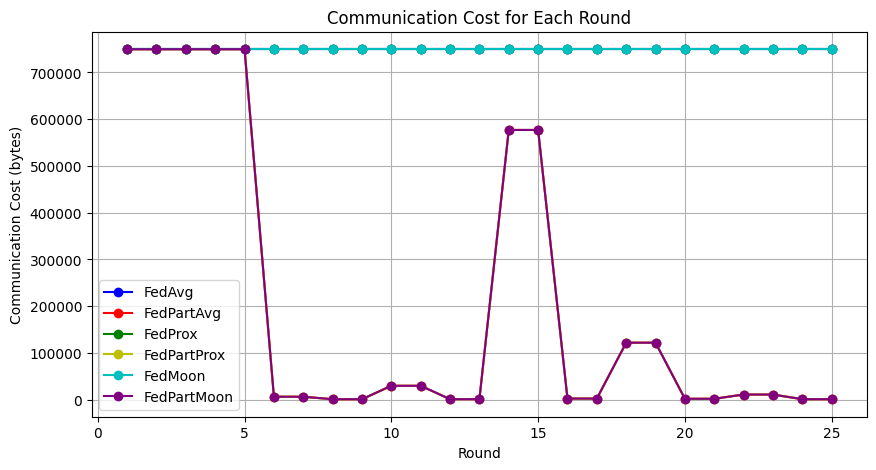

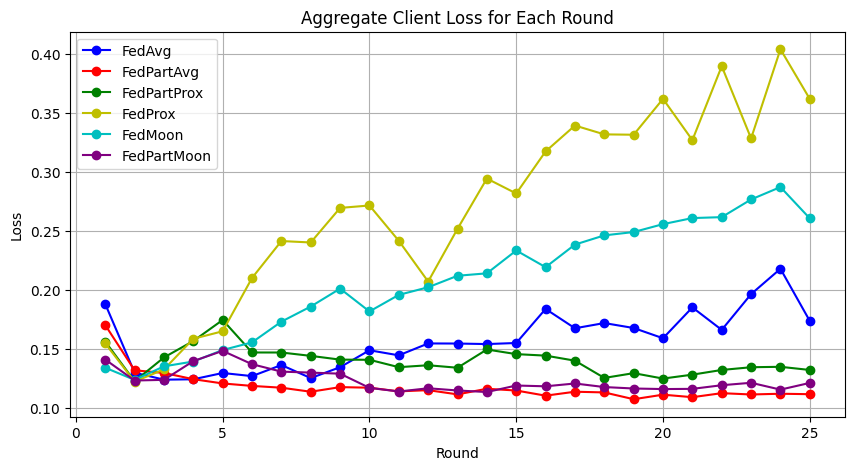

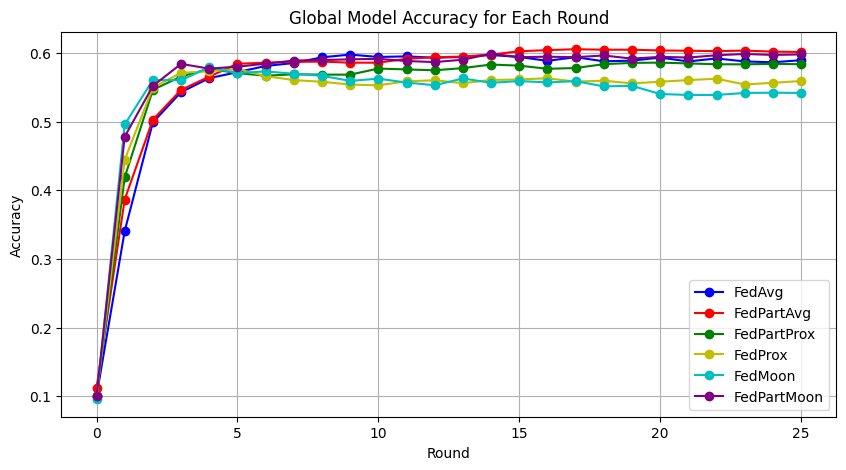

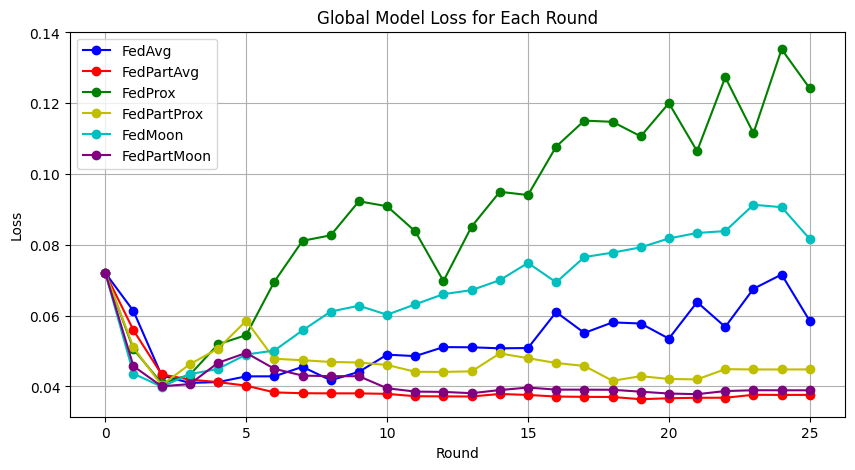

In [52]:
fed_moon_rounds = list(fed_moon_no_freeze_result.keys())
fed_moon_sizes = [fed_moon_no_freeze_result[round]["total_size"] for round in fed_moon_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='b', label='FedAvg')
plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_prox_rounds, fed_prox_sizes, marker='o', linestyle='-', color='g', label='FedProx')
plt.plot(fed_part_prox_rounds, fed_part_prox_sizes, marker='o', linestyle='-', color='y', label='FedPartProx')
plt.plot(fed_moon_rounds, fed_moon_sizes, marker='o', linestyle='-', color='c', label='FedMoon')
plt.plot(fed_part_moon_rounds, fed_part_moon_sizes, marker='o', linestyle='-', color='purple', label='FedPartMoon')
plt.xlabel('Round')
plt.ylabel('Communication Cost (bytes)')
plt.title('Communication Cost for Each Round')
plt.legend()
plt.grid(True)

fed_moon_losses = [fed_moon_no_freeze_result[round]["total_loss"] for round in fed_moon_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='b', label='FedAvg')
plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_part_prox_rounds, fed_part_prox_losses, marker='o', linestyle='-', color='g', label='FedPartProx')
plt.plot(fed_prox_rounds, fed_prox_losses, marker='o', linestyle='-', color='y', label='FedProx')
plt.plot(fed_moon_rounds, fed_moon_losses, marker='o', linestyle='-', color='c', label='FedMoon')
plt.plot(fed_part_moon_rounds, fed_part_moon_losses, marker='o', linestyle='-', color='purple', label='FedPartMoon')

plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Aggregate Client Loss for Each Round')
plt.legend()
plt.grid(True)

fed_moon_model_rounds = list(fed_moon_model_no_freeze_results.keys())
fed_moon_accuracies = [fed_moon_model_no_freeze_results[round]["global_metrics"]["accuracy"] for round in fed_moon_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='b', label='FedAvg')
plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_part_prox_model_rounds, fed_part_prox_accuracies, marker='o', linestyle='-', color='g', label='FedPartProx')
plt.plot(fed_prox_model_rounds, fed_prox_accuracies, marker='o', linestyle='-', color='y', label='FedProx')
plt.plot(fed_moon_model_rounds, fed_moon_accuracies, marker='o', linestyle='-', color='c', label='FedMoon')
plt.plot(fed_part_moon_model_rounds, fed_part_moon_accuracies, marker='o', linestyle='-', color='purple', label='FedPartMoon')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Global Model Accuracy for Each Round')
plt.legend()
plt.grid(True)

fed_moon_global_losses = [fed_moon_model_no_freeze_results[round]["global_loss"] for round in fed_moon_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='b', label='FedAvg')
plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_prox_model_rounds, fed_prox_global_losses, marker='o', linestyle='-', color='g', label='FedProx')
plt.plot(fed_part_prox_model_rounds, fed_part_prox_global_losses, marker='o', linestyle='-', color='y', label='FedPartProx')
plt.plot(fed_moon_model_rounds, fed_moon_global_losses, marker='o', linestyle='-', color='c', label='FedMoon')
plt.plot(fed_part_moon_model_rounds, fed_part_moon_global_losses, marker='o', linestyle='-', color='purple', label='FedPartMoon')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Global Model Loss for Each Round')
plt.legend()
plt.grid(True)
